# After adding 10 dB on the strong port at MXC

In [1]:
# from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from h5py import File
import os
from slab.dataanalysis import get_next_filename
import math
import scipy.special
from scipy.stats import poisson

C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten64.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps64.dll'
Could not load labbrick
Could not load BKPowerSupply
Could not load BKPowerSupply
Could not load BKPowerSupply
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten64.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\ins

# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x + b

def proportional(x, m):
    return m*x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*np.exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
    for ii in range(N):
        y = y + p[3*ii+1]*np.exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/5.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, N))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0] , np.sqrt(pcov[0][0])

def expfunc2(p,x):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*math.e**(-(x-p[1])/p[2])

def fitexp2(xdata, ydata, fitparams=None, domain=None, showfit=False, showstartfit=False, label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, b,c):
    return b * math.e**(-x/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)

def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*1535e3
    kappa = 2*np.pi*(7.79e9)/8418
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# Opt Pulse Generation

In [218]:
def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

def optimal_rr(readout_params, flat_top_amp):

    rr_f, rr_q, rr_len, dt, twochi = readout_params

    kappa = rr_f/rr_q
    cav_freq = 0
    n_points = int(rr_len/dt/10)
    pad_factor = 20
    t = dt * np.arange(0, n_points * pad_factor)
    ifreq = np.fft.fftfreq(n_points * pad_factor, dt)
    freq = np.fft.fftshift(ifreq)
    if_band = IF_window([cav_freq, 250e6], freq) 
    """Hard cut-off to constrain the BW of the output pulse to be within the AWG BW"""
#     pulse_len = 1/twochi
    pulse_len = rr_len
    
    """Find the sigma of rising waveform for a given flat top amplitude"""
    sigarray = np.arange(5e-9, 200e-9, 1.0e-9)
    ratio = []
    
    for sig in sigarray:
        desired_output = erf_t(1, sig, pulse_len, 100e-9, t)
        
        desired_output_ifft = np.fft.fft(desired_output, n_points * pad_factor)/n_points
        desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

        lorenz_c = cav_response_new([cav_freq, kappa], freq)

        input_sfft = (desired_output_sfft/lorenz_c)*if_band

        output_sfft = input_sfft*lorenz_c
        output_fft = np.fft.ifftshift(output_sfft)
        output_pulse = np.fft.ifft(output_sfft)

        input_fft = np.fft.ifftshift(input_sfft)
        input_pulse = np.fft.ifft(input_fft)

        flip = input_pulse[::-1]

        opt_pulse = np.real(flip)

        max_opt = np.max(opt_pulse)
        mid_opt = opt_pulse[int(len(opt_pulse)/2)]
        ratio.append(mid_opt/max_opt)

        
    ratio_targ = flat_top_amp
    ratio = np.array(ratio)
    index = np.argmin(abs(ratio-ratio_targ))

    desired_sigma = sigarray[index]
    print(desired_sigma)
    """Returns the sigma"""

    desired_output = erf_t(1, desired_sigma, pulse_len, 100e-9, t)

    #Generate Opt Input Pulse
    desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

    lorenz_c = cav_response_new([cav_freq, kappa], freq)
#     lorenz_g = cav_response_new([rr_f + 0.2e6, Q], freq)
#     lorenz_e = cav_response_new([rr_f - 0.2e6, Q], freq)
#     lorenz = (lorenz_g * lorenz_e)

    input_sfft = (desired_output_sfft/lorenz_c)*if_band

    output_sfft = input_sfft * lorenz_c
    output_fft = np.fft.ifftshift(output_sfft)
    output_pulse = np.fft.ifft(output_sfft)

    input_fft= np.fft.ifftshift(input_sfft)
    input_pulse = np.fft.ifft(input_fft)
    flip=input_pulse[::-1]

    opt_pulse = np.real(flip)
    opt_pulse = opt_pulse/np.max(opt_pulse)
    #Find Desired Range
    result1 = np.where(opt_pulse < 0.001*flat_top_amp)[0]
    result2 = np.where(opt_pulse > 0.0*flat_top_amp)[0]

    #Trim Pulse
    start_trim = result1[np.argmin(abs(np.argmax(opt_pulse)-result1))]
    end_trim = result2[np.argmin(abs(np.argmin(opt_pulse)-result2))]

#     end_trim = result2[len(result2[0])-1]
    numb = end_trim - start_trim  
    rem = numb % 4

    #Check Total Length is Multiple of 4 for AWG
    trim_pulse = opt_pulse[start_trim:end_trim - rem]
    check = len(trim_pulse) % 4
    if check !=0:
        print('Error: The final pulse is not a multiple of 4')
    
    return trim_pulse

5.0999999999999993e-08


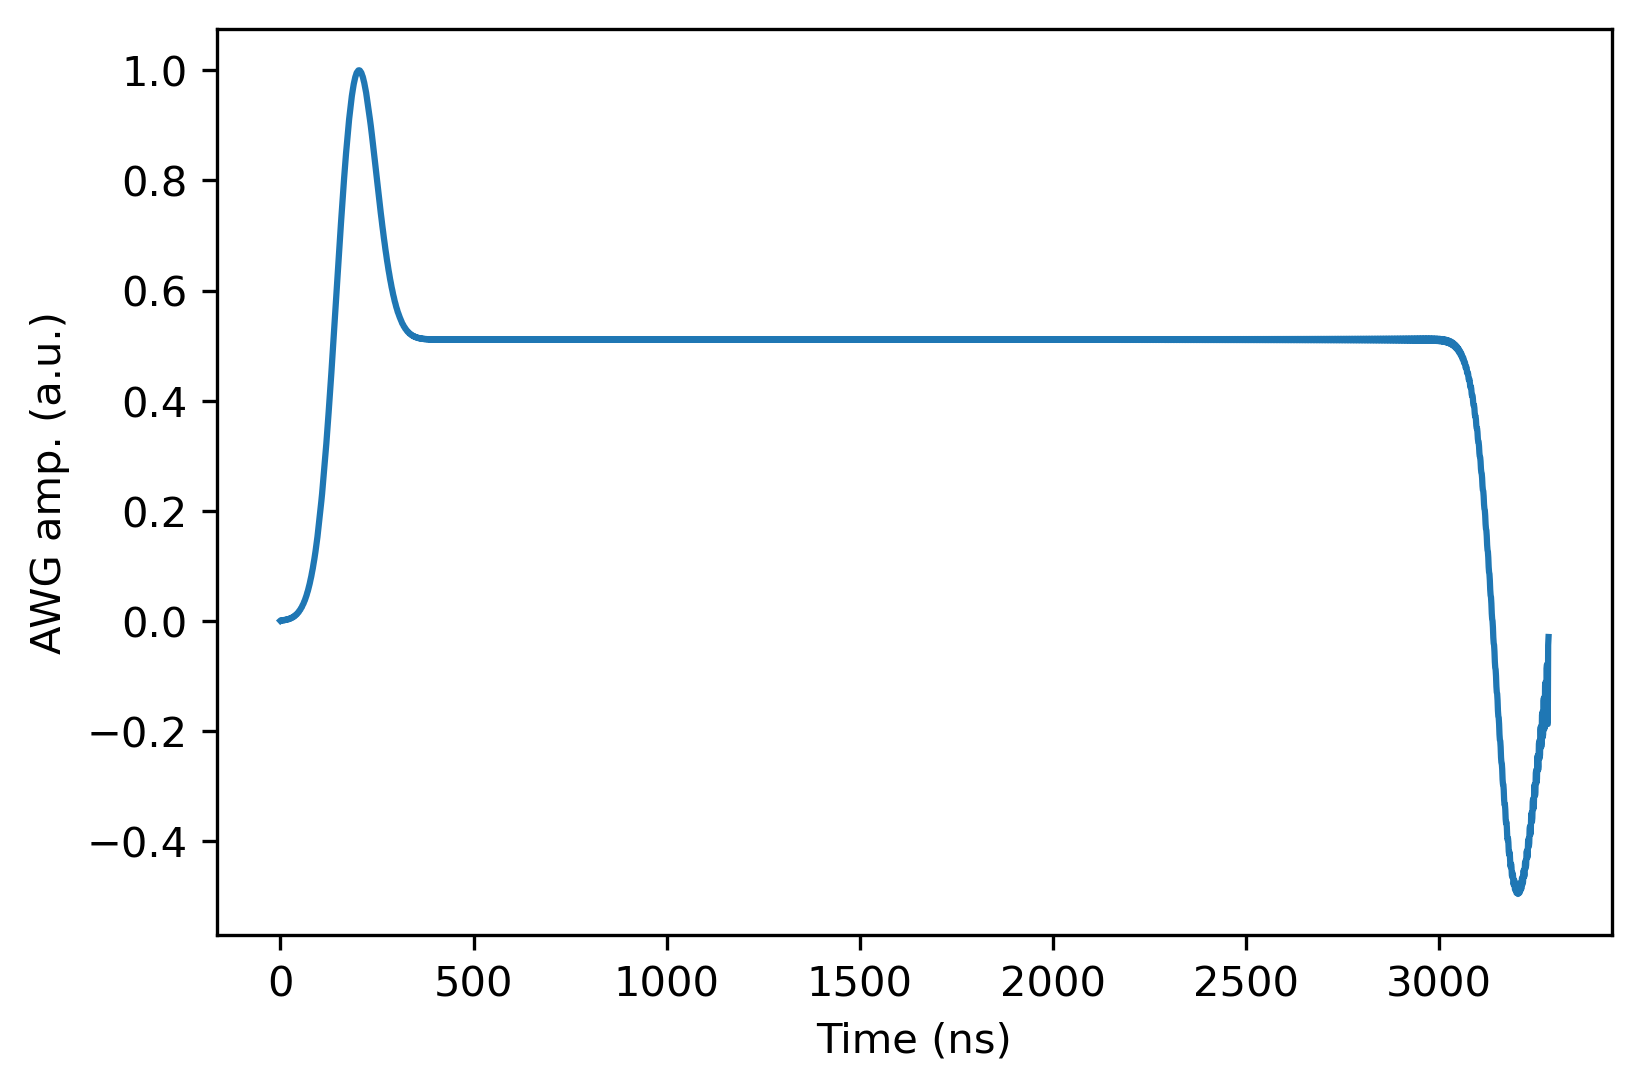

3284


In [224]:
"""Comments for the output pulse

1. Coarsely find the optimal amptidue for a square shape pulse which results in maximum g-e fidelity
2. Use that as the 'flat_top_amp' for the optimal shape

"""



read_params = [7.790125*1e9, 8760, 3e-6, 1e-9, 1533e3]
s = optimal_rr(read_params, flat_top_amp=0.6)

plt.figure(dpi=300)
plt.plot(s)
plt.xlabel('Time (ns)')
plt.ylabel('AWG amp. (a.u.)')
plt.show()

print(len(s))

In [200]:
len(f)

3428

In [205]:
f= np.where(s>-0.0010)[0]

np.argmin(abs(np.argmin(s)-f))

5554

In [206]:
(f[5554])

5846

In [221]:
len(s)

3284

## Save Opt Pulse Shape

In [225]:
path = os.getcwd()
data_path = os.path.join(path, "../pulses/")
seq_data_file = os.path.join(data_path,
                             get_next_filename(data_path, 'readout_optimal_pulse', suffix='.h5'))
print(seq_data_file)
with File(seq_data_file, 'w') as f:
    f.create_dataset("I_wf", data=s)

C:\_Lib\python\slab\experiments\qm_opx_mm\jupyter_notebooks\../pulses/00011_readout_optimal_pulse.h5


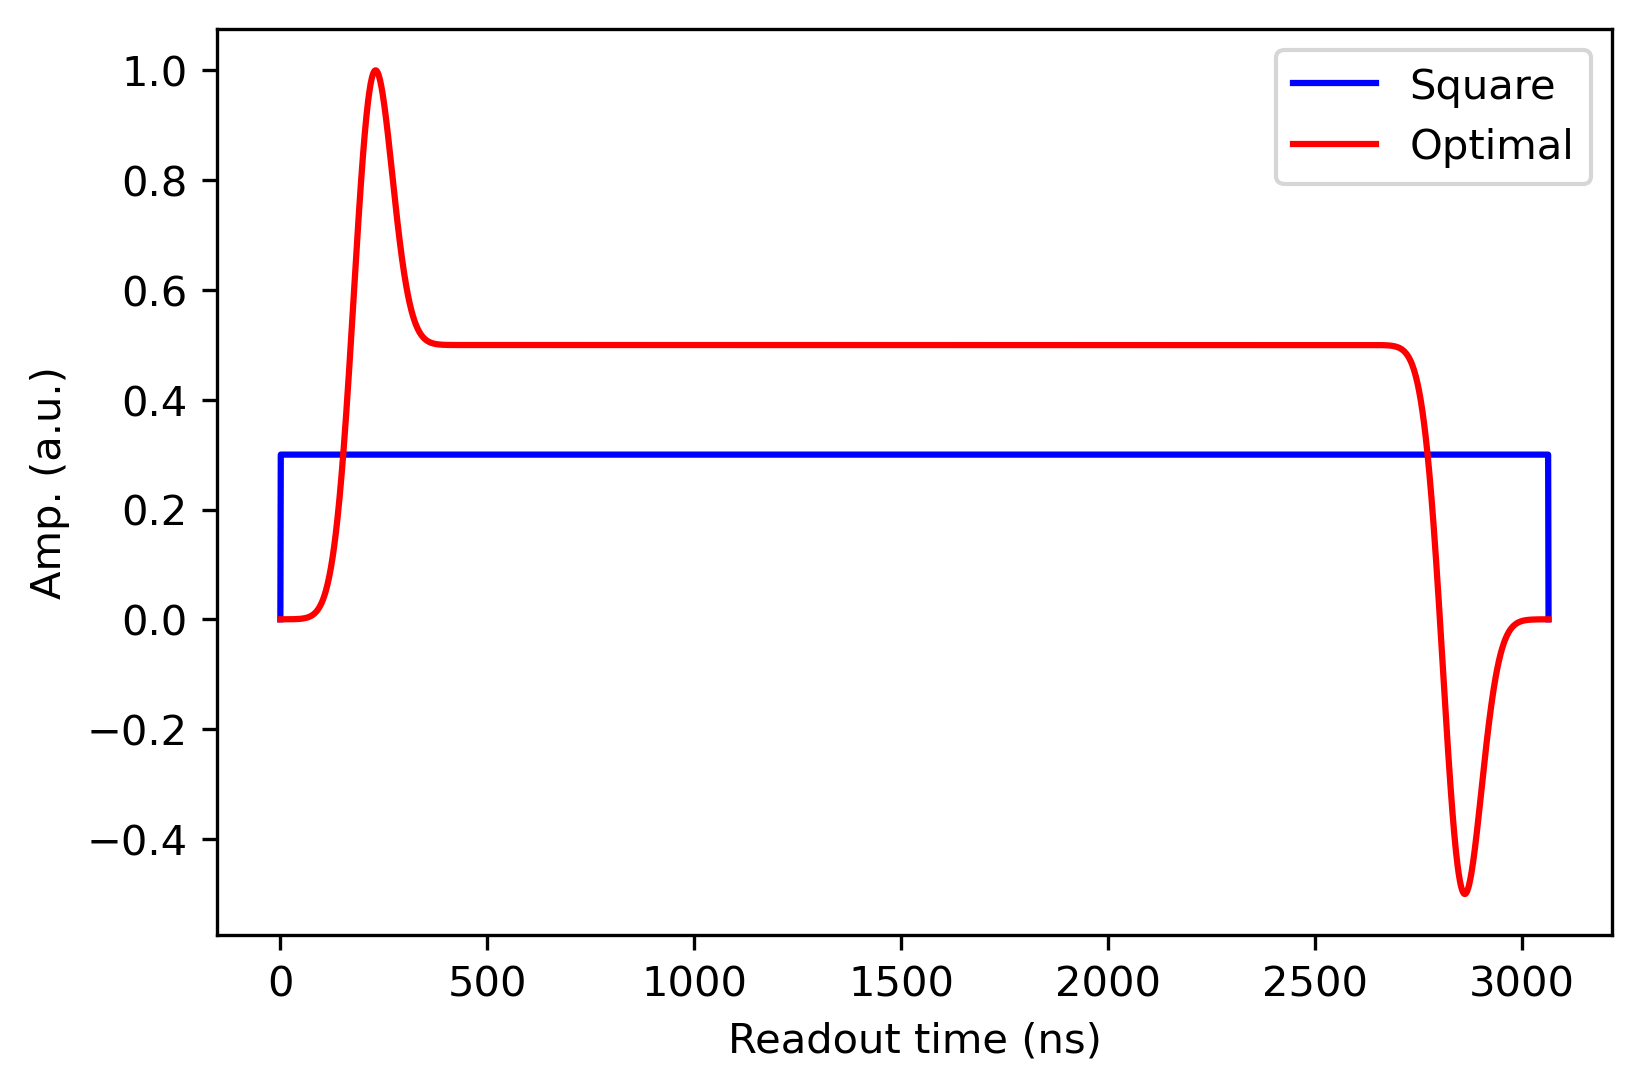

In [223]:
for i in [10]:
    opt_readout = "C:\\_Lib\\python\\slab\\experiments\\qm_opx\\pulses\\000{}_readout_optimal_pulse.h5".format(i)
    with File(opt_readout,'r') as a:
        opt_amp = np.array(a['I_wf'])
    opt_len = len(opt_amp)

sq = [x for x in 0.3*np.ones(len(opt_amp-2))]

sq.append(0)
sq[0] = 0
plt.figure(dpi=300)
plt.plot(sq, color='blue',label='Square')

plt.plot(opt_amp, color='r',label='Optimal')
plt.plot()
plt.ylabel('Amp. (a.u.)')
plt.xlabel('Readout time (ns)')
plt.legend(loc='best')
plt.savefig('2021-06-09-readout_shape.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
opt_amp[1500]

0.6012571950500214

# readout population

## Square pulse

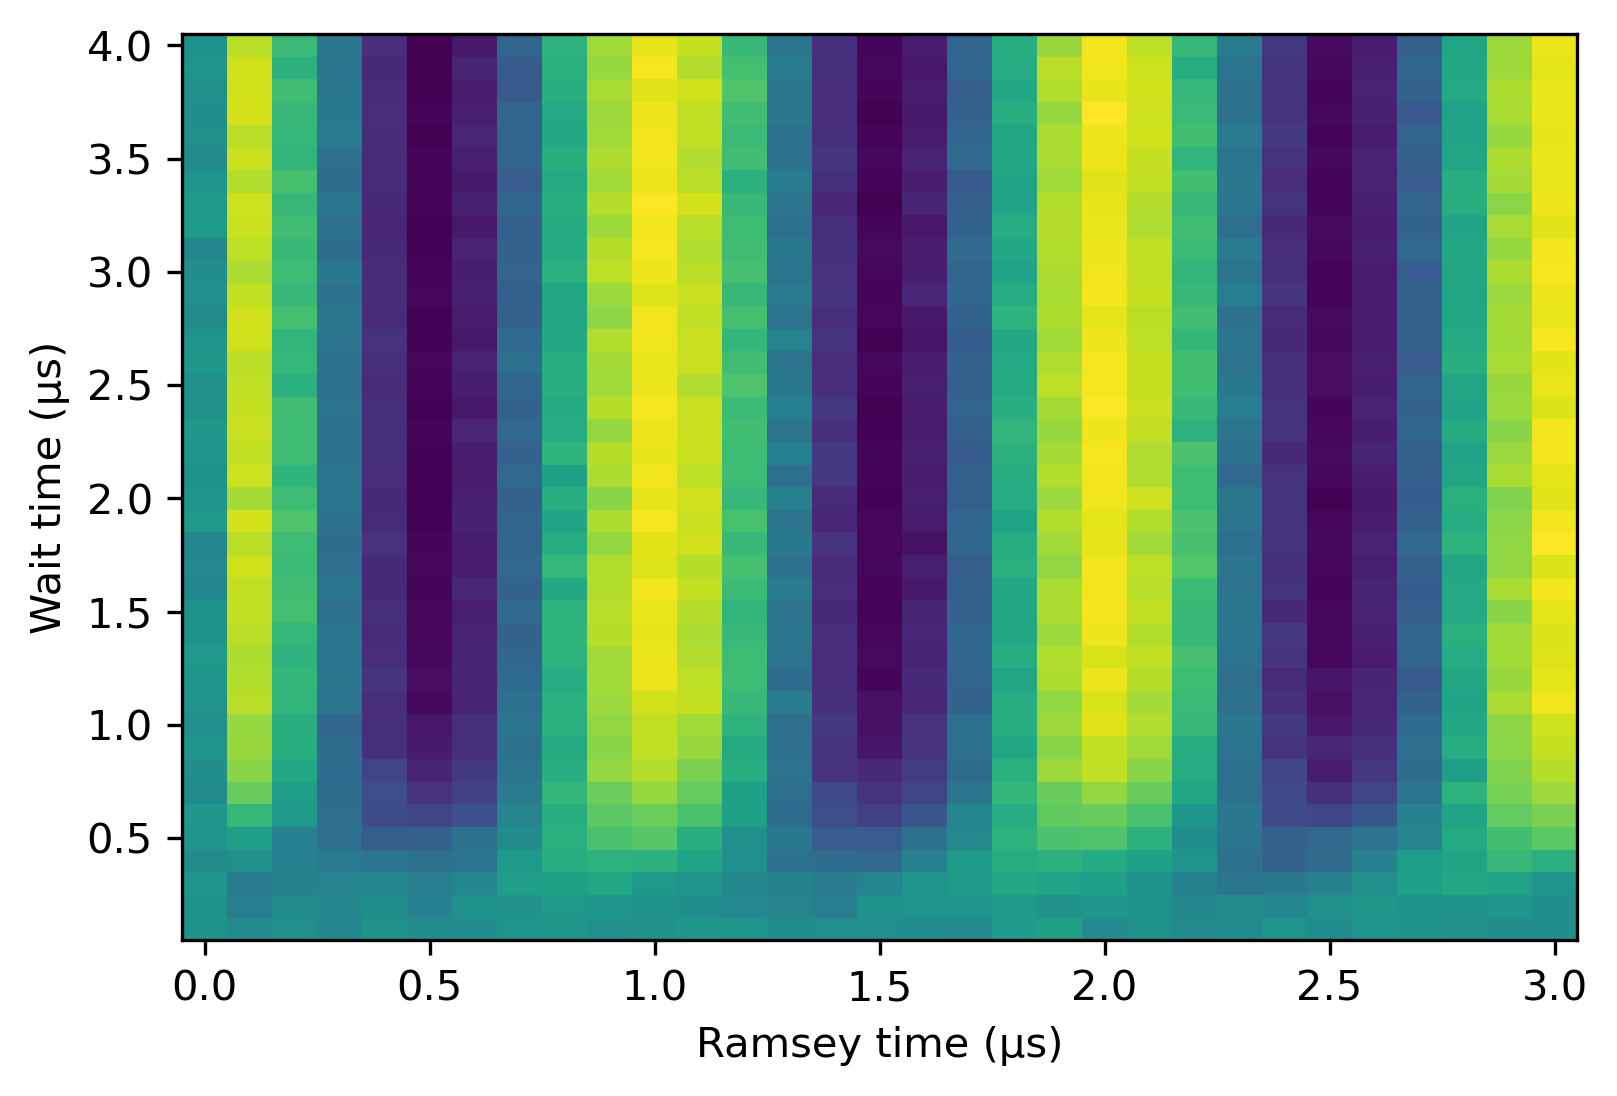

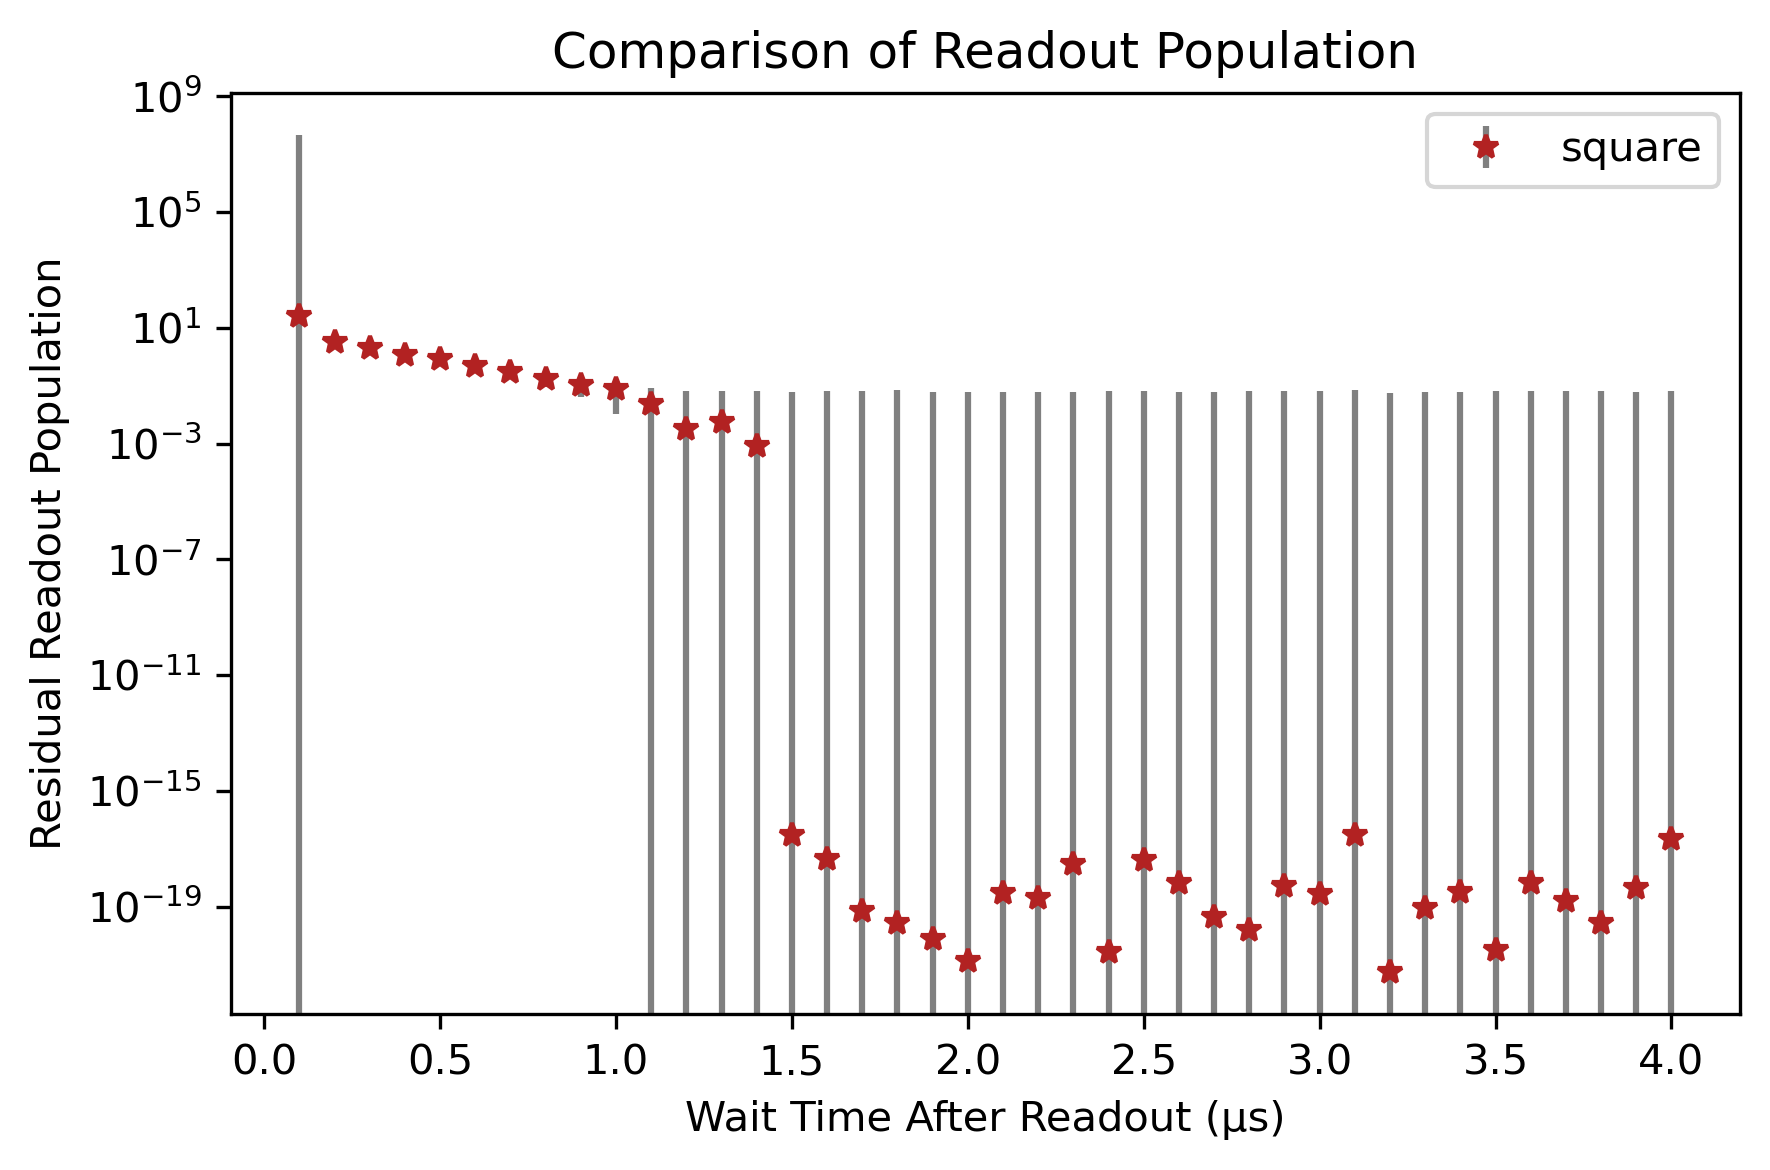

In [65]:
expt_name = 'ramsey_square'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_sq = pd.DataFrame(a['I'])
        Q_sq = pd.DataFrame(a['Q'])
        wait_times_sq = array(a['wait_time'])/1e9
        ramsey_times_sq = array(a['ramsey_times'])/1e9
        
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_sq*1e6, wait_times_sq*1e6, Q_sq, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\sq_pulse_2d_buffer_no_wait_time.png')
plt.show()


read_sq_sq = []
read_sq_error_sq = []
for j in range(len(wait_times_sq)):
    y_data = Q_sq.iloc[j]
    x_data = ramsey_times_sq
    psq, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf, 2*np.pi, np.inf]))
    read_sq_sq.append(psq[0])
    read_sq_error_sq.append(np.sqrt(np.diag(pcov)[0]))

fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_sq*1e6, read_sq_sq, yerr = read_sq_error_sq, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='square')
ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
ax1.set_yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Psq_Comp_talk_full.pdf')
plt.show()

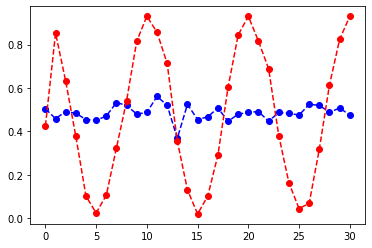

In [52]:
plt.plot(Q_sq.iloc[0], 'bo--')
plt.plot(Q_sq.iloc[-1], 'ro--')

## Optimal pulse

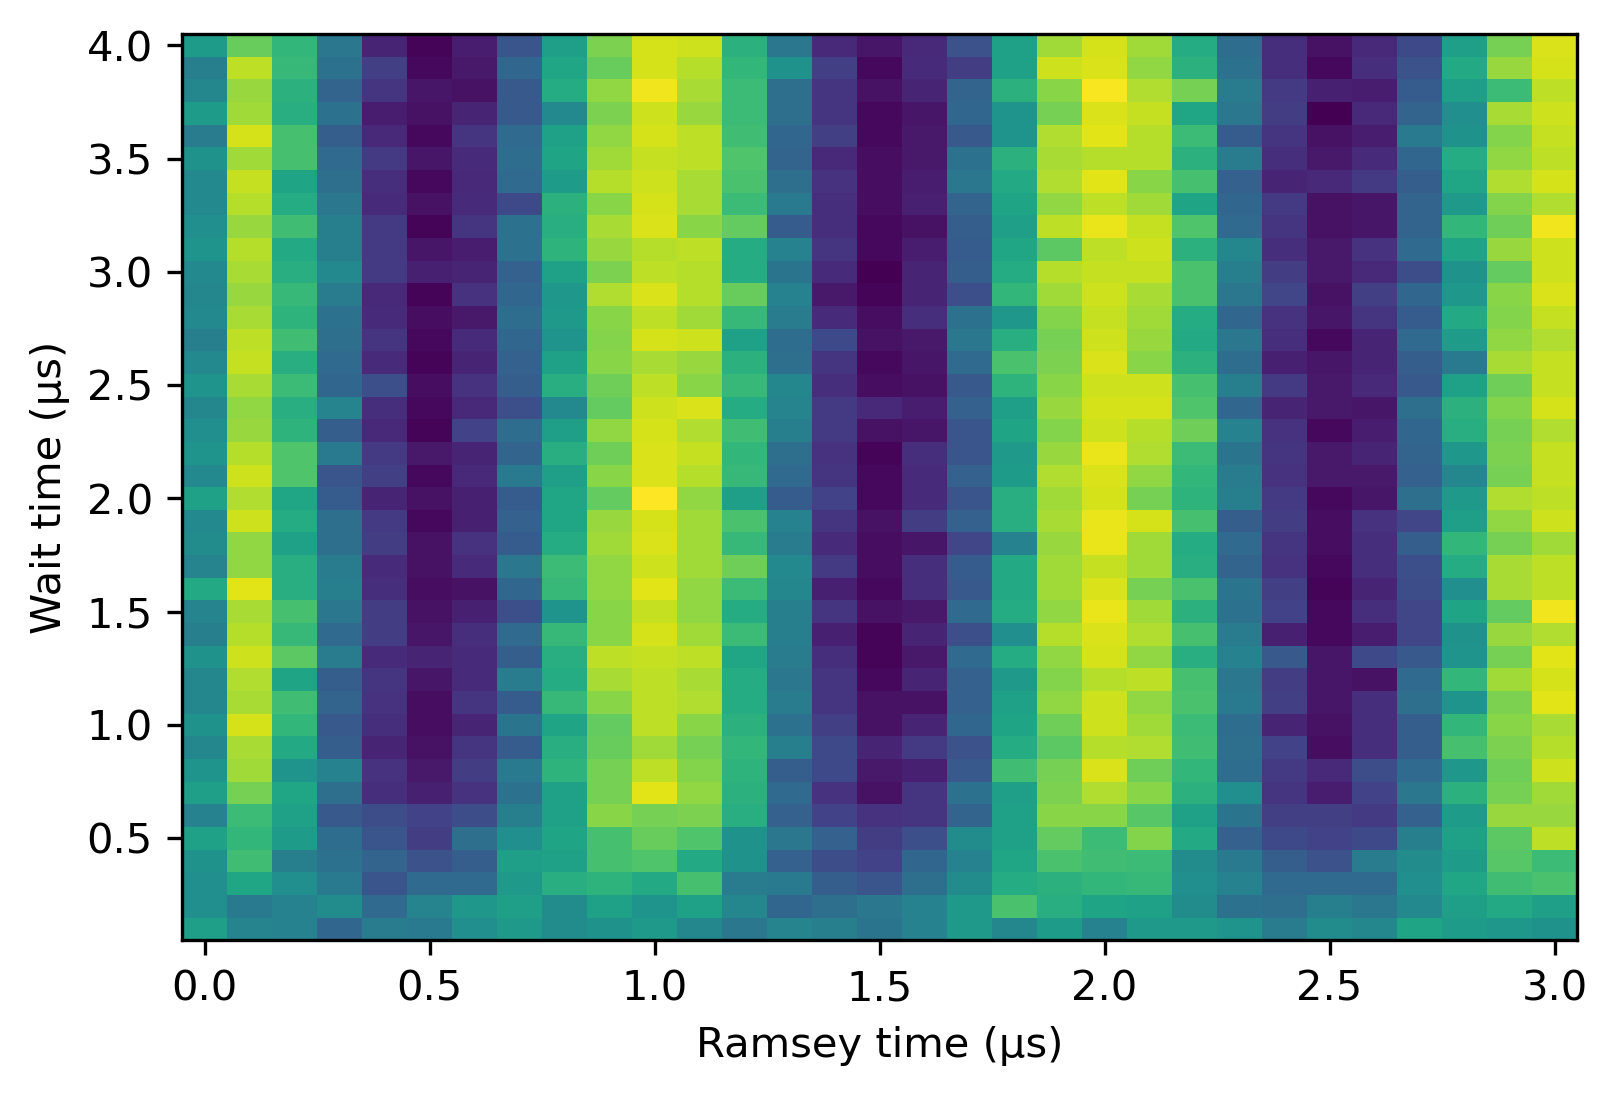

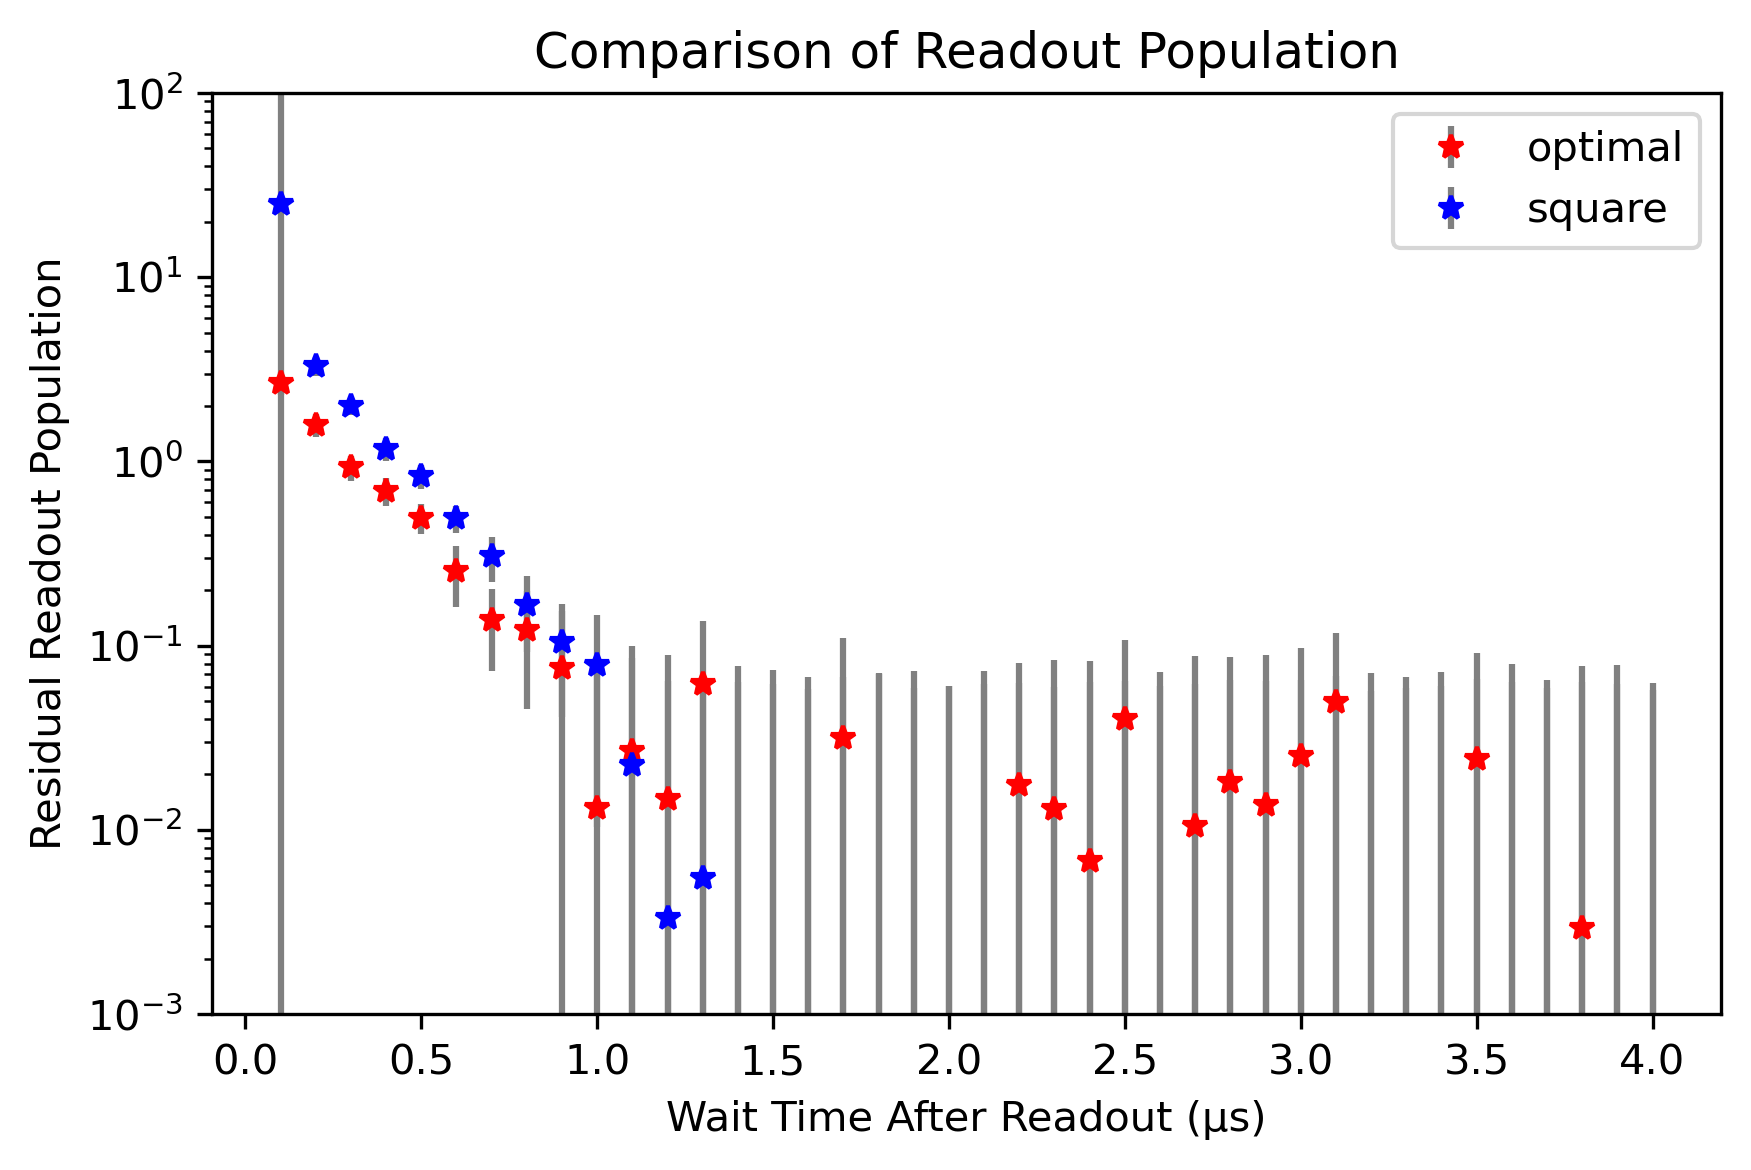

In [66]:
expt_name = 'ramsey_clear'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_opt = pd.DataFrame(a['I'])
        Q_opt = pd.DataFrame(a['Q'])
        wait_times_opt = array(a['wait_time'])/1e9
        ramsey_times_opt = array(a['ramsey_times'])/1e9
        
        y = Q_opt
        
        plt.figure(dpi=300)
        plt.pcolormesh(ramsey_times_opt*1e6, wait_times_opt*1e6, y, shading='auto')
        plt.xlabel('Ramsey time (μs)')
        plt.ylabel('Wait time (μs)')
        # plt.savefig('S:\Morgan\qm_opx\morgan\plots\opt_pulse_2d_buffer_no_wait_time.png')
        plt.show()


        read_popt_opt = []
        read_popt_error_opt = []
        for j in range(len(wait_times_opt)):
            y_data = y.iloc[j]
            x_data = ramsey_times_opt
            popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf,2*np.pi,np.inf]))
            read_popt_opt.append(popt[0])
            read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))

        fig, ax1  = plt.subplots(dpi=300)

        ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='r', 
                     ecolor='grey', capthick=2, label='optimal')
        ax1.errorbar(wait_times_sq*1e6, read_sq_sq, yerr = read_sq_error_sq, fmt='*', color='b',
                     ecolor='grey', capthick=2, label = 'square')

        ax1.set_title('Comparison of Readout Population')
        ax1.set_ylabel('Residual Readout Population')
        ax1.set_xlabel('Wait Time After Readout (μs)')
        ax1.set_yscale('log')
        ax1.set_yscale('log')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.ylim(1e-3, 1e2)
#         plt.savefig('2021-06-09-readout_pop_compare.png', dpi=300, bbox_inches='tight')
        plt.show()

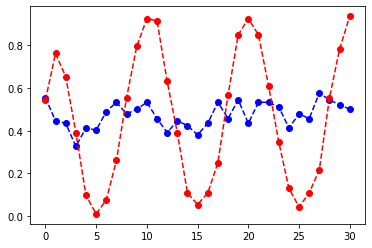

In [67]:
plt.plot(Q_opt.iloc[0], 'bo--')
plt.plot(Q_opt.iloc[-1], 'ro--')

In [53]:
np.exp(-3.2/100)

0.9685065820791976

In [54]:
np.exp(-2/100)

0.9801986733067553

# Cavity calibration

## Square pulse, 8μs

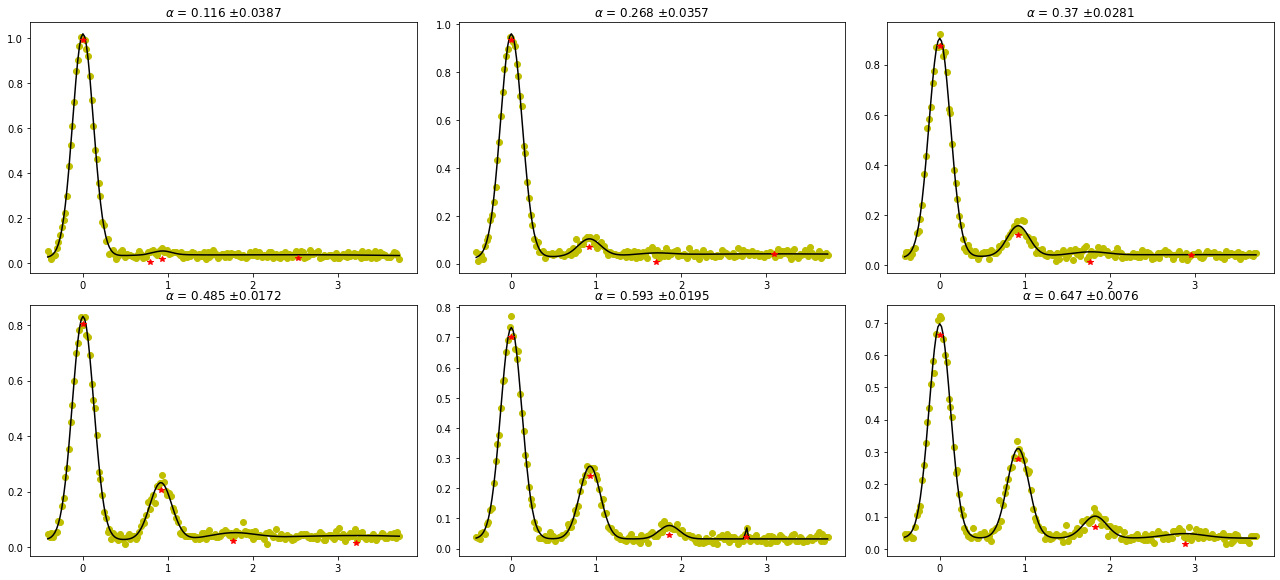

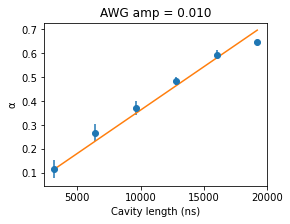

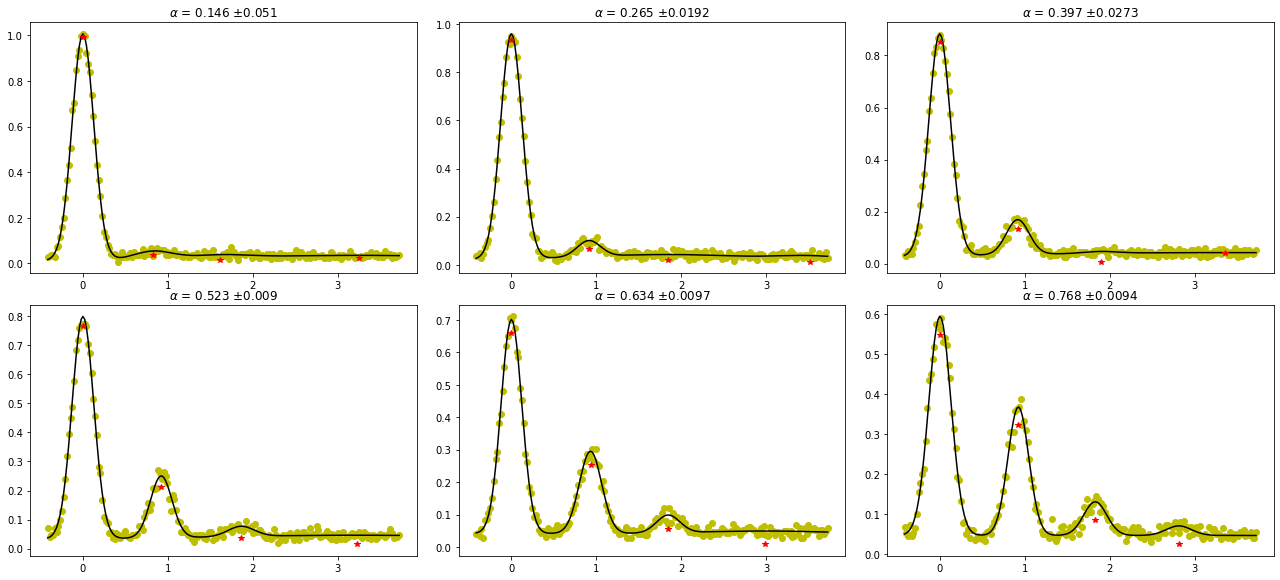

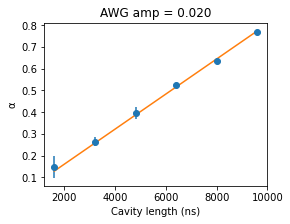

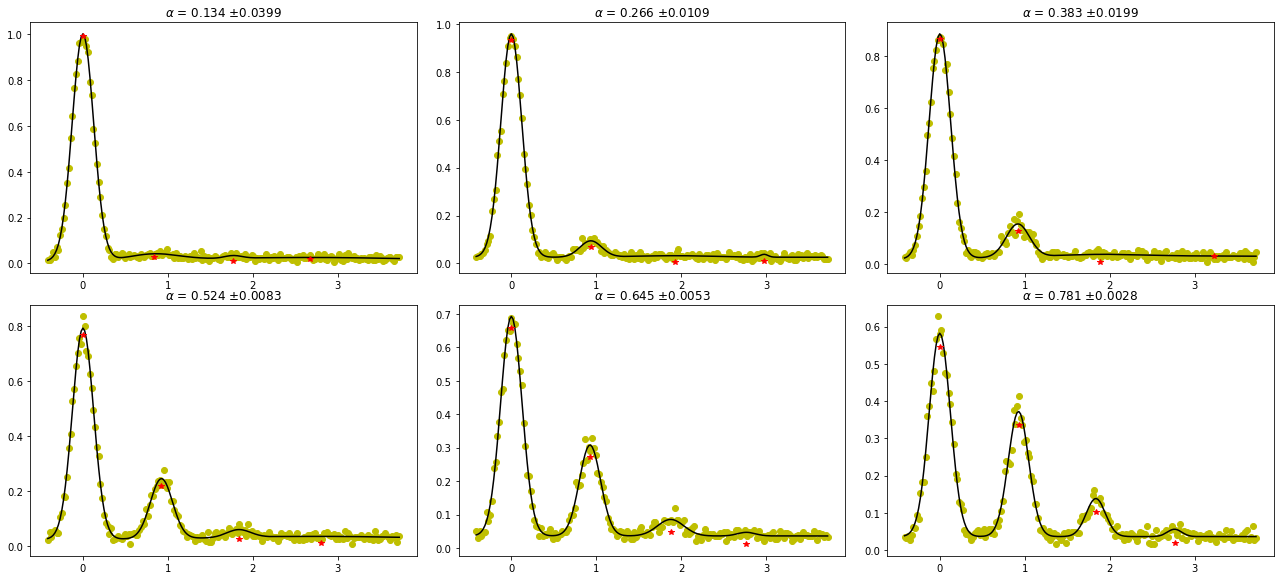

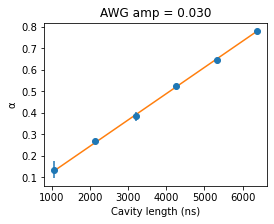

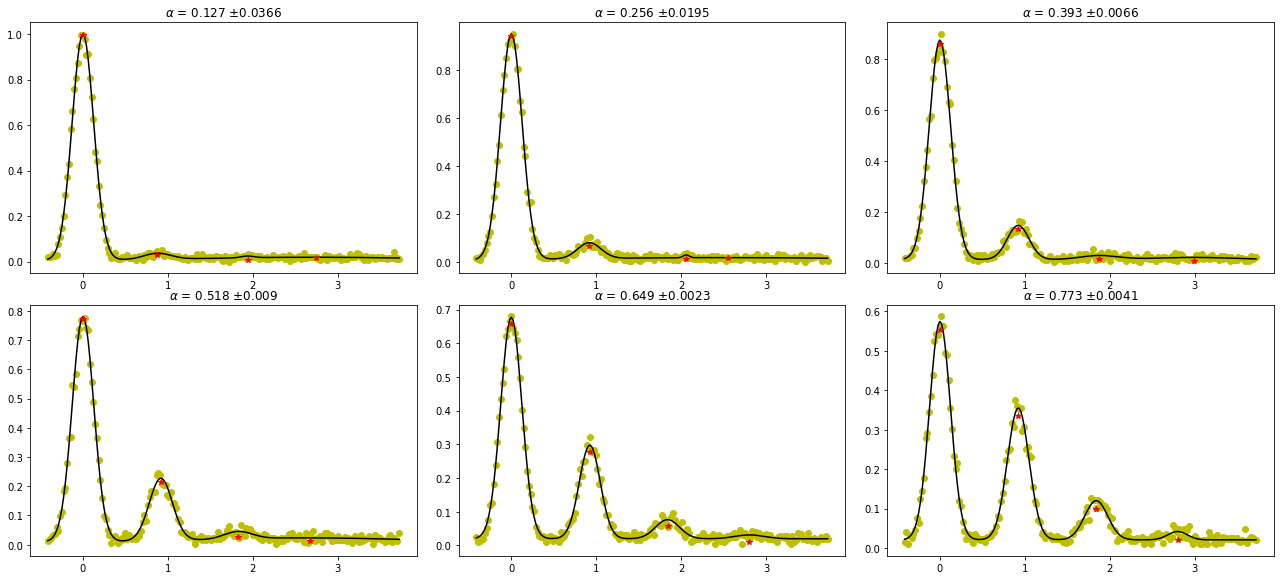

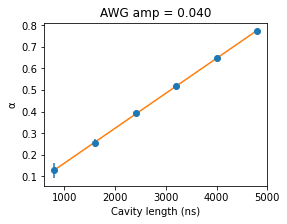

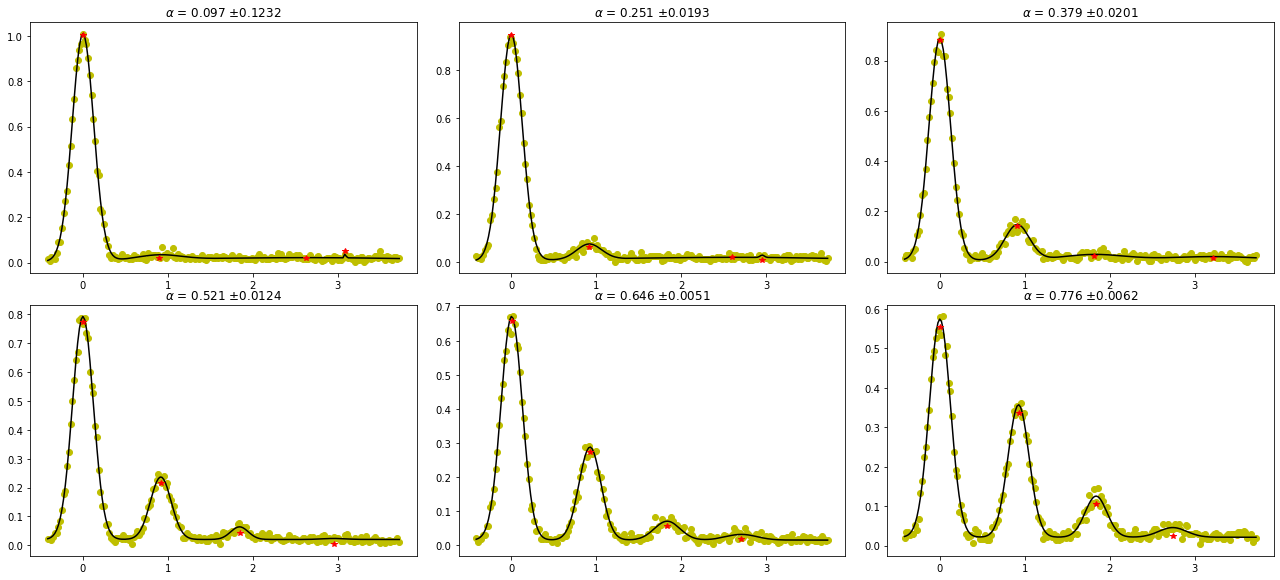

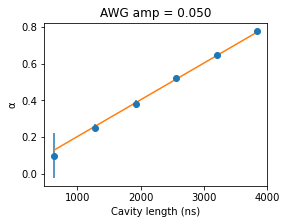

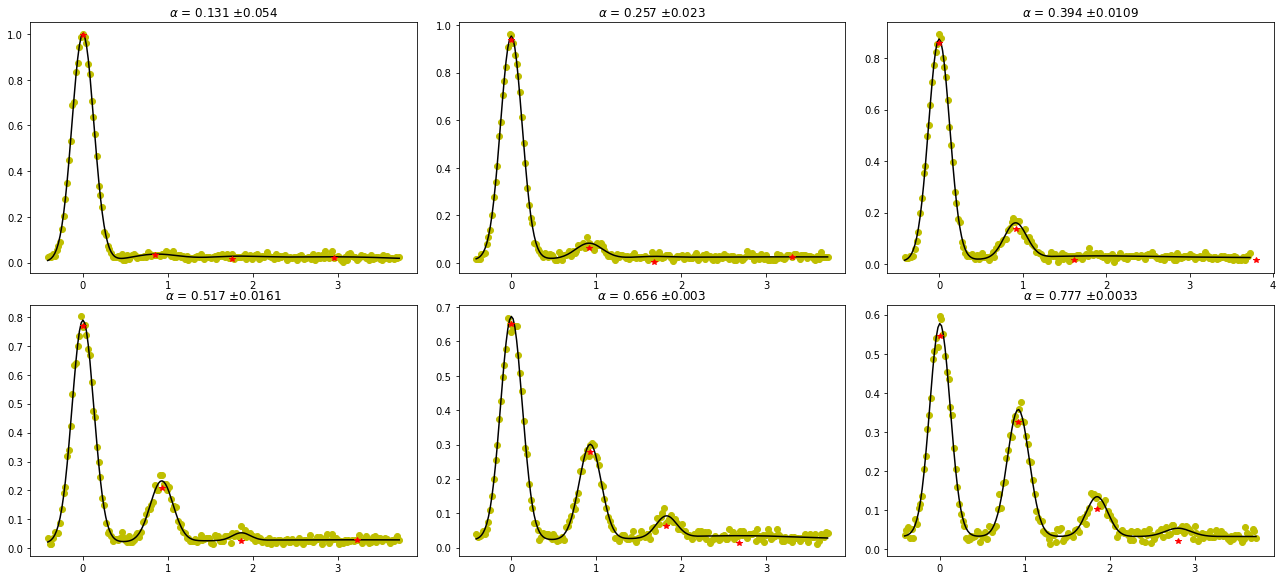

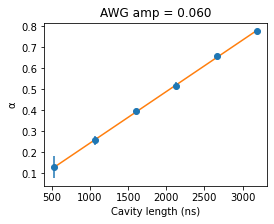

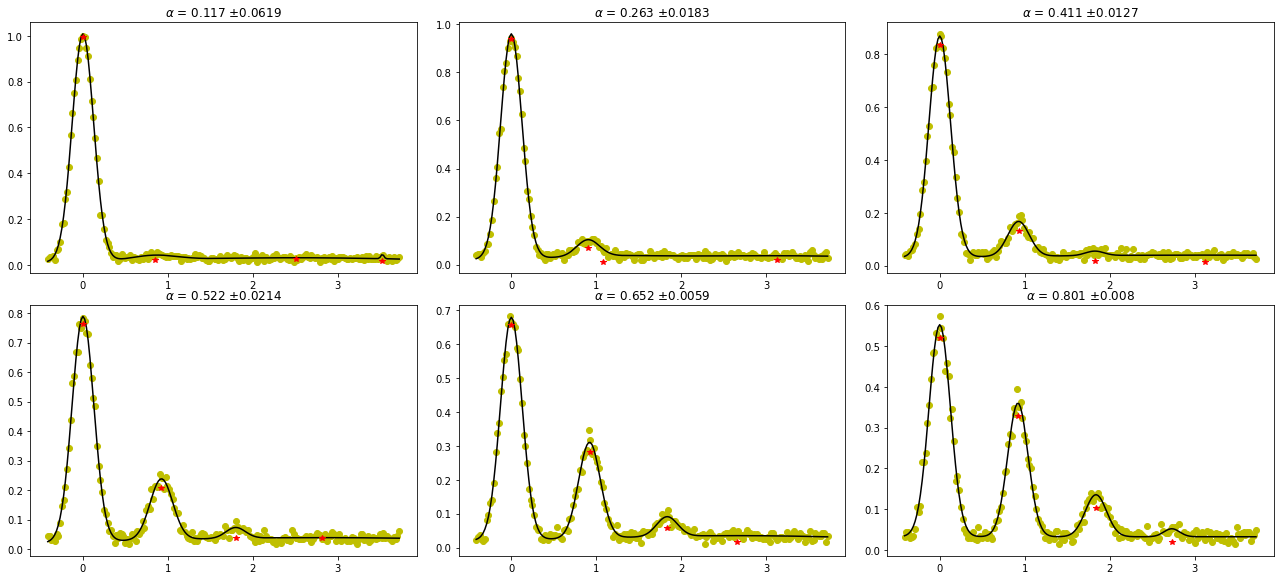

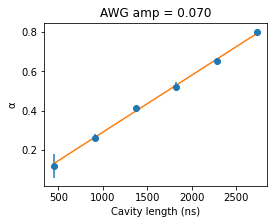

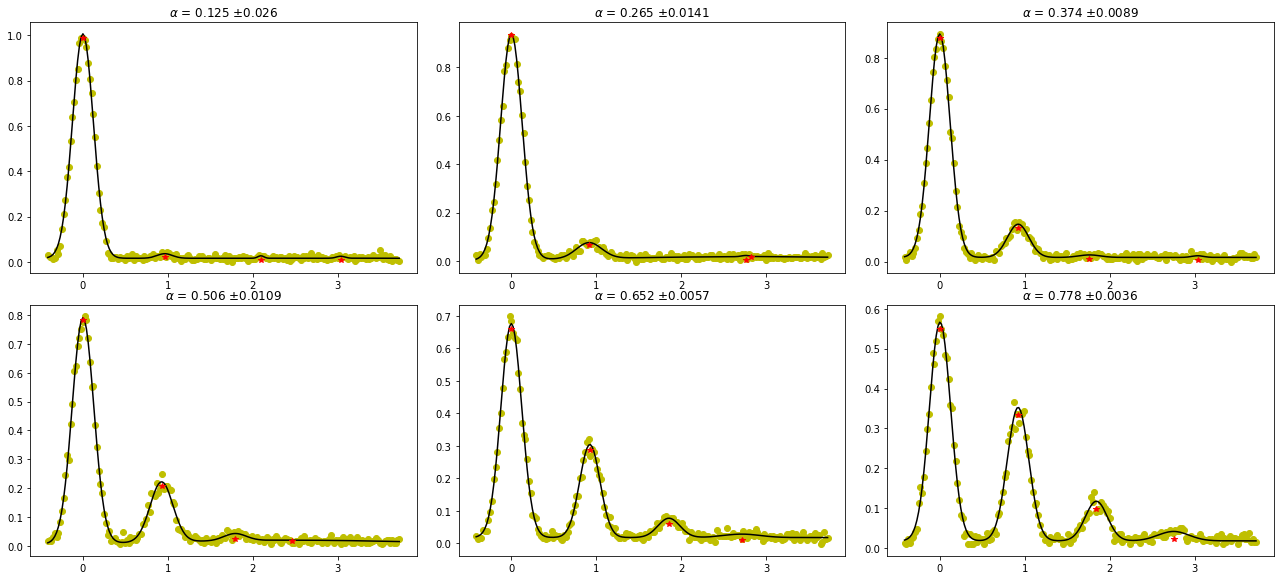

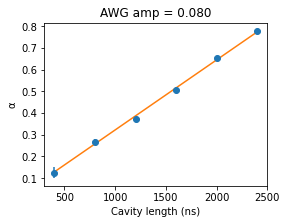

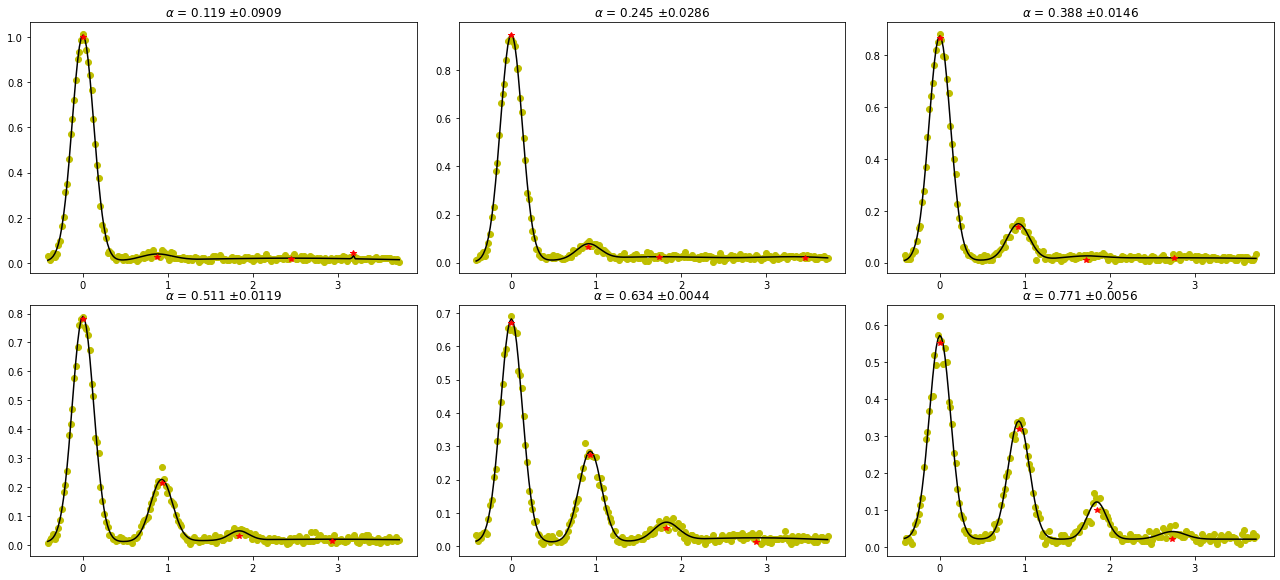

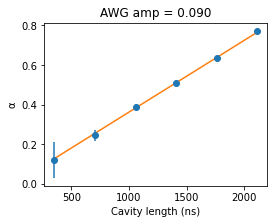

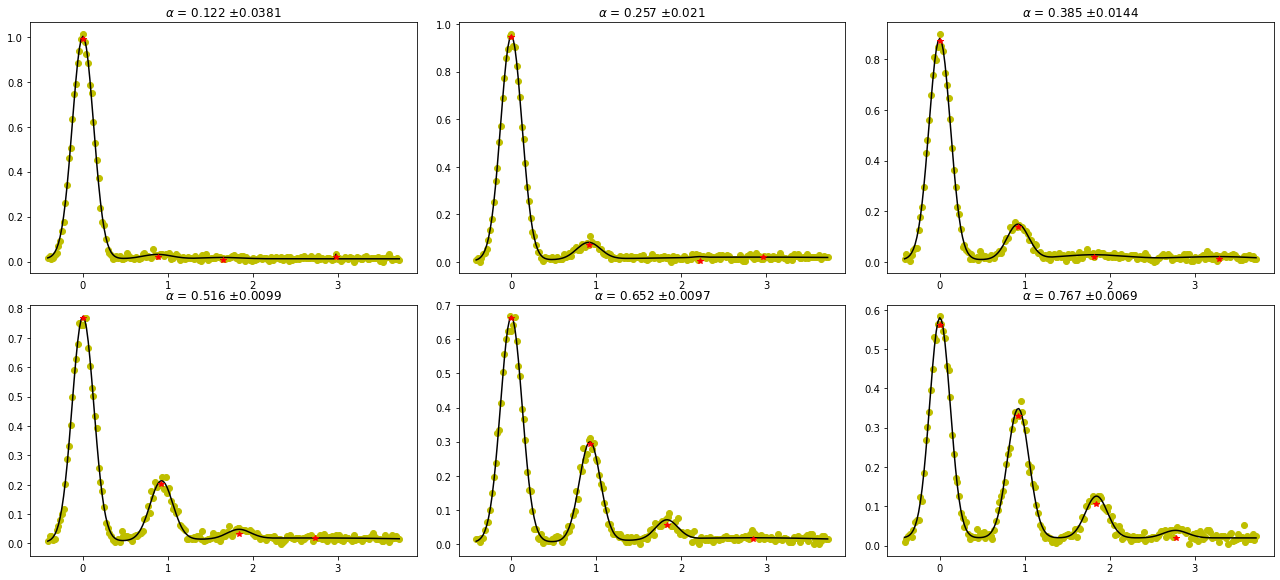

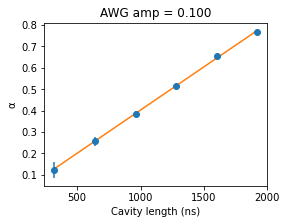

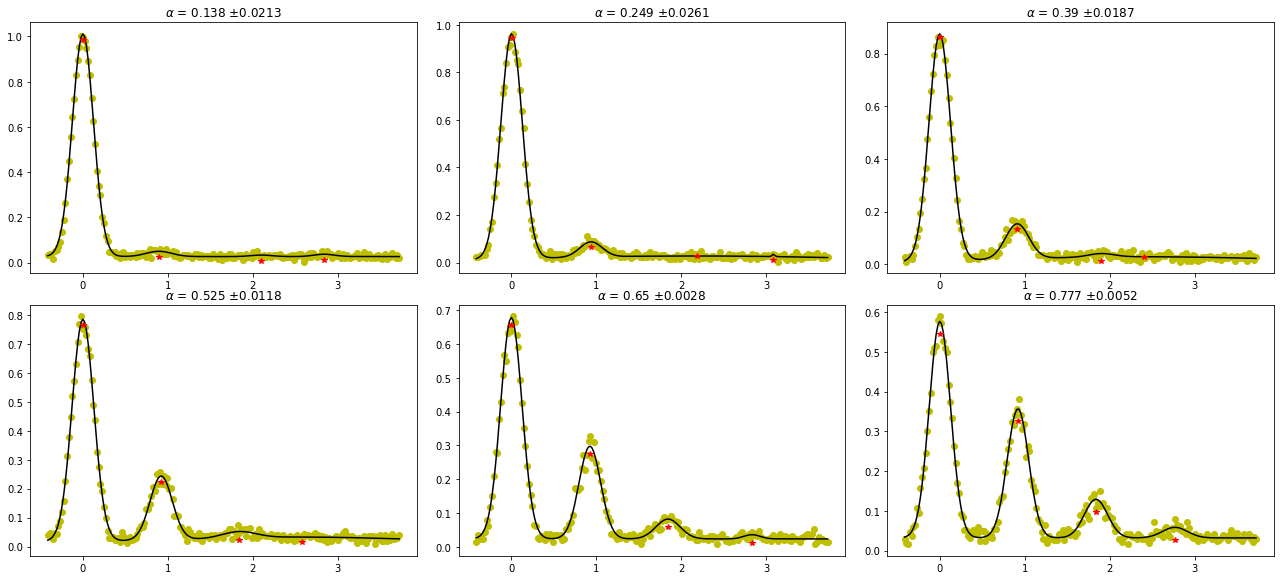

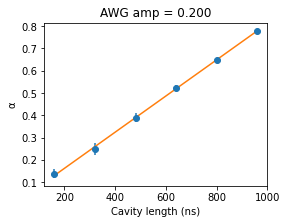

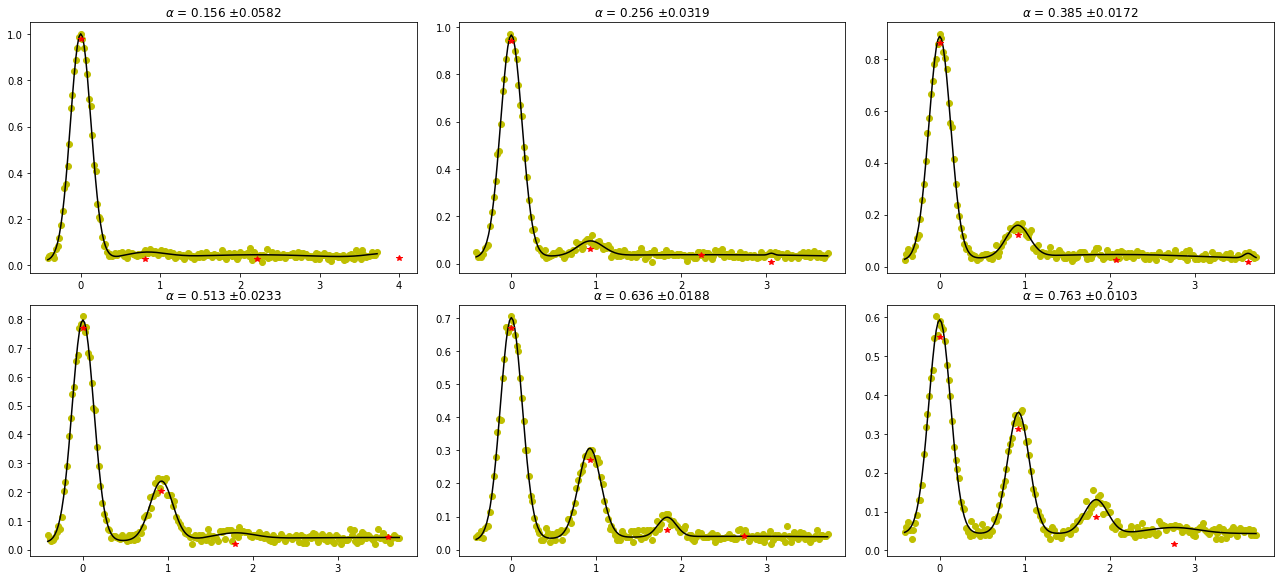

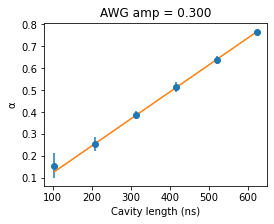

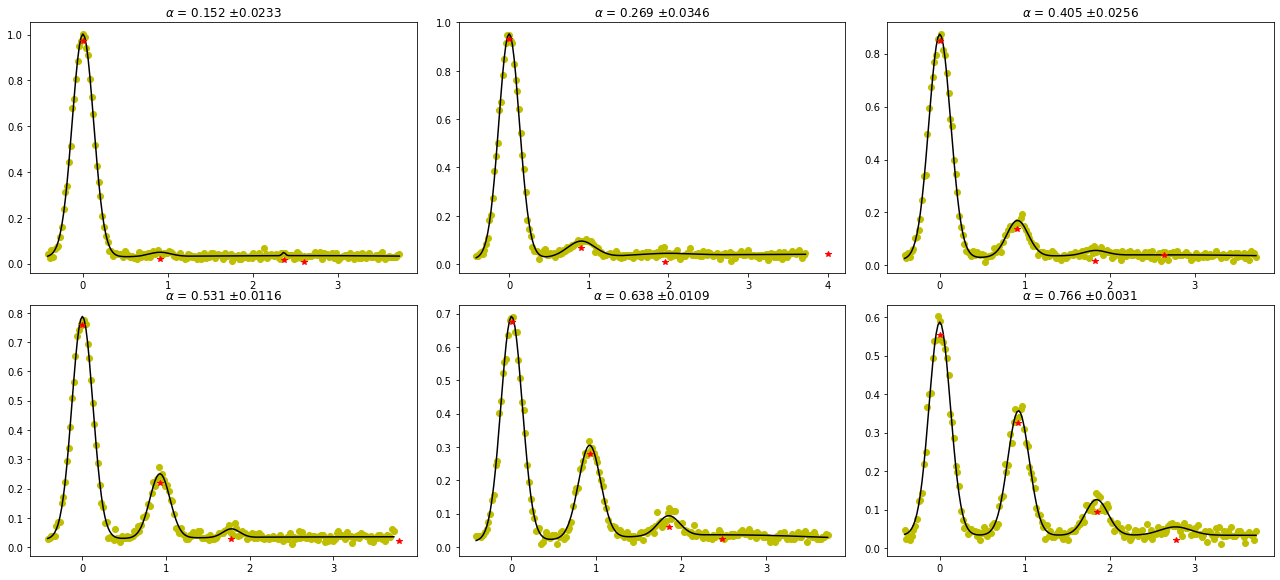

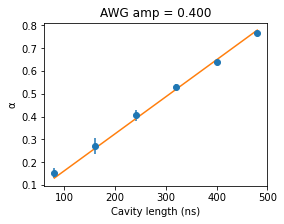

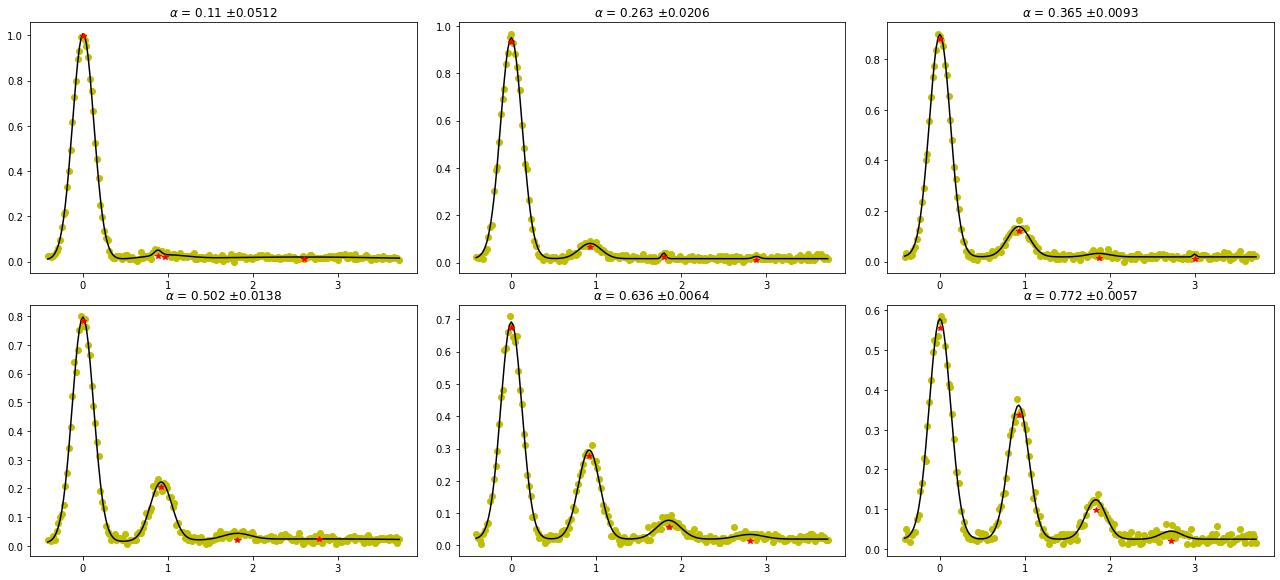

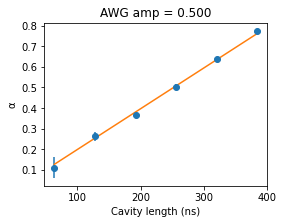

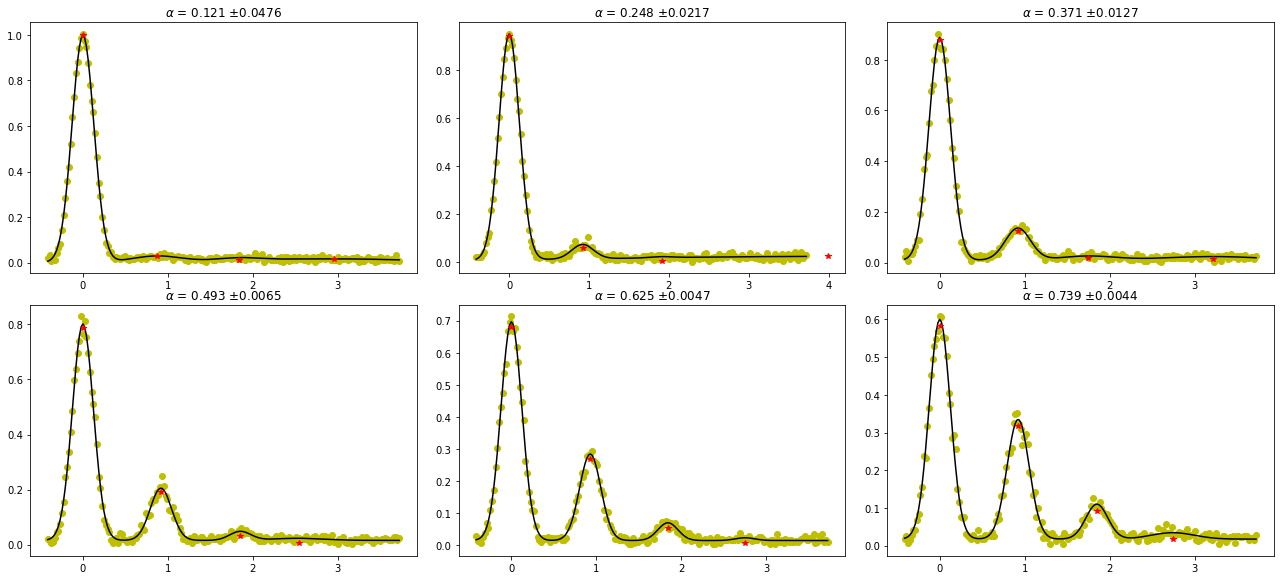

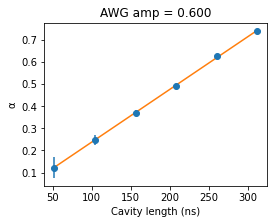

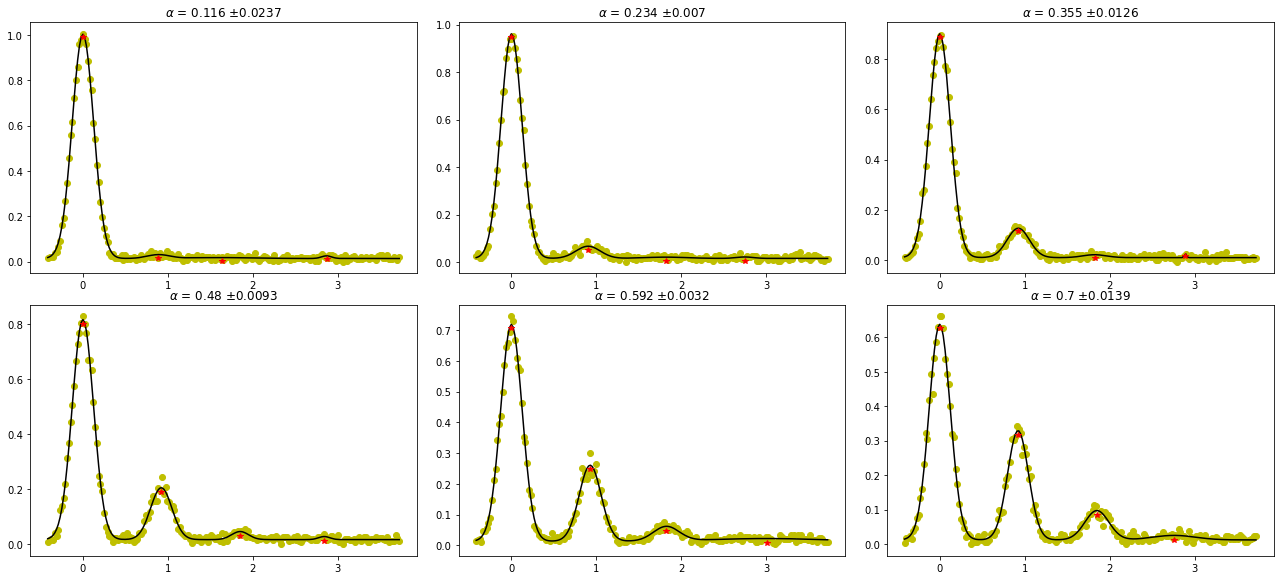

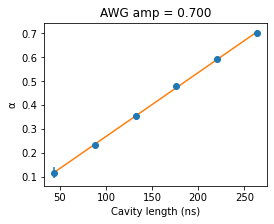

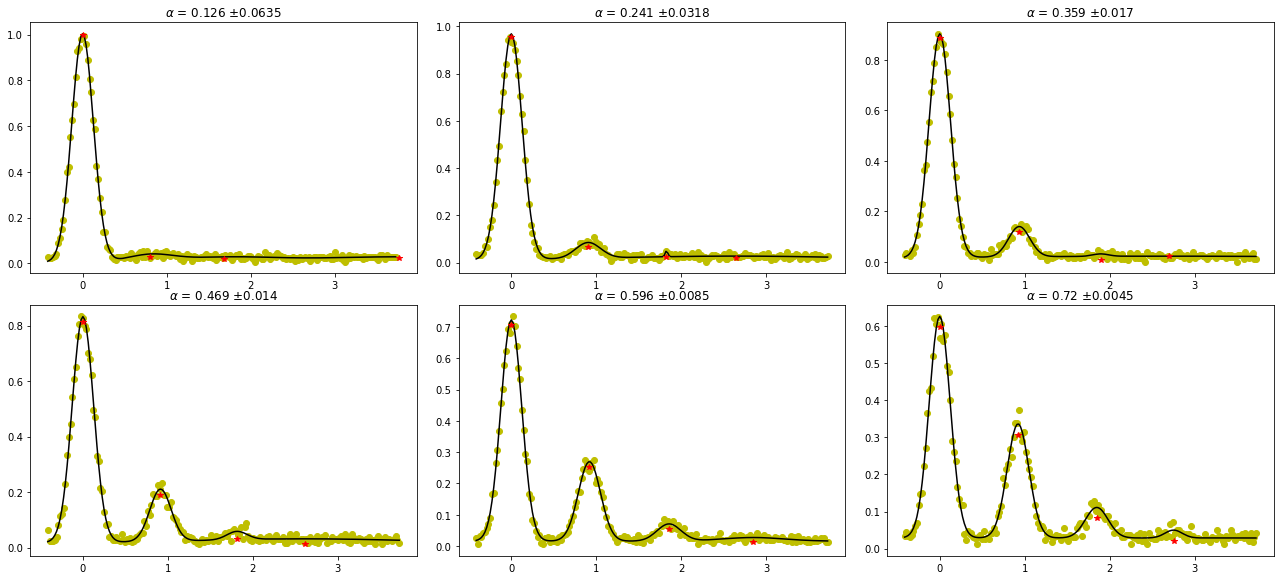

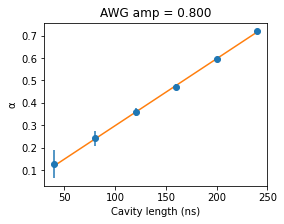

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'S:\_Data\210326 - QM_OPX\data\00018_alpha_cal_qubit_spec.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [68]:
expt_name = 'alpha_cal_qubit_spec'
filelist = np.arange(1, 18, 1)
# filelist = [1]

amps_c = []
xis_vs_amps = []

N = 4 # max photon number to fit to

two_chi = -1.209037089614708*1e6
contrast = [0.9520000000000001, 0.009000000000000001]

for ii, i in enumerate(filelist):
    filename = "S:\\_Data\\210326 - QM_OPX\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"


    with File(filename,'r') as a:

        Q = np.array(a['res'])
        amp = np.array(a['amp'])
        times = 4*np.array(a['times'])
        freqs = np.array(a['freqs'])
        a.close()

    amps_c.append(amp)

    fig, axs = plt.subplots(nrows=len(times)//3+len(times)%3, ncols=3, figsize=(18, 4*len(times)//3))
    fig.tight_layout()

    alpha = []
    alpha_err = []
    for jj in range(len(times)):
        y = (Q[jj] - contrast[1])/contrast[0]
#         y = (y-np.min(y))
#         y = y/np.max(y)

        t = times[jj]
        x = freqs/two_chi

        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0
        ax = axs[jj//3, jj%3]
        ax.plot(x, y, 'yo')

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
        
        ax.plot(x, gaussfuncsum_with_baseline(x, *p1), 'k')
        
        peak_val, freq_val = fitamp(p1)
        
#         peak_val = peak_val/np.sum(peak_val)

        a, a_err = fitcoherentstate(peak_val)
#         ax.plot(coherent_state(np.arange(len(peak_val)), a), 'g', label=r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))

        ax.plot(freq_val, peak_val,'r*')
#         ax.plot(peak_val_test,'y*')
        
        ax.set_title(r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        alpha.append(a)
        alpha_err.append(a_err)
    plt.show()
    h=0
#     if i==4:
#         h = 0
#     elif i==5:
#         h = 1
    plt.figure(figsize=(4, 3))
    plt.errorbar(x=times[h:], y=alpha[h:], yerr=alpha_err[h:], fmt='o')
    popt, pcov = curve_fit(proportional, times[h:], alpha[h:])
    xis_vs_amps.append(popt[0])
    plt.plot(times[h:], proportional(times[h:], popt))
    plt.title('AWG amp = %.3f'%amp)
    plt.xlabel('Cavity length (ns)')
    plt.ylabel('α')
    plt.show()

In [57]:
p1[2+3]

0.9225361503801415

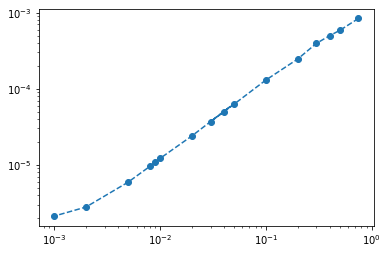

In [359]:
plt.loglog(amps_c, xis_vs_amps, 'o--')

## 2021-11-09 Square cal with binary decomp

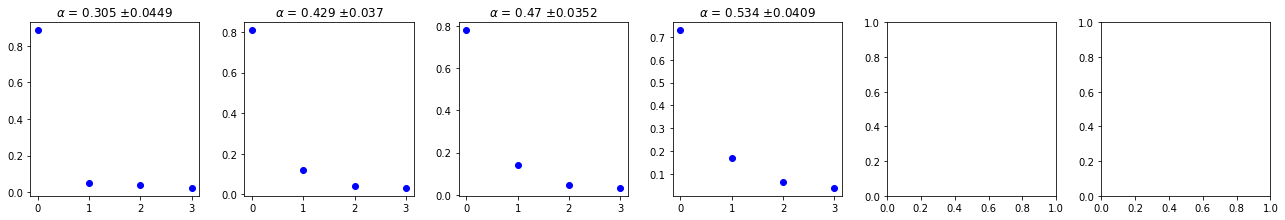

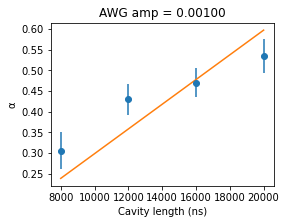

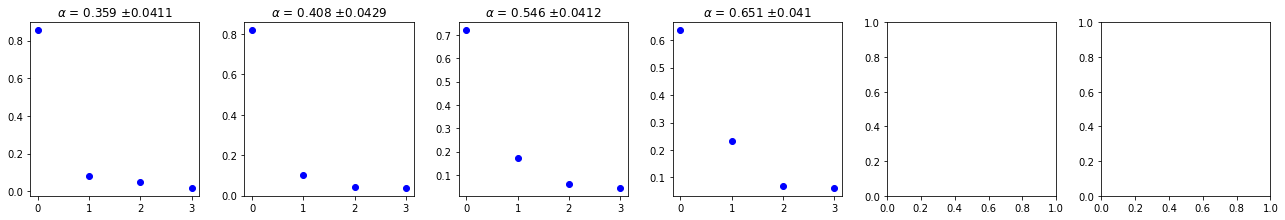

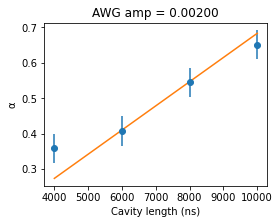

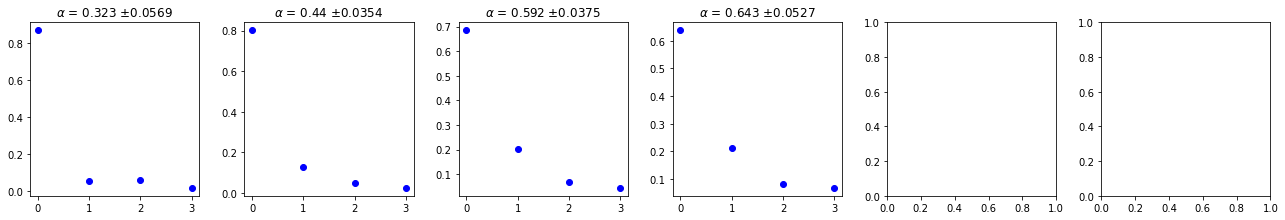

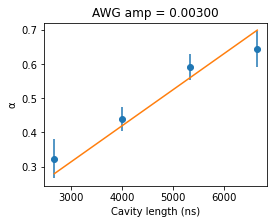

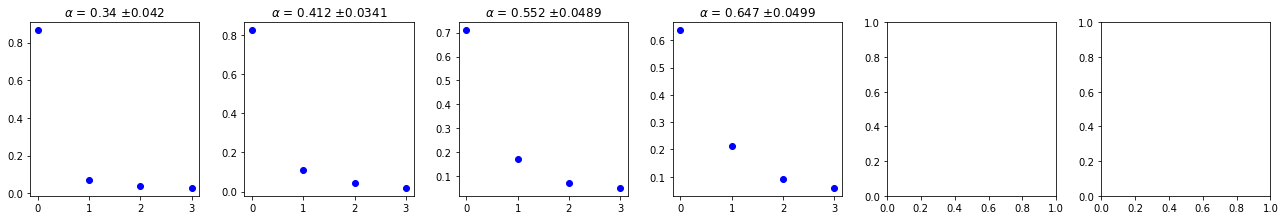

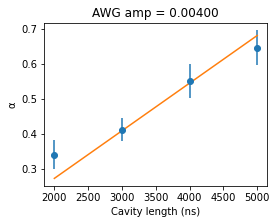

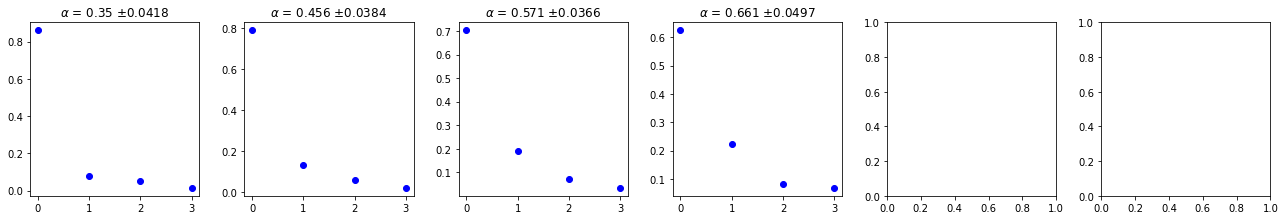

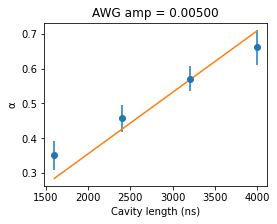

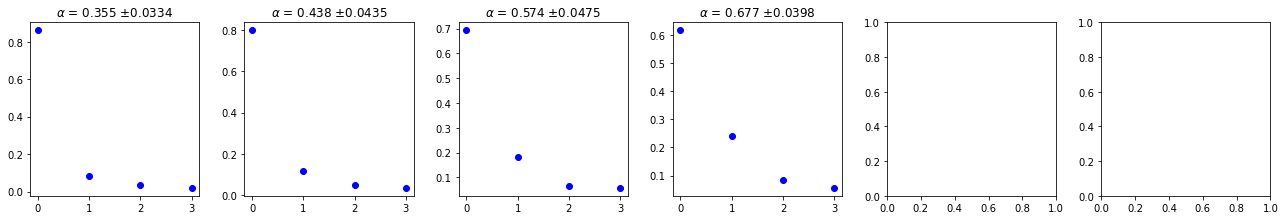

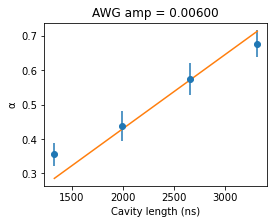

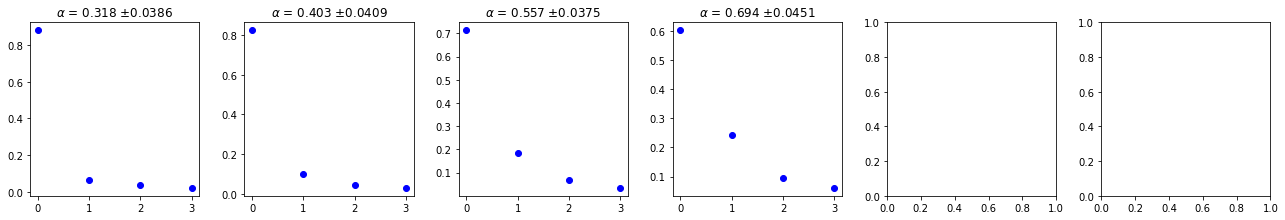

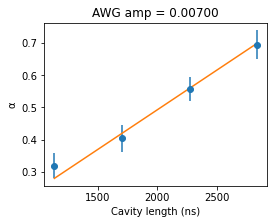

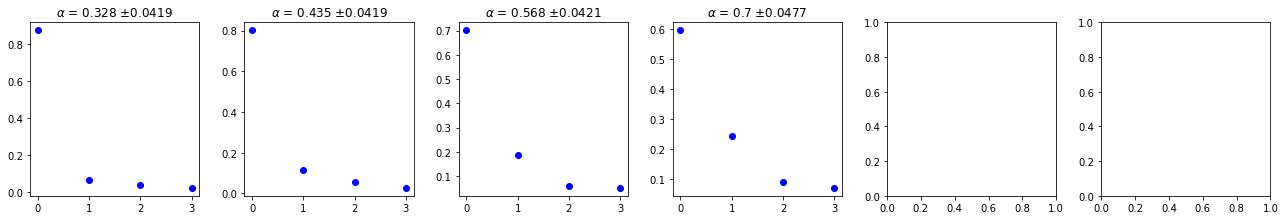

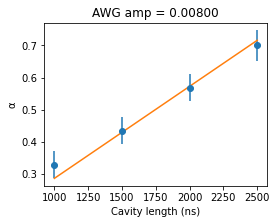

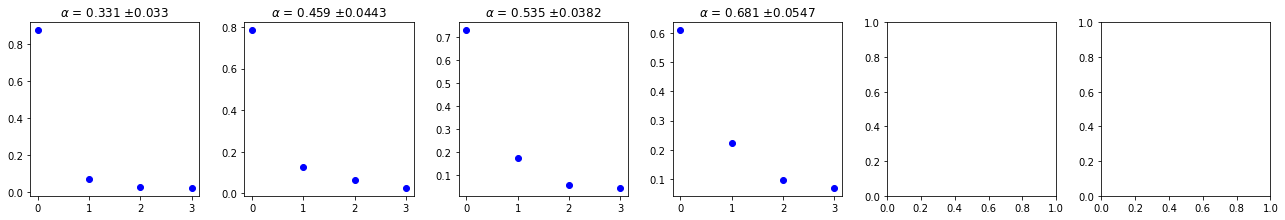

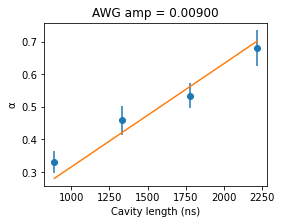

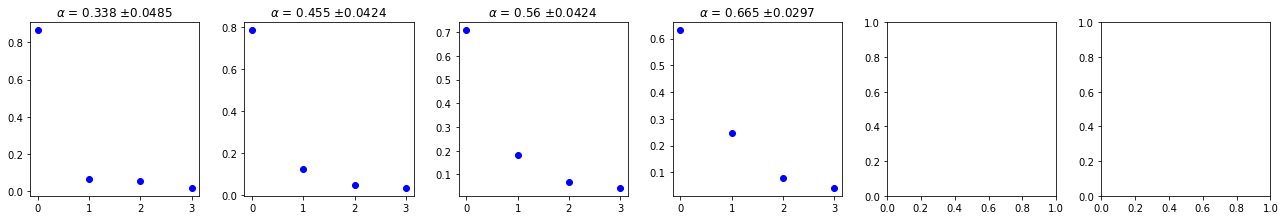

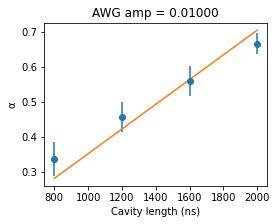

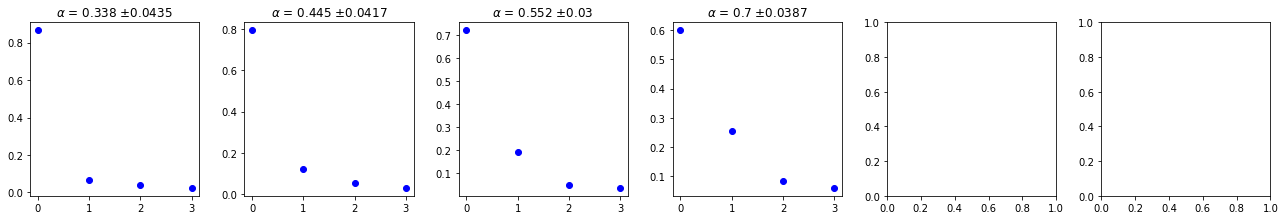

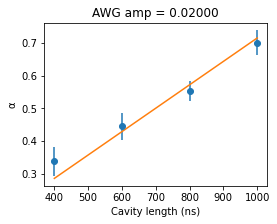

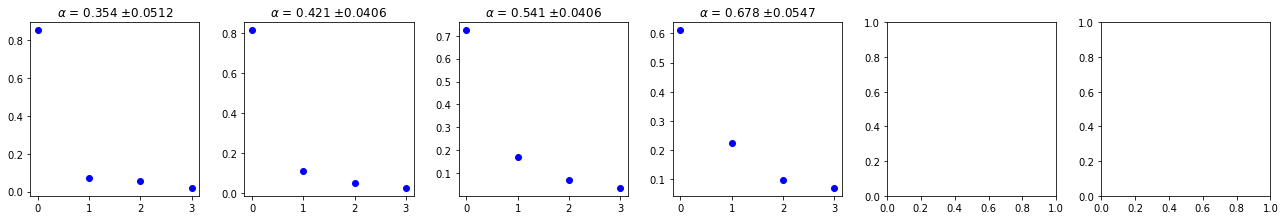

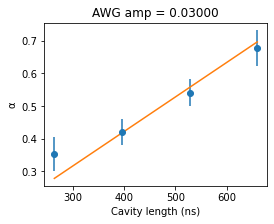

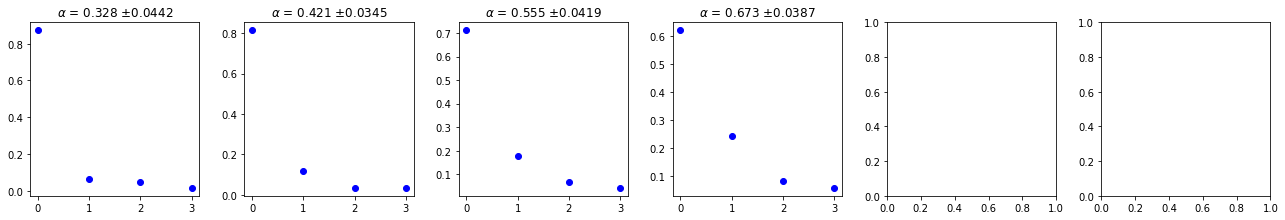

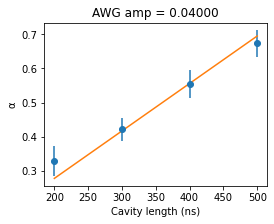

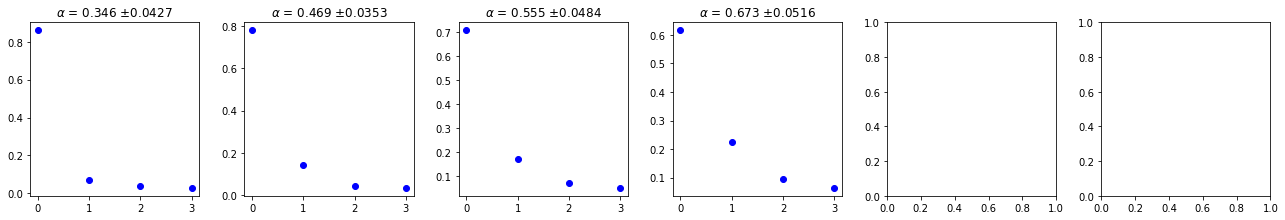

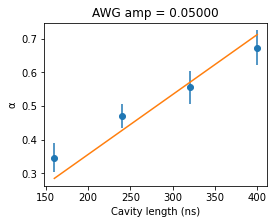

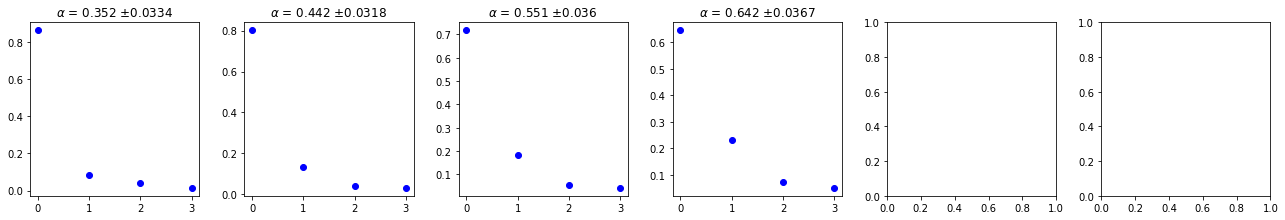

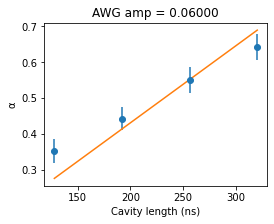

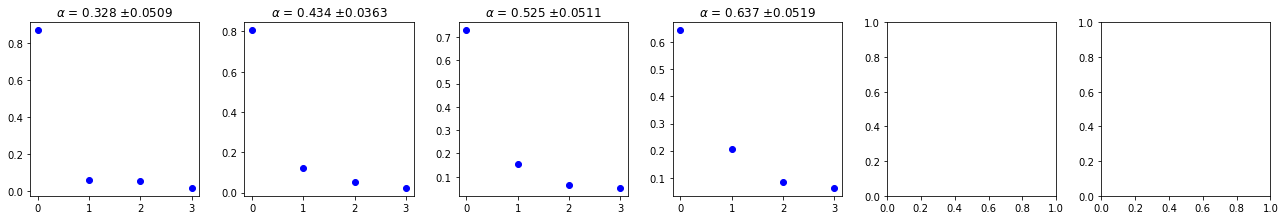

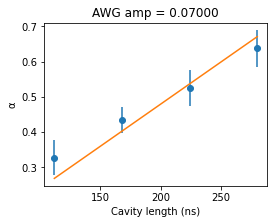

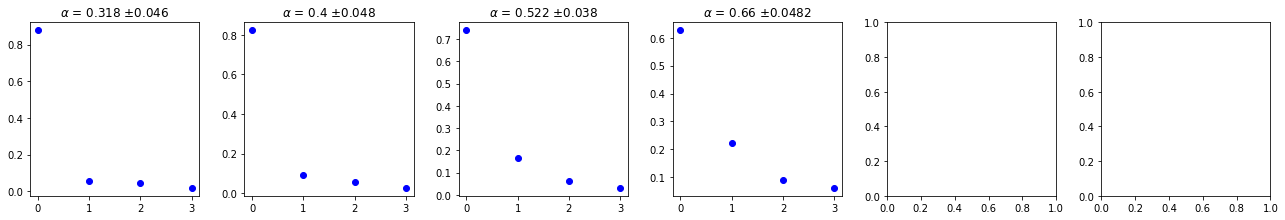

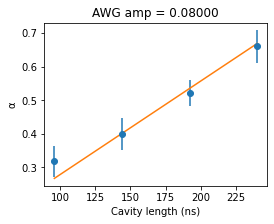

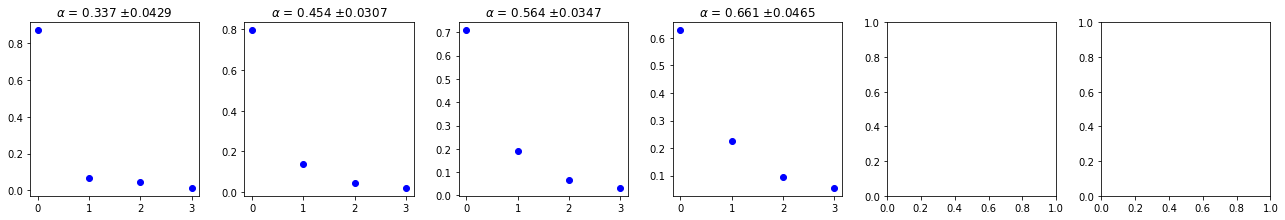

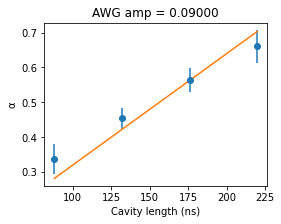

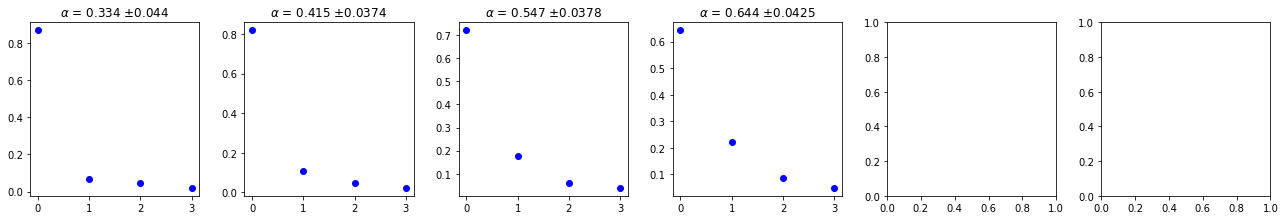

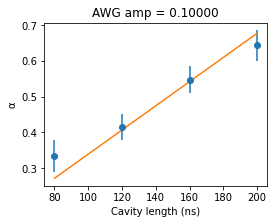

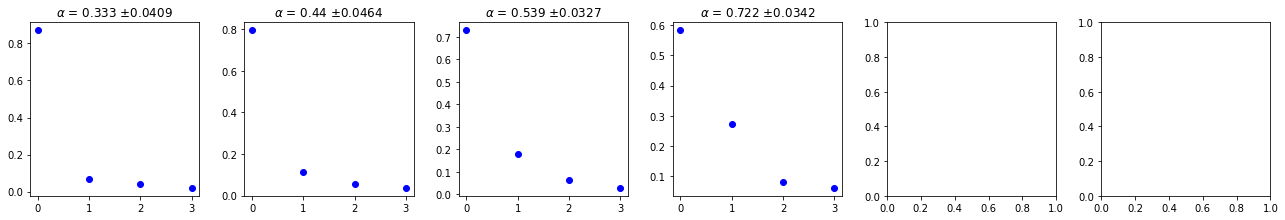

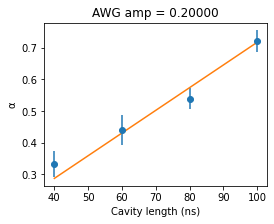

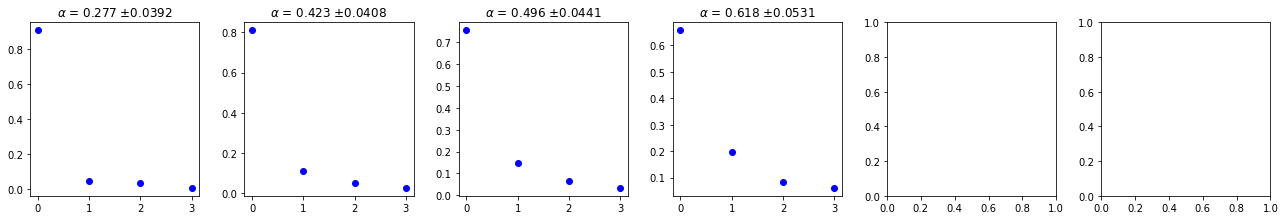

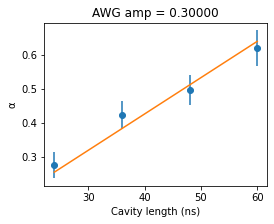

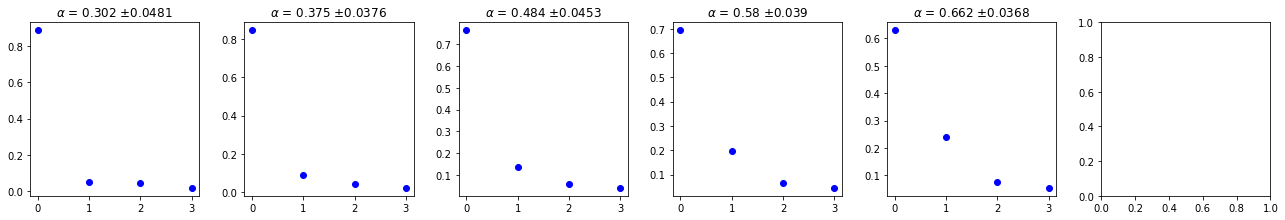

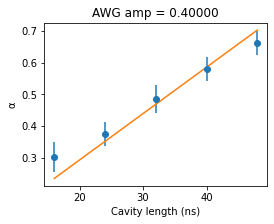

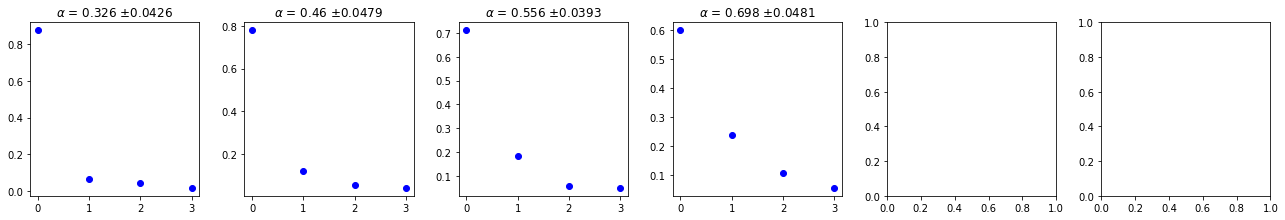

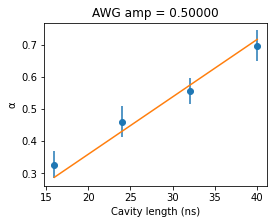

In [100]:
expt_name = 'alpha_cal_binary_decomp'
filelist = list(np.arange(0, 23, 1))
# filelist.remove(26)
# filelist.remove(25)
# filelist.remove(22)

# filelist = [30]
amps_c = []
xis_vs_amps = []

N = 5 # max photon number to fit to
# contrast = [0.9520000000000001, 0.009000000000000001]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        bit1 = np.array(a['bit1'])
        bit2 = np.array(a['bit2'])
        
        amp = np.array(a['amp'])
        times = 4*np.array(a['times'])[1:]
        avgs = int(np.array(a['avgs']))
        a.close()
        
    amps_c.append(amp)
    
    nums = pd.DataFrame(2*bit2 + 1*bit1)
    
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 3))
    fig.tight_layout()
    x = np.arange(4)

    alpha = []
    alpha_err = []
    for jj in range(len(times)):
        t = times[jj]
        num = nums[1+jj]
        p_cav = np.array([np.sum(num==0)/avgs, np.sum(num==1)/avgs, np.sum(num==2)/avgs, np.sum(num==3)/avgs])
#         print(p_cav)
        ax = axs[jj%6]
        ax.plot(x, p_cav, 'bo')

        a, a_err = fitcoherentstate(p_cav)
        ax.set_title(r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        alpha.append(a)
        alpha_err.append(a_err)
    plt.show()
    h=0
    plt.figure(figsize=(4, 3))
    plt.errorbar(x=times[h:], y=alpha[h:], yerr=alpha_err[h:], fmt='o')
    popt, pcov = curve_fit(proportional, times[h:], alpha[h:])
    xis_vs_amps.append(popt[0])
    plt.plot(times[h:], proportional(times[h:], popt))
    plt.title('AWG amp = %.5f'%amp)
    plt.xlabel('Cavity length (ns)')
    plt.ylabel('α')
    plt.show()

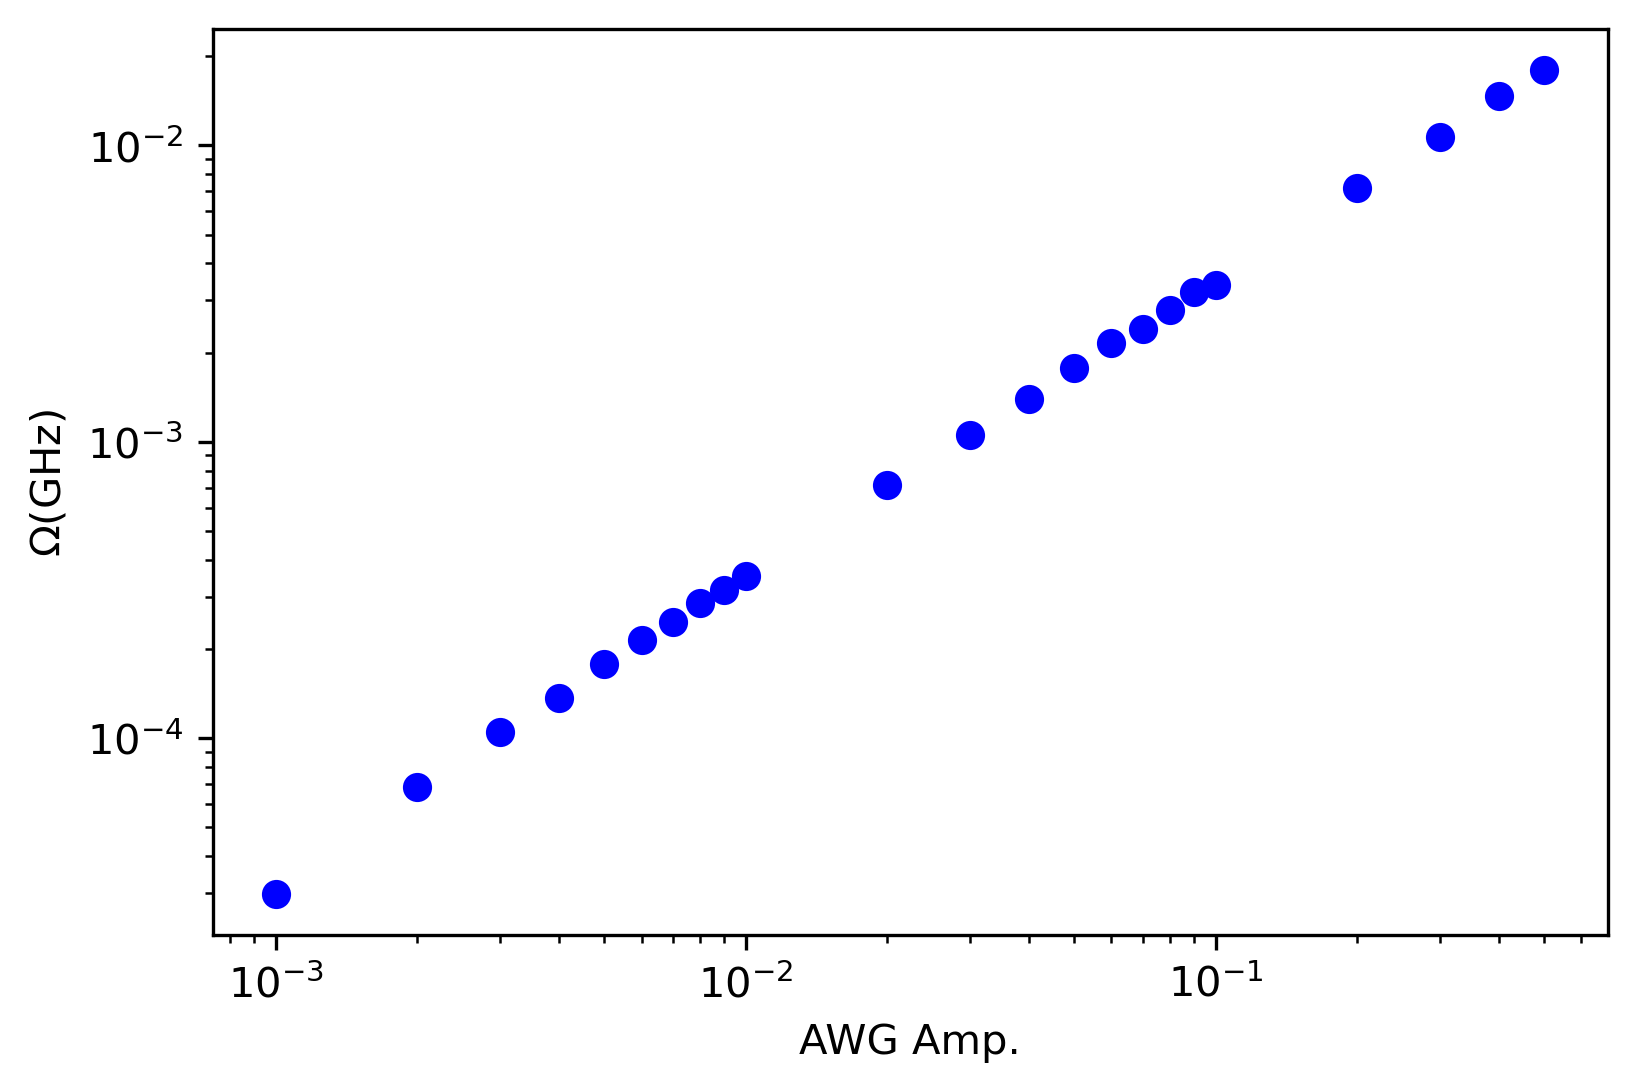

In [101]:
plt.figure(dpi=300)
plt.loglog(amps_c, xis_vs_amps, 'bo')
plt.xlabel('AWG Amp.')
plt.ylabel(r'$\mathrm{\Omega (GHz)}$')
plt.show()

In [52]:
amp

array(0.0009)

## Export

In [102]:
d = {'Amps': amps_c, 'Omegas (GHz)': xis_vs_amps}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps  Omegas (GHz)
22                   0.5      0.017925
21                   0.4      0.014631
20   0.30000000000000004      0.010647
19                   0.2      0.007175
18                   0.1      0.003388
17                  0.09      0.003197
16                  0.08      0.002787
15   0.06999999999999999      0.002396
14  0.060000000000000005      0.002153
13                  0.05      0.001779
12                  0.04      0.001390
11                  0.03      0.001055
10                  0.02      0.000715
9                   0.01      0.000352
8   0.009000000000000001      0.000316
7                  0.008      0.000286
6                  0.007      0.000246
5                  0.006      0.000215
4                  0.005      0.000177
3                  0.004      0.000136
2                  0.003      0.000105
1                  0.002      0.000068
0                  0.001      0.000030

In [21]:
d = {'Amps': amps_c, 'Omegas (GHz)': xis_vs_amps}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps  Omegas (GHz)
16                   0.8      0.002868
15    0.7000000000000001      0.002621
14                   0.6      0.002269
13                   0.5      0.001913
12                   0.4      0.001538
11   0.30000000000000004      0.001178
10                   0.2      0.000775
9                    0.1      0.000388
8                   0.09      0.000357
7                   0.08      0.000304
6    0.06999999999999999      0.000269
5   0.060000000000000005      0.000235
4                   0.05      0.000190
3                   0.04      0.000155
2                   0.03      0.000114
1                   0.02      0.000076
0                   0.01      0.000034

In [103]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'cavity_square_mode_2'
file_number = 0

pulse_type = 'square'
date = '2021_11_09'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=xis_vs_amps)
    hf.create_dataset('amps', data=amps_c)
    hf.create_dataset('date', data=date)
    hf.create_dataset('mode', data=2)

print("done")

done


In [62]:
def alpha_awg_cal(alpha, cav_amp=0.5):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity

    fn_file = '..\drive_calibration\00000_2021_7_14_cavity_square.h5'

    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)

    o_s = omegas
    a_s = amps

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

    omega_desired = transfer_fn(cav_amp)

    pulse_length = (alpha/omega_desired)

    return pulse_length


In [61]:
path = os.getcwd()
cal_path = 'C:\_Lib\python\slab\experiments\qm_opx\drive_calibration'
alpha_awg_cal(-0.58, cav_amp=0.4)//4

PermissionError: [Errno 13] Unable to open file (unable to open file: name = '..\drive_calibration', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

In [55]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'cavity_square'
file_number = 0

pulse_type = 'square'
date = '2021_7_14'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=xis_vs_amps)
    hf.create_dataset('amps', data=amps_c)
    hf.create_dataset('date', data=date)

print("done")

done


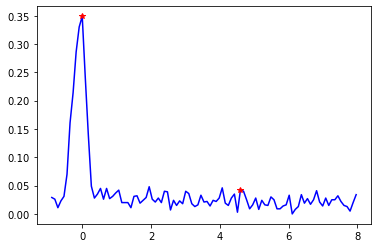

In [362]:
from scipy.signal import find_peaks
plt.plot(x, y, 'b')

p = np.mean(y)

peaks, _ = find_peaks(y, prominence=p)
plt.plot(x[peaks], y[peaks], 'r*')

# Qubit Square calibration

(16, 51)


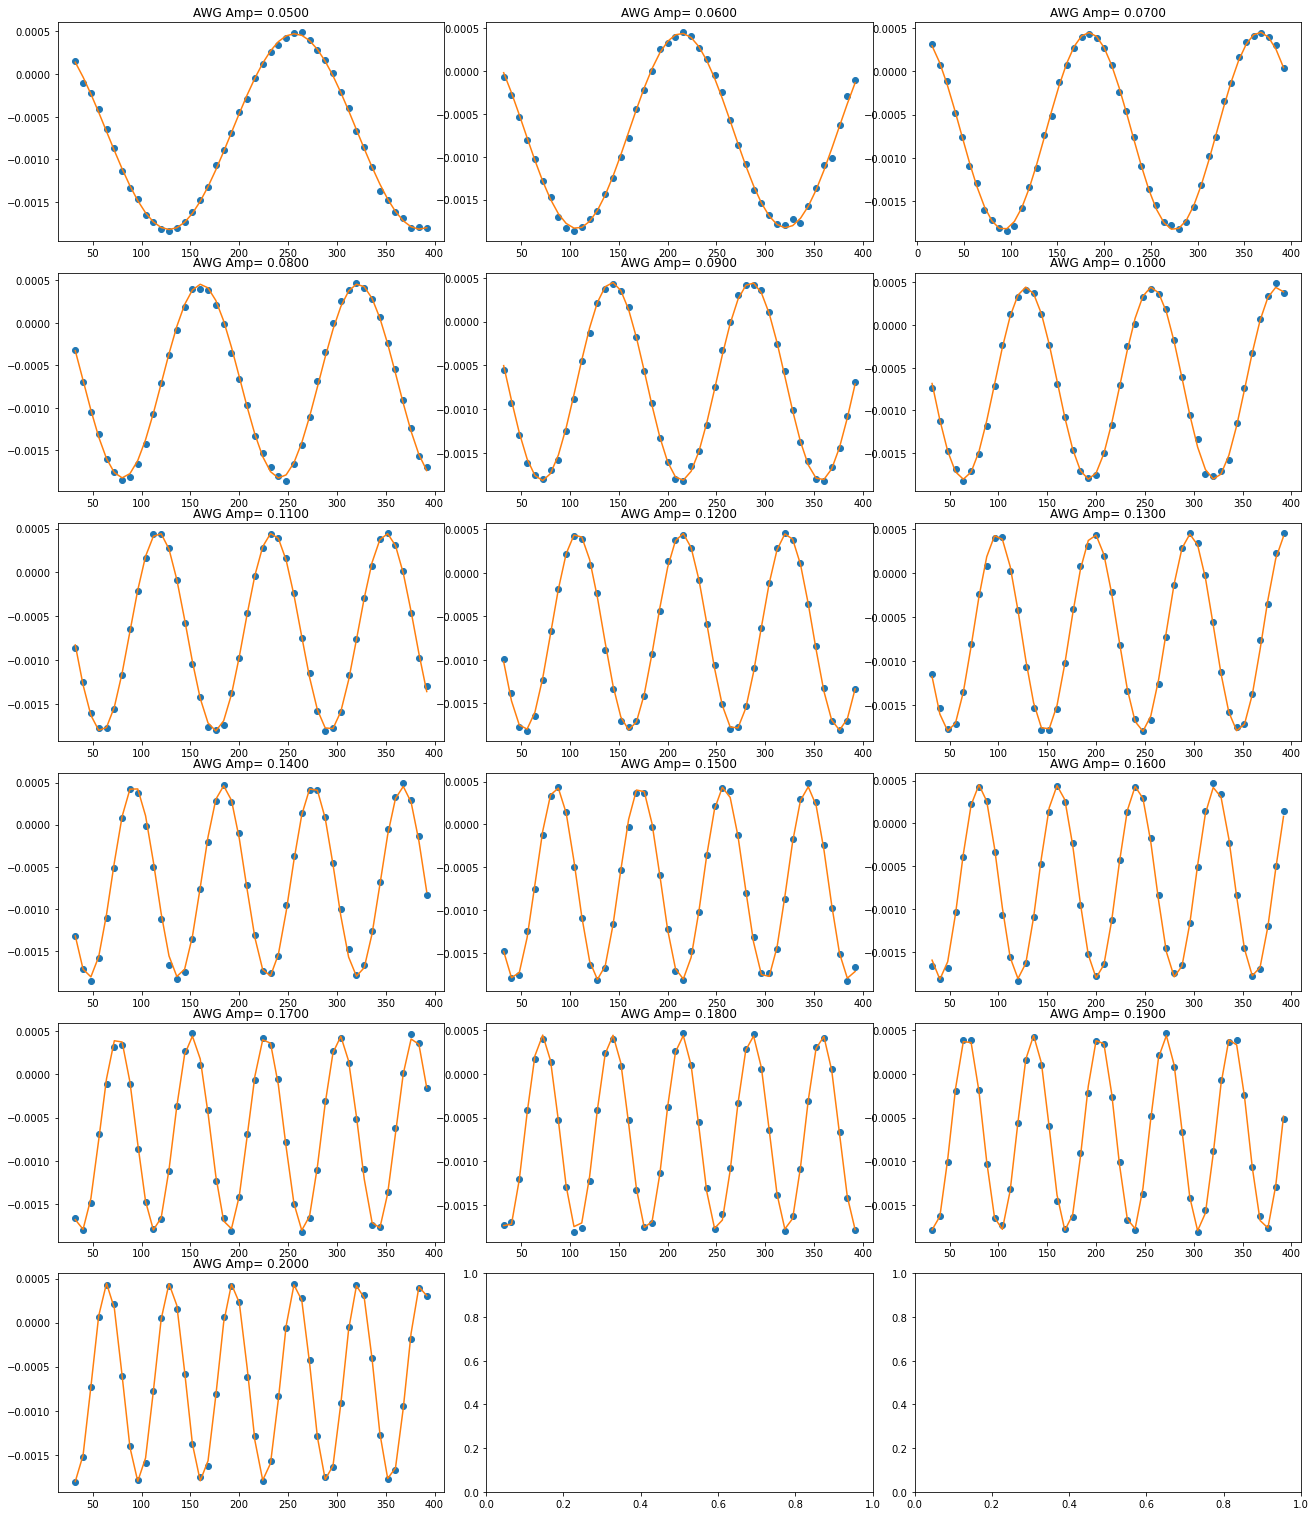

(21, 51)


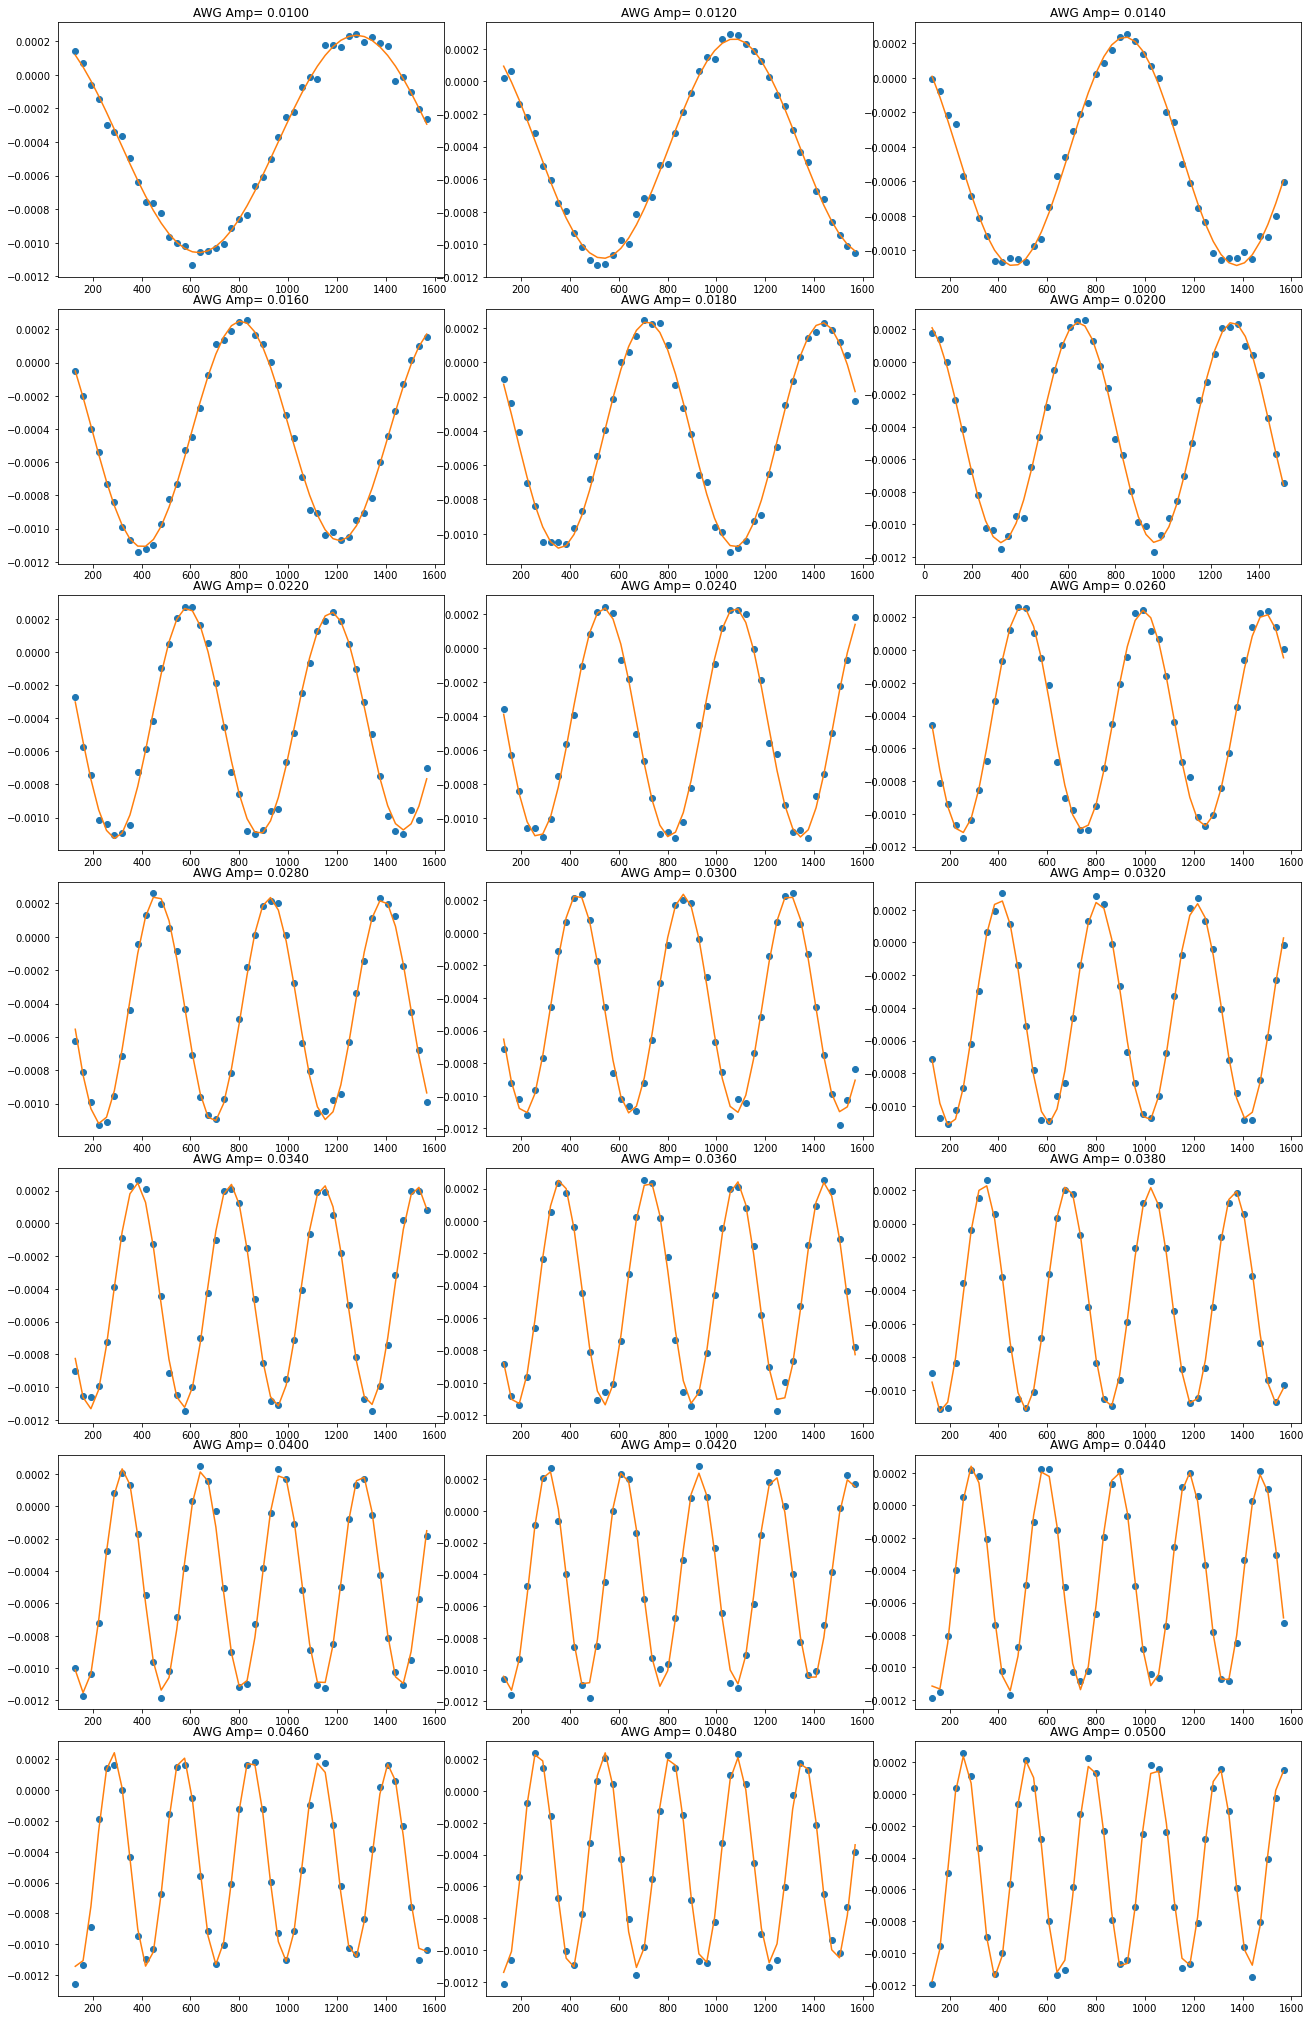

(19, 101)


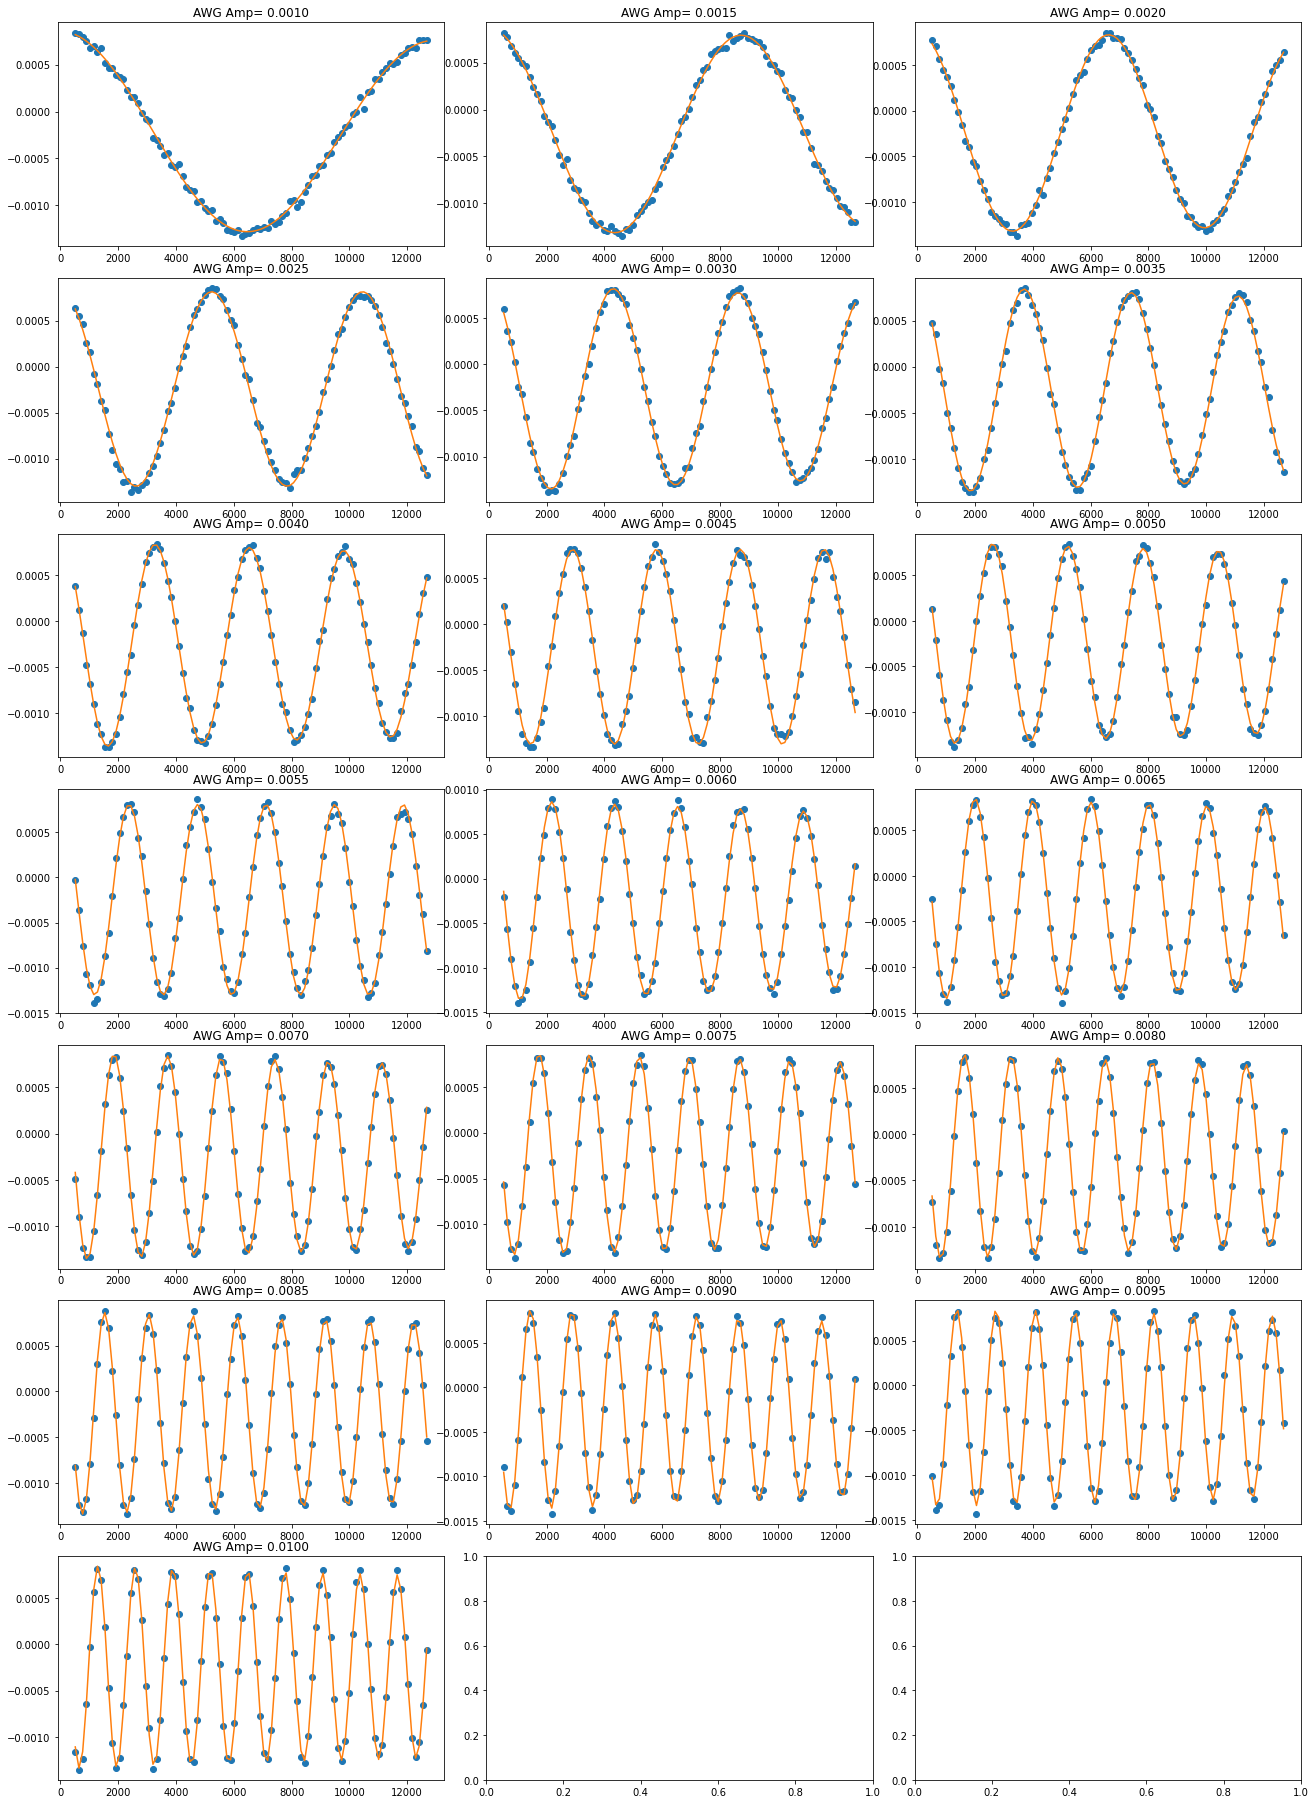

(19, 101)


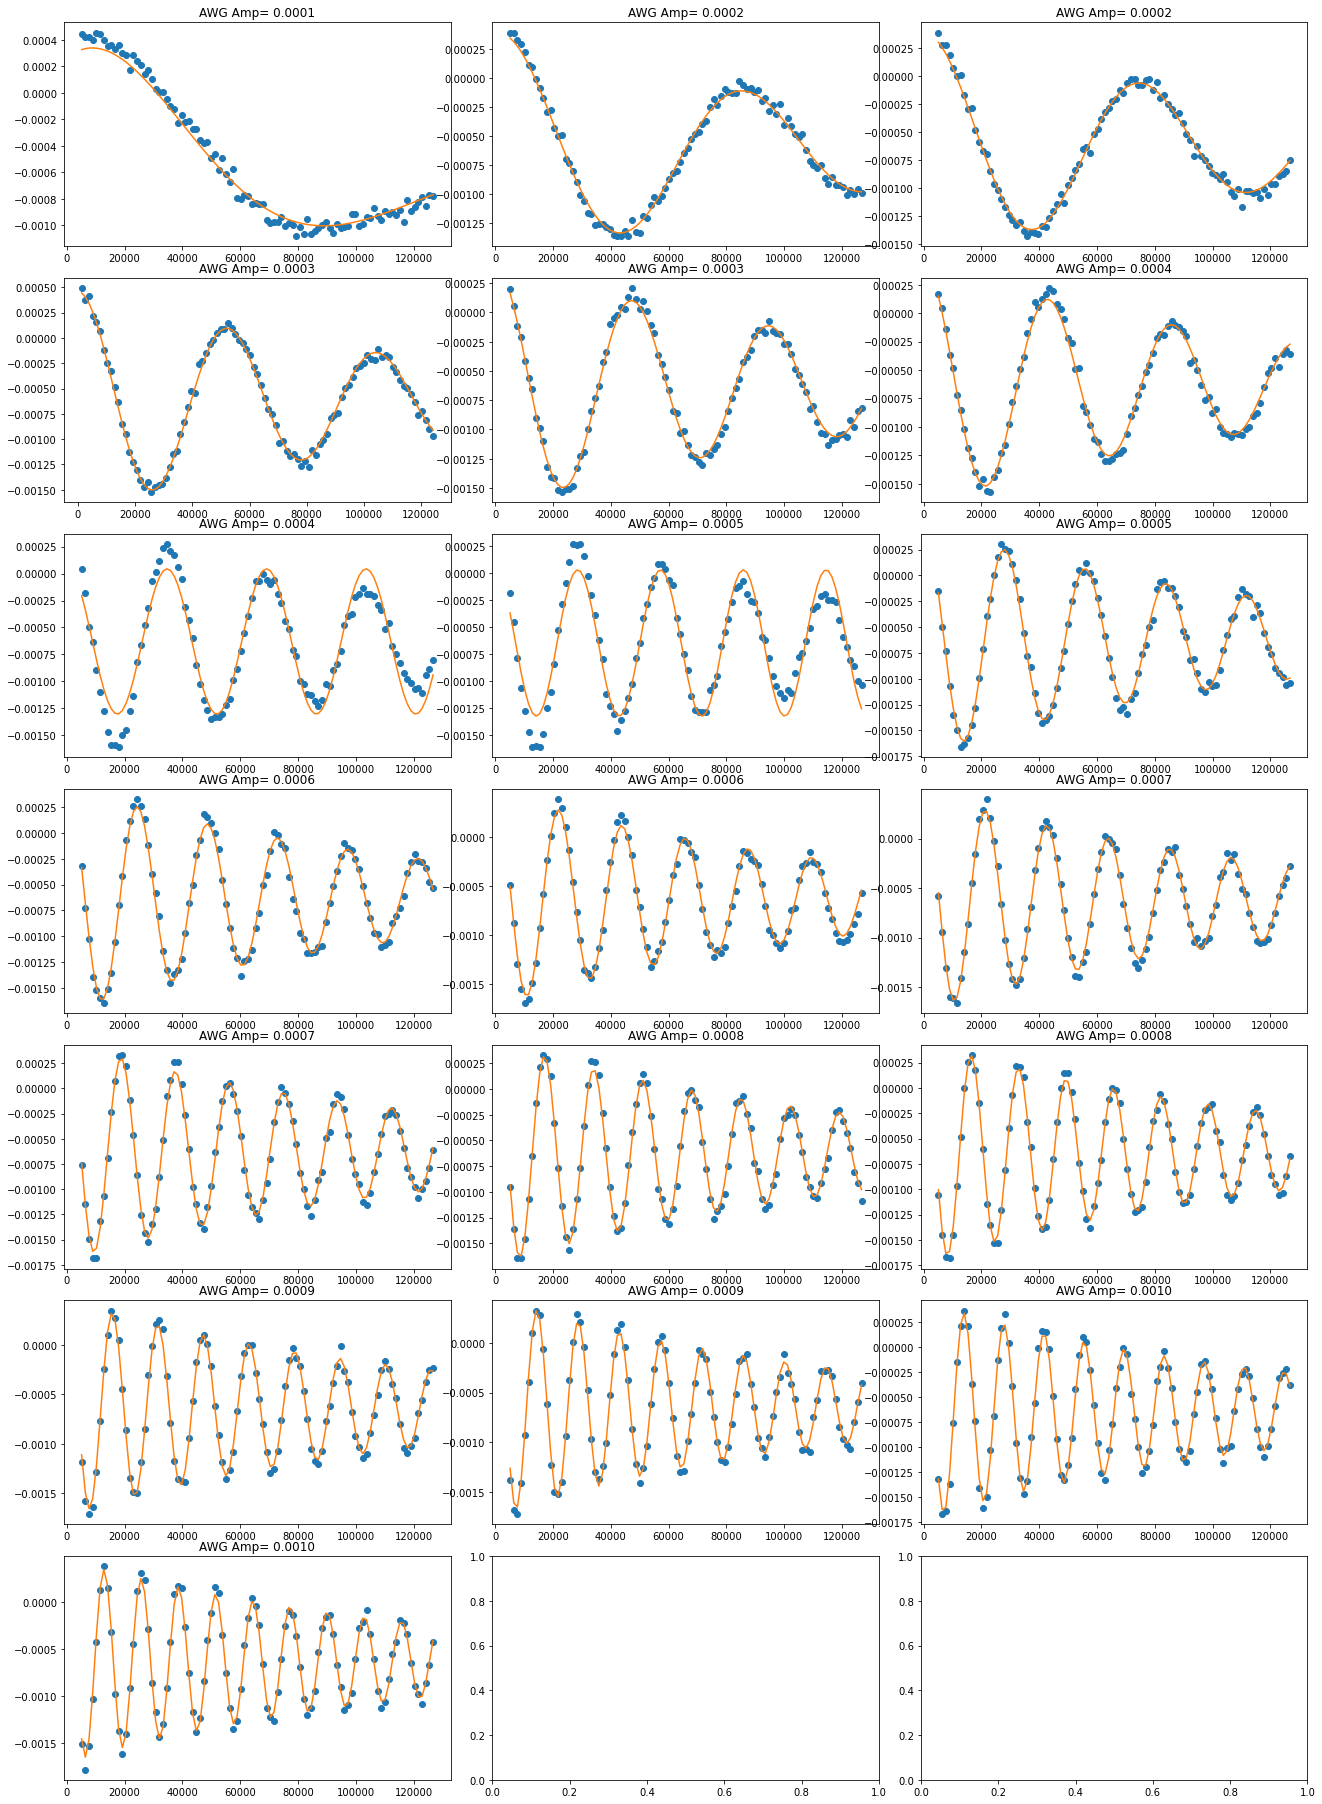

In [58]:
expt_name = 'qubit_square_cal'
filelist = [5, 6, 7, 8]
scs = []
scs_err = []
amps_q = []
xis_vs_amps = []
data_path = "S:\_Data\\210326 - QM_OPX\\data\\"
rabi_freqs = []

for ii, i in enumerate(filelist):
    
    filename = data_path+ str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:

        I = np.array(a['I'])
        Q = np.array(a['Q'])
        amp = np.array(a['amps'])
        times = np.array(a['times'])*1e3
        print(np.shape(I))
        a.close()
    amps_q.extend(amp)
    fig, axs = plt.subplots(nrows=len(amp)//3+len(amp)%3, ncols=3, figsize=(18, 4*len(amp)//3))
    fig.tight_layout()
    for jj in range(len(amp)):
        ax = axs[jj//3, jj%3]
        l = -1

        if i==5 and jj==2:
            k=2
        elif i==6 and jj==4 or 5 or 12:
            k = 4
        elif i==6 and jj==8 :
            k = 2
            l = -2
        else:
            k = 2

        if i==6 and jj==5 :

            k = 1
            l = -3
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=p, showfit=False)
        elif i==8 and jj==3 :

            k = 1
            l = -3
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=p, showfit=False)
            
            
        else:
            
            t = times[k:l]
            y = I[jj][k:l]

            p = fitdecaysin(t, y, fitparams=None, showfit=False)
            
        ax.plot(t, y, 'o')
        ax.plot(t, decaysin(np.append(p, 0), t[:]))
        ax.set_title('AWG Amp= %.4f'%(amp[jj]))
        
        rabi_freqs.append(abs(p[1]))
    plt.show()

In [362]:
len(amp)//3+len(amp)%3-1

6

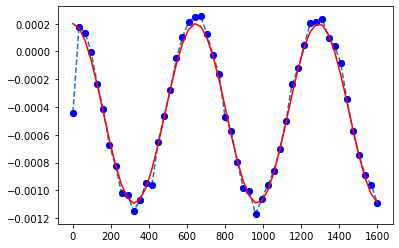

In [381]:
plt.plot(times, I[5], 'o--')
p = fitdecaysin(times, I[5], showfit=True)

In [75]:
filelist = np.arange(54, 64, 1)
print(filelist)
filelist = np.delete(filelist, -2)
print(filelist)

[54 55 56 57 58 59 60 61 62 63]
[54 55 56 57 58 59 60 61 63]


In [73]:
filelist = np.arange(83, 108, 1)
filelist = np.delete(filelist, -5)

## Latest calibration

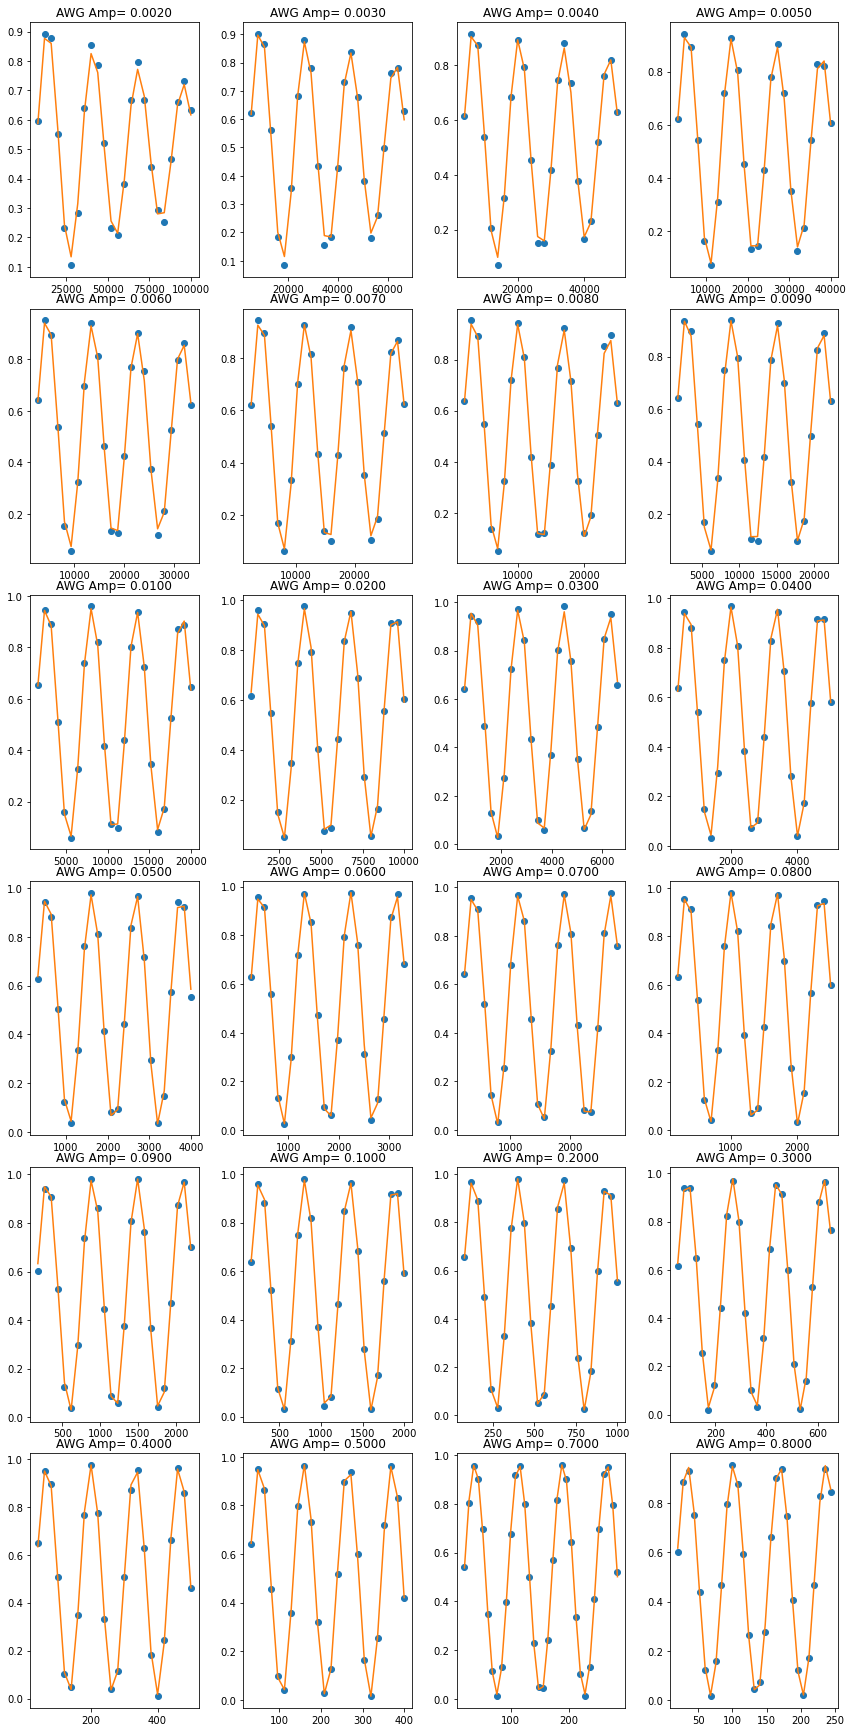

In [77]:
expt_name = 'qubit_square_cal'
filelist = np.arange(83, 108, 1)
filelist = np.delete(filelist, -3)
# filelist = [54, 55, 56]
scs = []
scs_err = []
amps_q = []
xis_vs_amps = []
data_path = "S:\_Data\\210326 - QM_OPX\\data\\"
rabi_freqs = []

pi_cal = [0.9570000000000001, 0.0025]

fig, axs = plt.subplots(nrows = len(filelist)//4 + len(filelist)%4 , ncols = 4, figsize=(12, 4*len(filelist)//4))
fig.tight_layout()

for ii, i in enumerate(filelist):
    
    filename = data_path+ str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])
        Q = np.array(a['Q'])
        amp = np.array(a['amps'])
        times = np.array(a['times'])*1e3
        a.close()
    amps_q.append(amp)

    ax = axs[ii//4, ii%4]
    t = times
    y = Q
    p = fitdecaysin(t, y, fitparams=None, showfit=False)

    ax.plot(t, y, 'o')
    ax.plot(t, decaysin(np.append(p, 0), t))
    ax.set_title('AWG Amp= %.4f'%(amp))

    rabi_freqs.append(abs(p[1]))
plt.show()

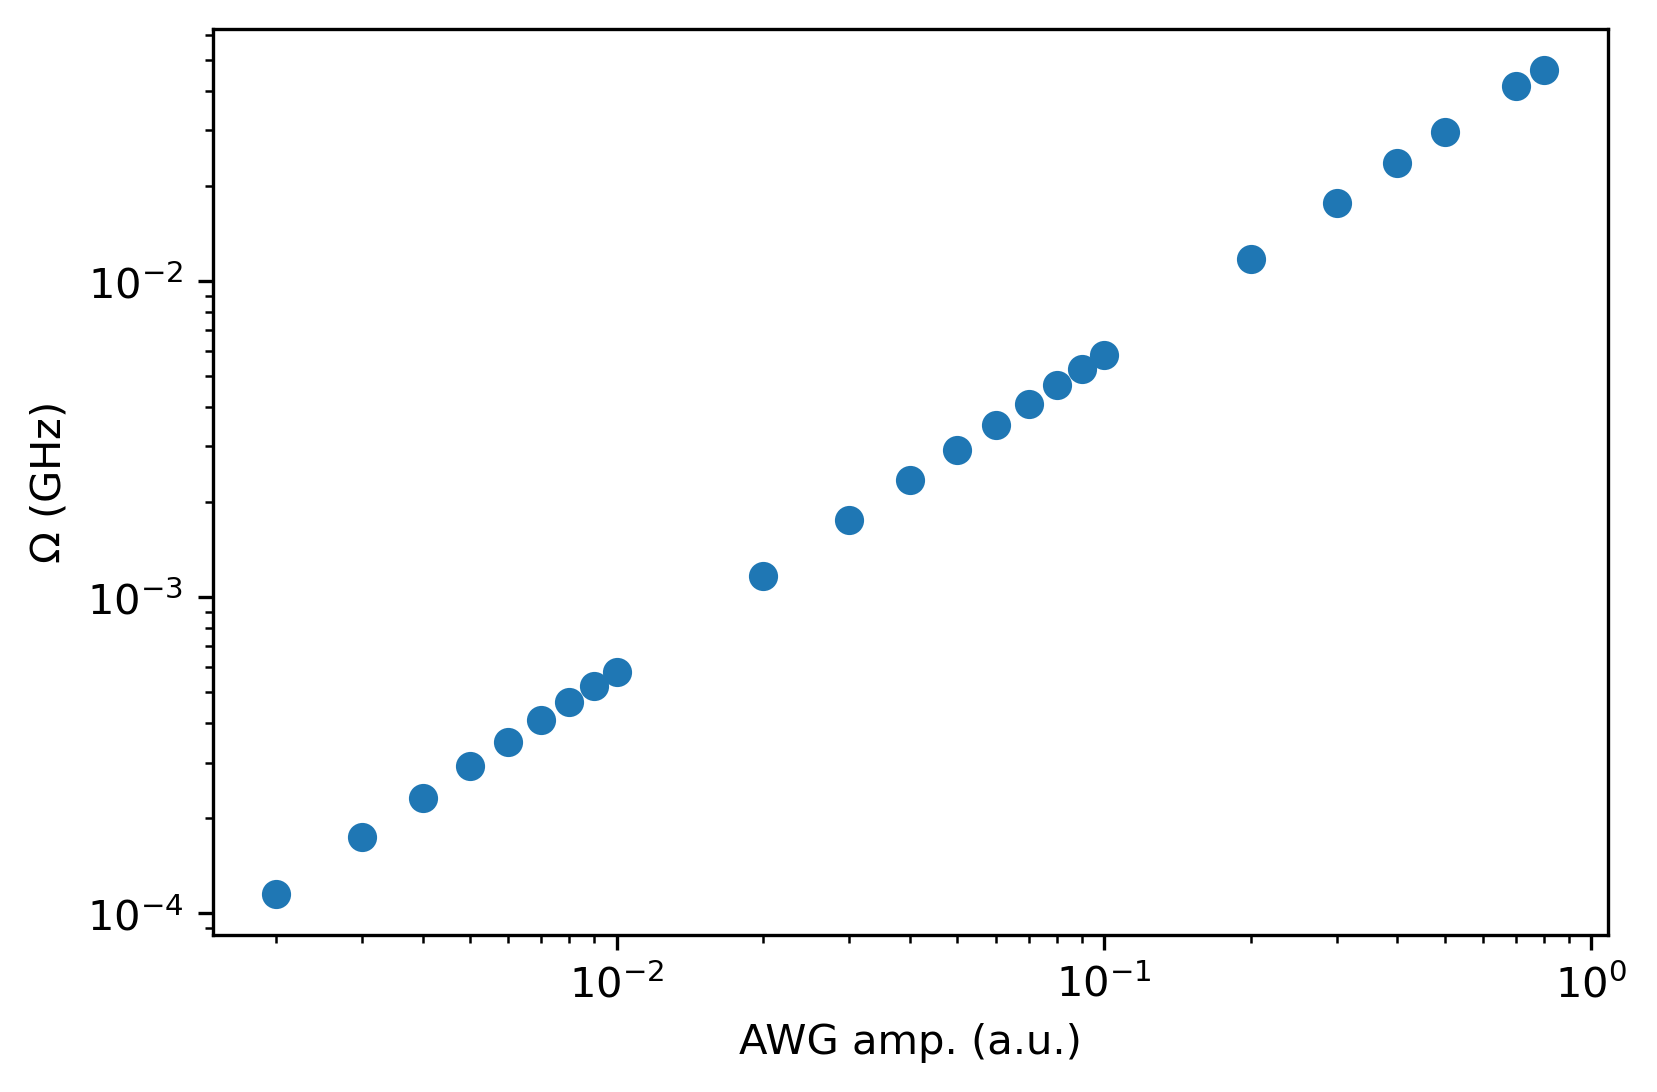

In [78]:
plt.figure(dpi=300)
omega = np.pi*np.array(rabi_freqs)
plt.loglog(amps_q, omega, 'o')
plt.xlabel('AWG amp. (a.u.)')
plt.ylabel(r'$\Omega$ (GHz)')
plt.show()

In [79]:
d = {'Amps': amps_q, 'Omegas': omega}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps    Omegas
23                   0.8  0.046418
22    0.7000000000000001  0.041421
21                   0.5  0.029628
20                   0.4  0.023661
19   0.30000000000000004  0.017637
18                   0.2  0.011706
17                   0.1  0.005844
16                  0.09  0.005262
15                  0.08  0.004678
14   0.06999999999999999  0.004096
13  0.060000000000000005  0.003514
12                  0.05  0.002924
11                  0.04  0.002342
10                  0.03  0.001754
9                   0.02  0.001169
8                   0.01  0.000580
7   0.009000000000000001  0.000523
6                  0.008  0.000465
5                  0.007  0.000408
4                  0.006  0.000349
3                  0.005  0.000292
2                  0.004  0.000232
1                  0.003  0.000174
0                  0.002  0.000115

In [80]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'qubit_square'
file_number = 0

pulse_type = 'square'
date = '2021_08_14'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=omega)
    hf.create_dataset('amps', data=amps_q)
    hf.create_dataset('date', data=date)

print("done")

done


Text(0, 0.5, 'OPX Amp.')

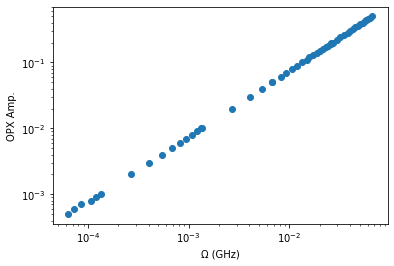

In [126]:
plt.loglog(omega, amps_q, 'o')
plt.xlabel('Ω (GHz)')
plt.ylabel('OPX Amp.')

## Calibration after moving amp to after combiner (05/19)

(31, 21)


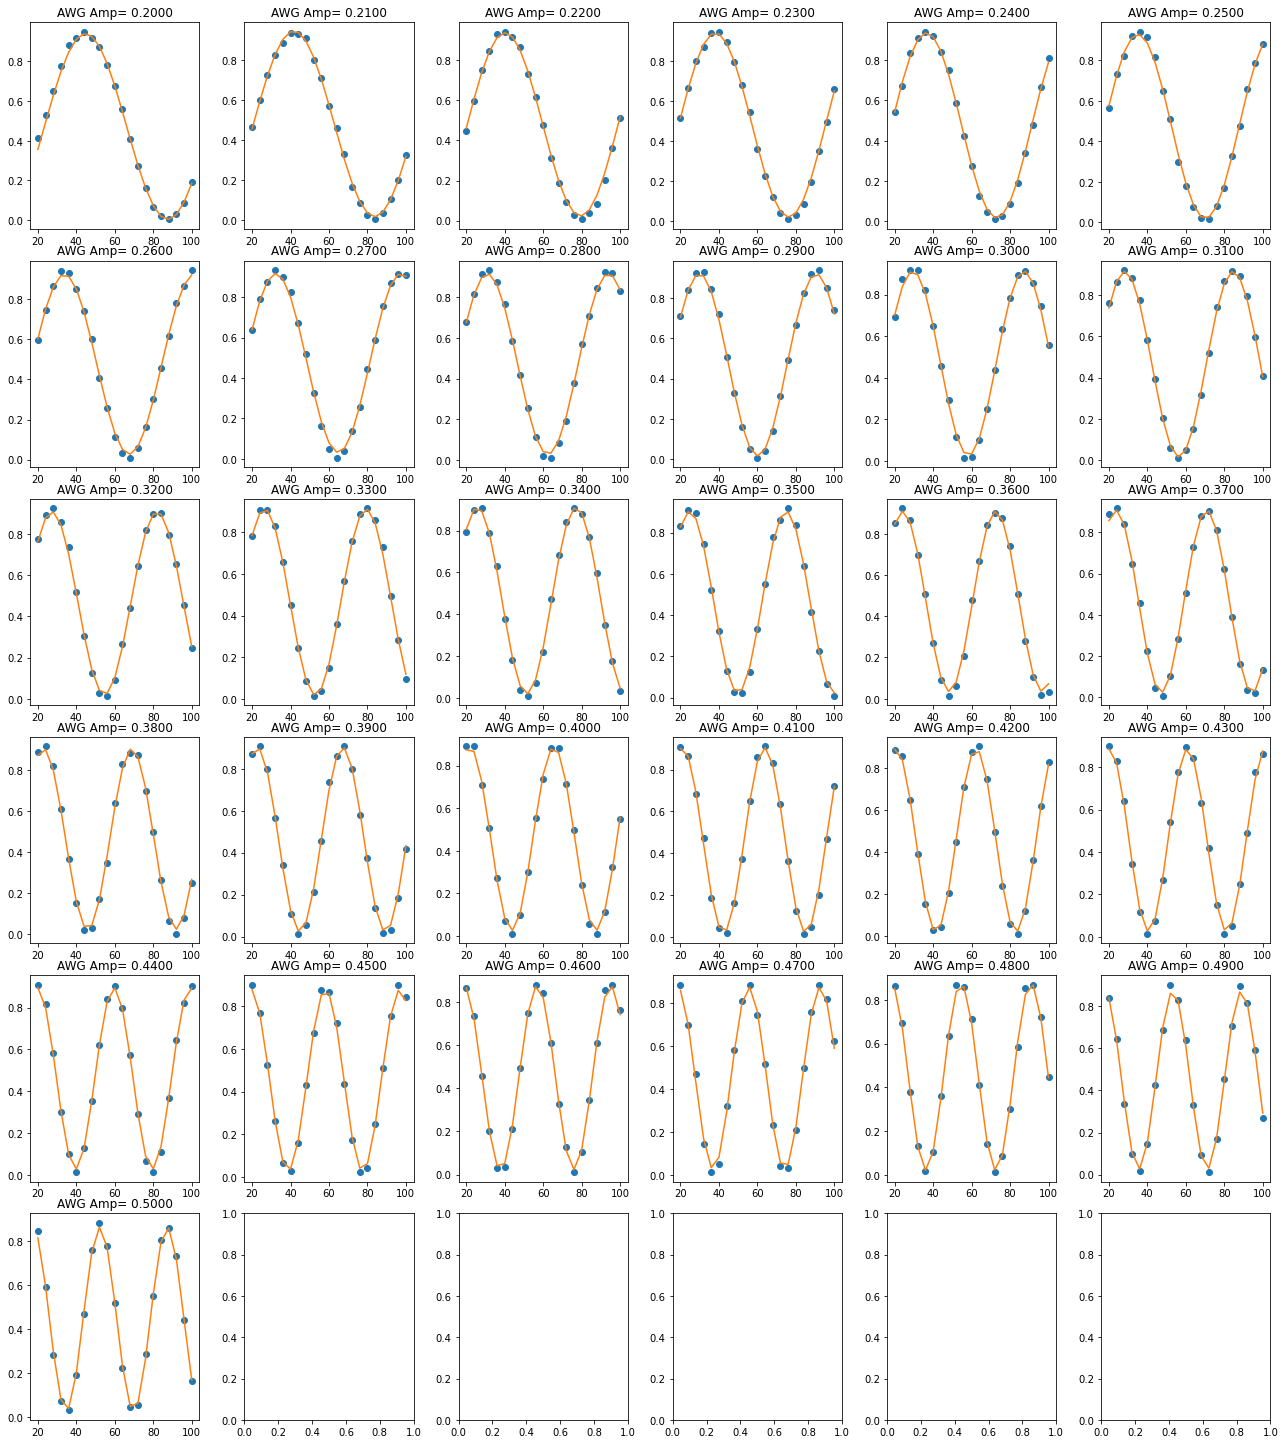

(12, 41)


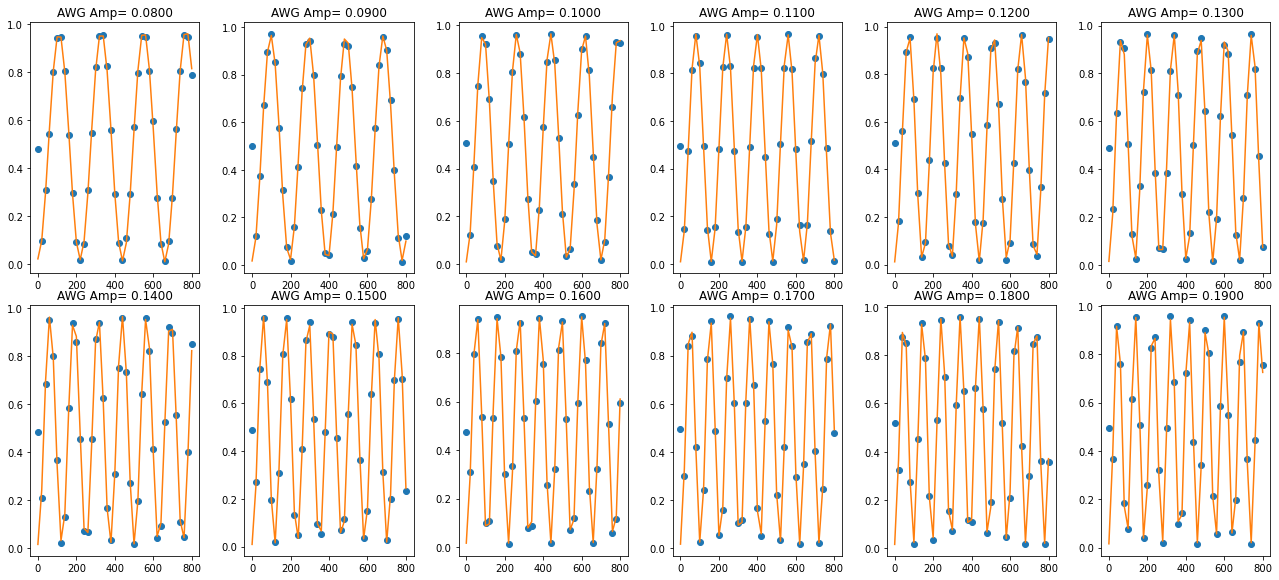

(6, 41)


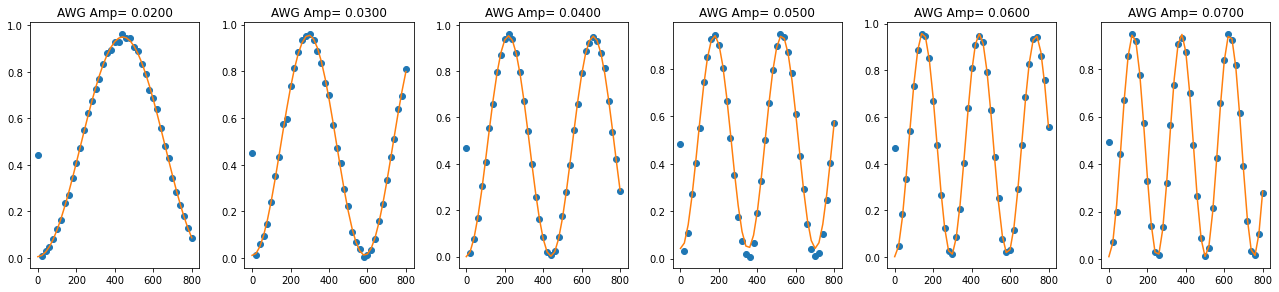

(6, 51)


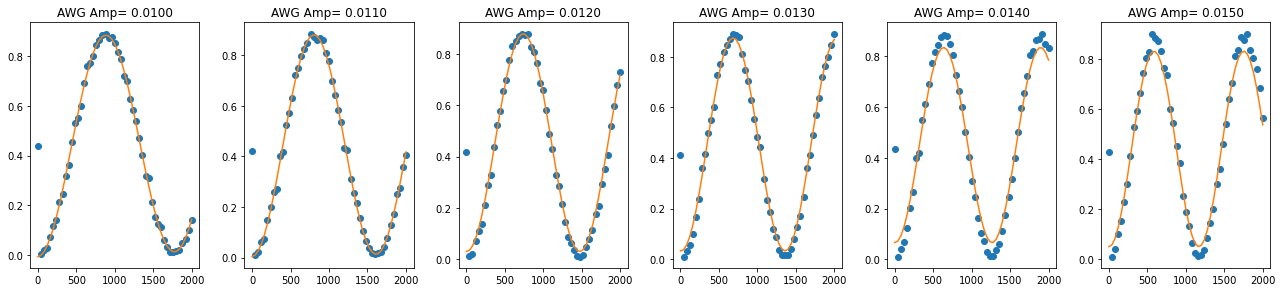

(6, 21)


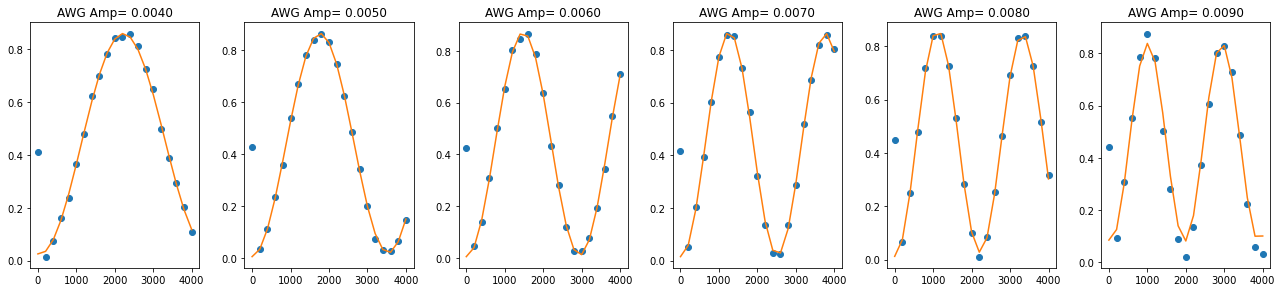

(12, 21)


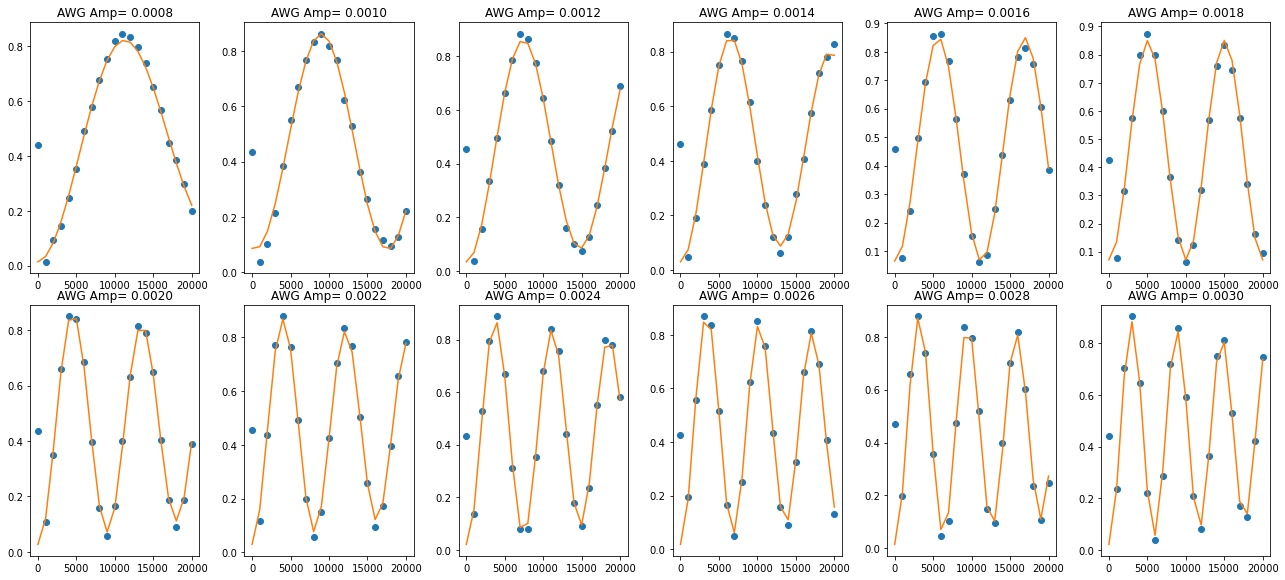

In [4]:
expt_name = 'qubit_square_cal'
filelist = [32, 45, 49, 50, 51, 52]
scs = []
scs_err = []
amps_q = []
xis_vs_amps = []
data_path = "S:\_Data\\210326 - QM_OPX\\data\\"
rabi_freqs = []

pi_cal = [0.9385, 0.016]

for ii, i in enumerate(filelist):
    
    filename = data_path+ str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])
        Q = np.array(a['Q'])
        amp = np.array(a['amps'])
        times = np.array(a['times'])*1e3
        print(np.shape(I))
        a.close()
    amps_q.extend(amp)
    fig, axs = plt.subplots(nrows=len(amp)//6+len(amp)%6, ncols=6, figsize=(18, 4*len(amp)//6))
    fig.tight_layout()

    for jj in range(len(amp)):
        if i==49 or i==50 or i==51:
            ax = axs[jj%6]
        else:
            ax = axs[jj//6, jj%6]            
        t = times[:]
#         y = (Q[jj][:] - pi_cal[1])/pi_cal[0]
        y = Q[jj][:]
        if i==32 and jj ==0:
            p = fitdecaysin(t[6:], y[6:], fitparams=None, showfit=False)
        elif i==45 :
            p = fitdecaysin(t[2:-3], y[2:-3], fitparams=None, showfit=False)
        elif i==49 and jj!=3:
            p = fitdecaysin(t[2:], y[2:], fitparams=None, showfit=False)
        elif i==49 and jj==3:
            p = fitdecaysin(t[:-3], y[:-3], fitparams=None, showfit=False)
        elif i==50 and jj==0 :
            p = fitdecaysin(t[3:], y[3:], fitparams=None, showfit=False)            
        elif i==50 and jj==1 :
            p = fitdecaysin(t[2:], y[2:], fitparams=None, showfit=False)            
        elif i==51 and jj!=5:
            p = fitdecaysin(t[2:], y[2:], fitparams=None, showfit=False)            
        elif i==51 and jj==5:
            p = fitdecaysin(t[:], y[:], fitparams=p, showfit=False)            

        elif i==52 and jj==1 or jj==5:
            p = fitdecaysin(t[2:], y[2:], fitparams=p, showfit=False)            
        elif i==52 and jj==6:
            p = fitdecaysin(t[2:], y[2:], fitparams=None, showfit=False)            
        elif i==52:
            p = fitdecaysin(t[3:], y[3:], fitparams=None, showfit=False)            
        else:
            p = fitdecaysin(t, y, fitparams=p, showfit=False)
            
        ax.plot(t, y, 'o')
        ax.plot(t, decaysin(np.append(p, 0), t))
        ax.set_title('AWG Amp= %.4f'%(amp[jj]))
        
        rabi_freqs.append(abs(p[1]))
    plt.show()

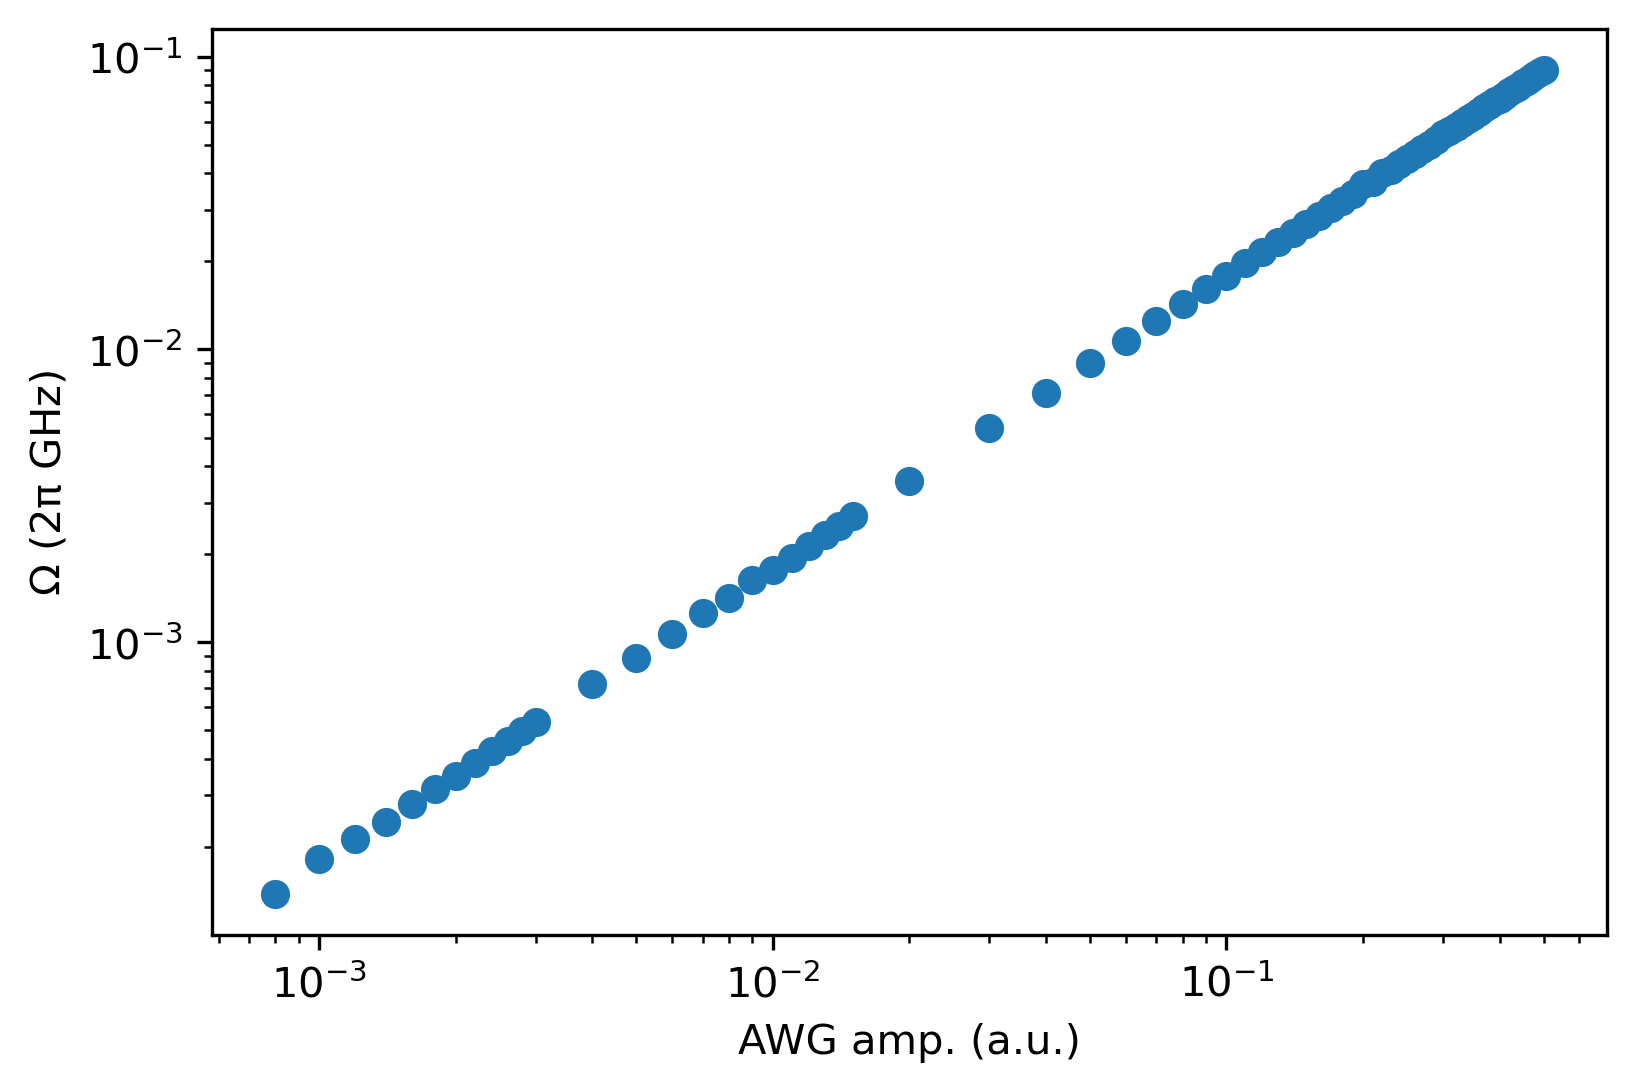

In [5]:
plt.figure(dpi=300)
omega = np.pi*np.array(rabi_freqs)
plt.loglog(amps_q, omega, 'o')
plt.xlabel('AWG amp. (a.u.)')
plt.ylabel(r'$\Omega$ (2π GHz)')
plt.show()

In [6]:
d = {'Amps': amps_q, 'Omegas': omega}
df = pd.DataFrame(data=d)
df.sort_values(df.columns[0], ascending = False)

Amps    Omegas
30  0.5000  0.089798
29  0.4900  0.088224
28  0.4800  0.086332
27  0.4700  0.084607
26  0.4600  0.082299
..     ...       ...
65  0.0016  0.000280
64  0.0014  0.000243
63  0.0012  0.000213
62  0.0010  0.000182
61  0.0008  0.000138

[73 rows x 2 columns]

In [149]:
import h5py as h5
import numpy as np
filepath = '../drive_calibration/'
filename = 'qubit_square'
file_number = 0

pulse_type = 'square'
date = '2021_05_21'

with h5.File(filepath + str(file_number).zfill(5) + "_" + date + "_" + filename +".h5", 'w') as hf:
    hf.create_dataset('pulse_type', data=pulse_type)
    hf.create_dataset('omegas', data=omega)
    hf.create_dataset('amps', data=amps_q)
    hf.create_dataset('date', data=date)

print("done")

done


## QCTRL Calibration

In [44]:
qq = [2.84258983e+07,  2.93528966e+07,  3.00878201e+07,  3.06246671e+07,
        3.09597488e+07,  3.10917194e+07,  3.10215753e+07,  3.07526236e+07,
        3.02904186e+07,  2.96426705e+07,  2.88191246e+07,  2.78314154e+07,
        2.66928960e+07,  2.54184463e+07,  2.40242633e+07,  2.25276345e+07,
        2.09467008e+07,  1.93002092e+07,  1.76072615e+07,  1.58870604e+07,
        1.41586587e+07,  1.24407127e+07,  1.07512460e+07,  9.10742400e+06,
        7.52534529e+06,  6.01984965e+06,  4.60434751e+06,  3.29067191e+06,
        2.08895509e+06,  1.00753118e+06,  5.28659726e+04, -7.70485477e+05,
       -1.45989330e+06, -2.01463941e+06, -2.43587690e+06, -2.72656325e+06,
       -2.89136860e+06, -2.93656105e+06, -2.86987077e+06, -2.70033551e+06,
       -2.43812996e+06, -2.09438188e+06, -1.68097789e+06, -1.21036206e+06,
       -6.95330562e+05, -1.48825411e+05,  4.16269398e+05,  9.87326318e+05,
        1.55216427e+06,  2.09922747e+06,  2.61775039e+06,  3.09790668e+06,
        3.53093976e+06,  3.90927354e+06,  4.22660172e+06,  4.47795470e+06,
        4.65974330e+06,  4.76977909e+06,  4.80727135e+06,  4.77280100e+06,
        4.66827247e+06,  4.49684451e+06,  4.26284139e+06,  3.97164642e+06,
        3.62957963e+06,  3.24376191e+06,  2.82196818e+06,  2.37247204e+06,
        1.90388470e+06,  1.42499096e+06,  9.44585000e+05,  4.71308752e+05,
        1.34956175e+04, -4.20977994e+05, -8.24830806e+05, -1.19150230e+06,
       -1.51526382e+06, -1.79131342e+06, -2.01585299e+06, -2.18614655e+06,
       -2.30055887e+06, -2.35857401e+06, -2.36079345e+06, -2.30891434e+06,
       -2.20568811e+06, -2.05486049e+06, -1.86109406e+06, -1.62987486e+06,
       -1.36740470e+06, -1.08048123e+06, -7.76367907e+05, -4.62656151e+05,
       -1.47122200e+05,  1.62418855e+05,  4.58259256e+05,  7.32942443e+05,
        9.79402072e+05,  1.19109377e+06,  1.36211735e+06,  1.48732729e+06,
        1.56242973e+06,  1.58406407e+06,  1.54986793e+06,  1.45852433e+06,
        1.30979016e+06,  1.10450550e+06,  8.44583718e+05,  5.32982272e+05,
        1.73654928e+05, -2.28513941e+05, -6.67791808e+05, -1.13769581e+06,
       -1.63110428e+06, -2.14038007e+06, -2.65750357e+06, -3.17421319e+06,
       -3.68215080e+06, -4.17300976e+06, -4.63868289e+06, -5.07140785e+06,
       -5.46390746e+06, -5.80952246e+06, -6.10233444e+06, -6.33727674e+06,
       -6.51023132e+06, -6.61811004e+06, -6.65891855e+06, -6.63180197e+06,
       -6.53707119e+06, -6.37620926e+06, -6.15185786e+06, -5.86778360e+06,
       -5.52882486e+06, -5.14081985e+06, -4.71051692e+06, -4.24546861e+06,
       -3.75391106e+06, -3.24463071e+06, -2.72682042e+06, -2.20992746e+06,
       -1.70349569e+06, -1.21700473e+06, -7.59708610e+05, -3.40476780e+05,
        3.23600124e+04,  3.51156211e+05,  6.09087882e+05,  8.00276693e+05,
        9.19899273e+05,  9.64280001e+05,  9.30965543e+05,  8.18779722e+05,
        6.27857653e+05,  3.59658372e+05,  1.69555685e+04, -3.96193641e+05,
       -8.74501571e+05, -1.41152380e+06, -1.99975295e+06, -2.63073107e+06,
       -3.29517891e+06, -3.98314021e+06, -4.68413868e+06, -5.38734526e+06,
       -6.08175308e+06, -6.75635722e+06, -7.40033647e+06, -8.00323403e+06,
       -8.55513434e+06, -9.04683302e+06, -9.46999699e+06, -9.81731226e+06,
       -1.00826167e+07, -1.02610155e+07, -1.03489772e+07, -1.03444090e+07,
       -1.02467085e+07, -1.00567929e+07, -9.77710333e+06, -9.41158372e+06,
       -8.96563603e+06, -8.44605050e+06, -7.86091253e+06, -7.21948740e+06,
       -6.53208416e+06, -5.80990086e+06, -5.06485317e+06, -4.30938898e+06,
       -3.55629183e+06, -2.81847602e+06, -2.10877659e+06, -1.43973751e+06,
       -8.23401205e+05, -2.71103002e+05,  2.06726434e+05,  6.00747341e+05,
        9.02882748e+05,  1.10647314e+06,  1.20641128e+06,  1.19925475e+06,
        1.08331430e+06,  8.58716176e+05,  5.27437259e+05,  9.33119503e+04,
       -4.37989519e+05, -1.05901151e+06, -1.76059168e+06, -2.53196719e+06,
       -3.36090711e+06, -4.23386943e+06, -5.13618048e+06, -6.05223460e+06,
       -6.96571099e+06, -7.85980499e+06, -8.71747032e+06, -9.52166895e+06,
       -1.02556248e+07, -1.09030778e+07, -1.14485342e+07, -1.18775096e+07,
       -1.21767615e+07, -1.23345064e+07, -1.23406201e+07, -1.21868161e+07,
       -1.18668008e+07, -1.13764020e+07, -1.07136688e+07, -9.87894179e+06,
       -8.87489115e+06, -7.70652231e+06, -6.38114894e+06, -4.90833308e+06,
       -3.29979297e+06, -1.56927967e+06,  2.67576128e+05,  2.19344501e+06,
        4.18950543e+06,  6.23567294e+06,  8.31084927e+06,  1.03931877e+07,
        1.24603713e+07,  1.44898999e+07,  1.64593822e+07,  1.83468288e+07,
        2.01309419e+07,  2.17913979e+07,  2.33091186e+07,  2.46665275e+07,
        2.58477872e+07,  2.68390151e+07,  2.76284731e+07,  2.82067308e+07,
        2.85667967e+07,  2.87042187e+07,  2.86171501e+07,  2.83063814e+07]

qi = [28743936.43465529, 29704962.3033732 , 30468986.23193756,
       31029733.83477477, 31383364.09269069, 31528505.97756872,
       31466261.61130188, 31200176.02664908, 30736174.07510882,
       30082465.4954499 , 29249419.60932295, 28249411.54074756,
       27096642.25790585, 25806935.10269561, 24397511.80055075,
       22886751.22536805, 21293934.42791405, 19638979.61748248,
       17942170.91327554, 16223884.75226123, 14504317.85322752,
       12803220.59239065, 11139639.54505328,  9531672.7921295 ,
        7996241.38235656,  6548880.0839762 ,  5203550.25759769,
        3972477.33952258,  2866015.04728546,  1892538.01232507,
        1058364.11475041,   367707.34864299,  -177338.40999944,
        -576784.81982783,  -832704.21762944,  -949155.47559613,
        -932081.98621331,  -789183.59177641,  -529764.6489229 ,
        -164560.75666771,   294453.02569362,   834269.39110472,
        1441068.14278688,  2100444.25871653,  2797641.12238494,
        3517785.33297043,  4246119.51612836,  4968229.6190597 ,
        5670263.28911012,  6339136.10182979,  6962722.61936703,
        7530029.51971916,  8031348.337504  ,  8458385.69271012,
        8804369.24998328,  9064128.04160612,  9234146.19627832,
        9312589.53669589,  9299304.93519441,  9195792.74174328,
        9005153.01578281,  8732006.69636233,  8382393.22758859,
        7963646.51270276,  7484251.39476867,  6953683.15009471,
        6382232.72783214,  5780820.6720518 ,  5160802.81806906,
        4533770.96068139,  3911351.7469071 ,  3305007.04917111,
        2725839.02688774,  2184402.98605519,  1690530.99960274,
        1253169.05837125,   880230.2870228 ,   578466.48478883,
         353359.9422913 ,   209037.14774287,   148205.6341294 ,
         172114.83932497,   280541.4595826 ,   471799.379729  ,
         742773.86699531,  1088979.32601499,  1504639.53627168,
        1982788.9361003 ,  2515393.18483511,  3093486.93204736,
        3707326.45471885,  4346554.59379341,  5000375.23434202,
        5657734.43139694,  6307505.18845893,  6938672.84910704,
        7540518.06461844,  8102794.35182585,  8615897.35462151,
        9071023.06781482,  9460312.47099362,  9776980.249469  ,
       10015425.54549871, 10171322.98141821, 10241692.52218024,
       10224947.09281427, 10120917.23082251,  9930852.42863699,
        9657399.20092331,  9304556.28962293,  8877607.79010753,
        8383035.33873867,  7828410.83977799,  7222271.52258909,
        6573979.40342714,  5893567.47532981,  5191575.16075332,
        4478875.73131459,  3766498.52464309,  3065448.86796382,
        2386528.65041688,  1740160.47081928,  1136218.22490421,
         583866.88710892,    91414.08853672,  -333824.10267813,
        -685641.02652447,  -959038.99879809, -1150308.99797533,
       -1257089.19328795, -1278401.38178948, -1214664.76281663,
       -1067686.84786456,  -840631.67654002,  -537965.8789144 ,
        -165383.48529852,   270289.26961687,   761207.57575094,
        1298638.23730949,  1873104.28122269,  2474541.60775519,
        3092465.11064136,  3716141.5398264 ,  4334766.26990421,
        4937641.07343325,  5514349.98152764,  6054930.34475938,
        6550036.28500183,  6991091.85216507,  7370431.36686806,
        7681424.63828863,  7918584.99240731,  8077658.32567208,
        8155691.70827571,  8151080.39478808,  8063592.45246633,
        7894370.58349773,  7645911.09082403,  7322020.31202177,
        6927749.21592224,  6469307.21625008,  5953956.59971713,
        5389889.28714555,  4786087.94008651,  4152173.6872334 ,
        3498242.97041026,  2834696.19531504,  2172061.01442308,
        1520813.16610761,   891197.84342243,   293054.56719811,
        -264351.50903853,  -772489.02967903, -1223707.91175816,
       -1611372.35780185, -1929977.12763356, -2175245.05466946,
       -2344204.09067784, -2435242.49049945, -2448141.09966668,
       -2384082.07767242, -2245633.77195949, -2036711.84645101,
       -1762517.15741517, -1429451.25242993, -1045010.73902766,
        -617662.12227693,  -156699.03938062,   327915.88101871,
         825722.04165074,  1325942.06140203,  1817670.21727736,
        2290065.09954506,  2732543.34477538,  3134971.26976148,
        3487851.23809025,  3782499.65052334,  4011213.5596733 ,
        4167423.06725744,  4245826.86623375,  4242508.53740722,
        4155031.49696327,  3982510.81354481,  3725660.46605693,
        3386814.99099027,  2969924.86491038,  2480525.37775251,
        1925679.16933867,  1313893.01862448,   655009.88606246,
         -39922.39229742,  -758803.98104672, -1488655.35970474,
       -2215806.61897803, -2926100.99492069, -3605109.64937173,
       -4238354.50200871, -4811535.76421079, -5310760.72034555,
       -5722770.2499615 , -6035159.58578716, -6236589.85766703,
       -6316987.08105902, -6267725.40909069, -6081791.67724865,
       -5753928.52660048, -5280753.691342  , -4660853.3750705 ,
       -3894848.0125396 , -2985429.11425546, -1937366.31417686,
        -757484.17966373,   545391.20889231,  1960515.45038356,
        3475337.8820912 ,  5075641.16456631,  6745706.63297907,
        8468503.26126509, 10225897.72102699, 11998882.68835286,
       13767820.26360003, 15512697.12621912, 17213387.85270102,
       18849922.68377697, 20402755.93941821, 21853031.24844795,
       23182839.78435409, 24375467.77998738, 25415629.73020178,
       26289683.88126763, 26985826.84639038, 27494264.47444509,
       27807356.42993294, 27919732.31136472, 27828377.53737913,
       27532687.65901808]

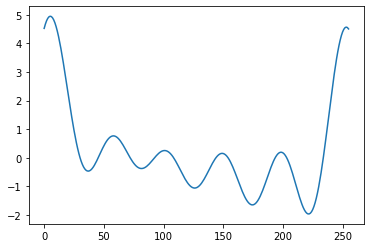

In [45]:
plt.plot(np.array(qq)/1e6/2/np.pi)


In [15]:
len(qq*4)

1024

In [46]:
from h5py import File

filename = 'snap_pi_n0.h5'
with File(filename, 'w') as f:
    f.create_dataset("Q_i", data=np.array(qi)/1e9)
    f.create_dataset("Q_q", data=np.array(qq)/1e9)

# OCT Pulses

In [47]:
filename = '../oct_pulses/g1.h5'
# filename = 'S:\\_Data\\210326 - QM_OPX\oct_pulses\\00000_g0_to_g1_2.0us_qamp_24.0_camp_0.12_gamp_0.1_dwdt_1.0_dw2dt2_0.1.h5'

with File(filename,'r') as a:
    Iq = array(a['uks'][-1][0])
    Qq = array(a['uks'][-1][1])
    Ic = array(a['uks'][-1][2])
    Qc = array(a['uks'][-1][3])

In [48]:
np.shape(Iq)

(1000,)

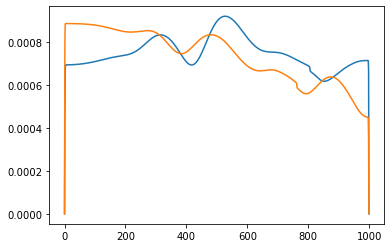

In [49]:
# plt.plot(Iq)
# plt.plot(Qq)
plt.plot(Ic)
plt.plot(Qc)
plt.show()

In [50]:
np.max(Ic), np.max(Qc)

(0.00091958314, 0.0008854964)

## Transfer Calibration

In [364]:
filename = '../drive_calibration/00000_2021_03_29_qubit_square.h5'
with File(filename,'r') as a:
    awg_amp_q = array(a['amps'])
    omega_q = array(a['omegas'])

# filename = '../drive_calibration/00000_2021_03_29_qubit_square.h5'
# with File(filename,'r') as a:
#     awg_amp_c = array(a['amps'])
#     omega_c = array(a['omegas'])

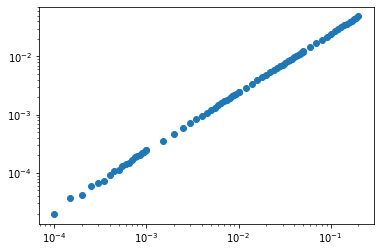

In [289]:
plt.loglog(awg_amp_q, omega_q, 'o')

In [366]:
def transfer_function(omegas_in, cavity=False, qubit=True, pulse_length=2000):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity

    if cavity==True:
        fn_file = '..\\drive_calibration\\00000_2021_04_01_cavity_square.h5'
    elif qubit==True:
        fn_file = '..\\drive_calibration\\00000_2021_03_29_qubit_square.h5'
        
    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, -omegas)
    amps = np.append(amps, -amps)
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)
    
    o_s = [x for y, x in sorted(zip(amps, omegas))]
    a_s = np.sort(amps)

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(o_s, a_s)
    output_amps = []
    max_interp_index = np.argmax(omegas)
    
    for i in range(len(omegas_in)):
        # if frequency greater than calibrated range, assume a proportional relationship (high amp)
        if np.abs(omegas_in[i]) > omegas[max_interp_index]:
            output_amps.append(omegas_in[i] * amps[max_interp_index] / omegas[max_interp_index])
        else:  # otherwise just use the interpolated transfer function
            output_amps.append(transfer_fn((omegas_in[i])))
    return np.array(output_amps)

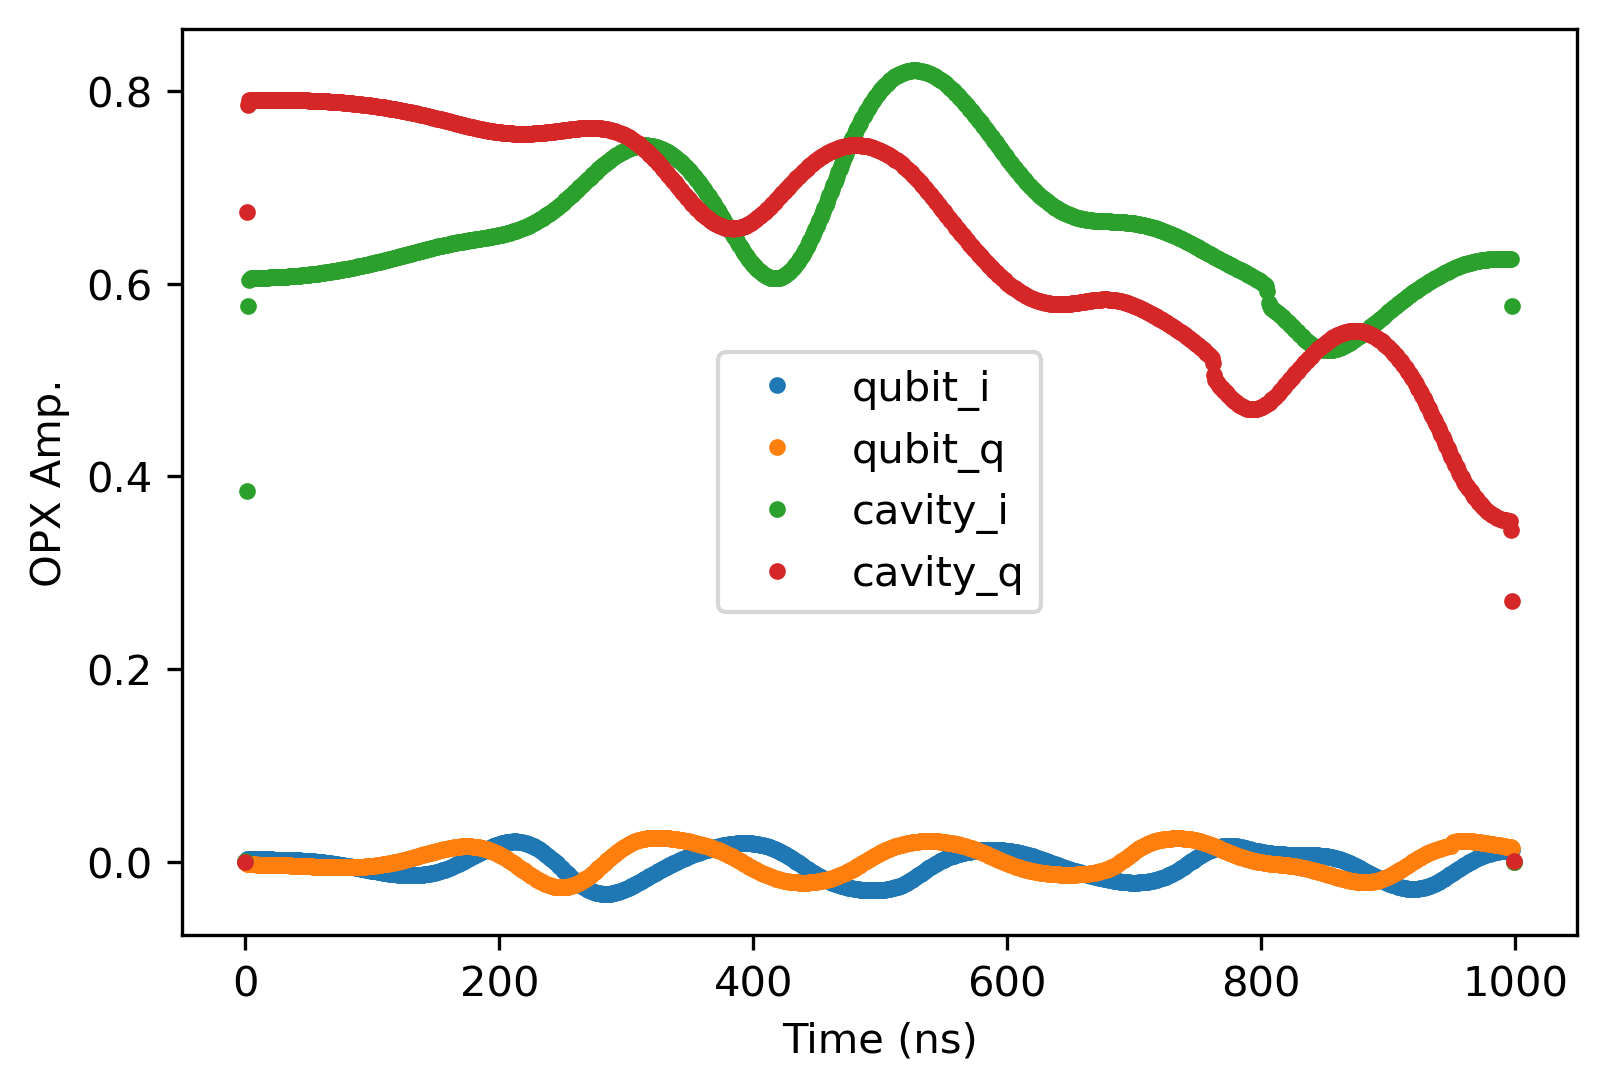

In [367]:
plt.figure(dpi=300)

plt.plot(transfer_function(Iq, qubit=True), '.', label='qubit_i')
plt.plot(transfer_function(Qq, qubit=True), '.',label='qubit_q')
plt.plot(transfer_function(Ic, cavity=True, qubit=False), '.', label='cavity_i')
plt.plot(transfer_function(Qc, cavity=True, qubit=False), '.', label='cavity_q')

plt.ylabel('OPX Amp.')
plt.xlabel('Time (ns)')
plt.legend()
plt.show()


In [341]:
len(Iq)

1000

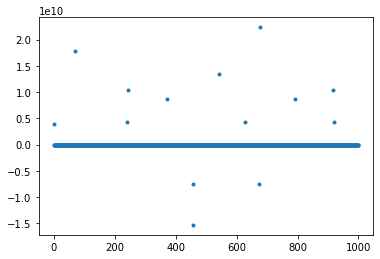

In [283]:
from scipy.interpolate import lagrange
import numpy as np
import matplotlib.pyplot as plt


funcs = []

####################
# measurement data #
####################
x = np.array([0, 1, 2, 3, 4, 5]) # rabi
y = 1.1*x+0.2 # amp
rabi = [0.5, 1.5, 2]
x = o
y = a
rabi = Iq

def amp_for_opx(rabi_cal, amp_cal, rabi):
    
    x = rabi_cal
    y = amp_cal
    
    #################
    # interpolation #
    #################
    funcs = []
    
    # left boundary (linear)
    poly = lagrange(x[0:2], y[0:2])
    funcs.append(poly)
    
#     if len(poly) != 2:
#         print('failed')


    # on the bulk (3order polynimial)
    for i in range(len(x)-3):
        poly = lagrange(x[i:i+4], y[i:i+4])
        funcs.append(poly)
        
#         if len(poly) != 4:
#             print('failed')

    # right boundary (linear)
    poly = lagrange(x[-2:], y[-2:])
    funcs.append(poly)
    
#     if len(poly) != 2:
#         print('failed')

#     print(funcs)
    
    amps = []
    for i in range(len(rabi)):
        amp_=0
        for j in range(len(rabi_cal)-1):
            
            if rabi[i]>=rabi_cal[j] and rabi[i]<rabi_cal[j+1]:
            
                if j==0 or j==len(rabi_cal)-1:
                    amp_ = funcs[j][0]*rabi[i]+funcs[j][1]
                else:
                    amp_ = funcs[j][0]*rabi[i]**3+funcs[j][1]*rabi[i]**2+funcs[j][2]*rabi[i]+funcs[j][3]
        amps.append(amp_)        
            
    return amps
    
amps_tr = amp_for_opx(x, y, rabi)

plt.plot(amps_tr,'.')
# plt.ylim(0, 0.0002)
# amps


In [256]:
poly[333333]

0

IndexError: list index out of range

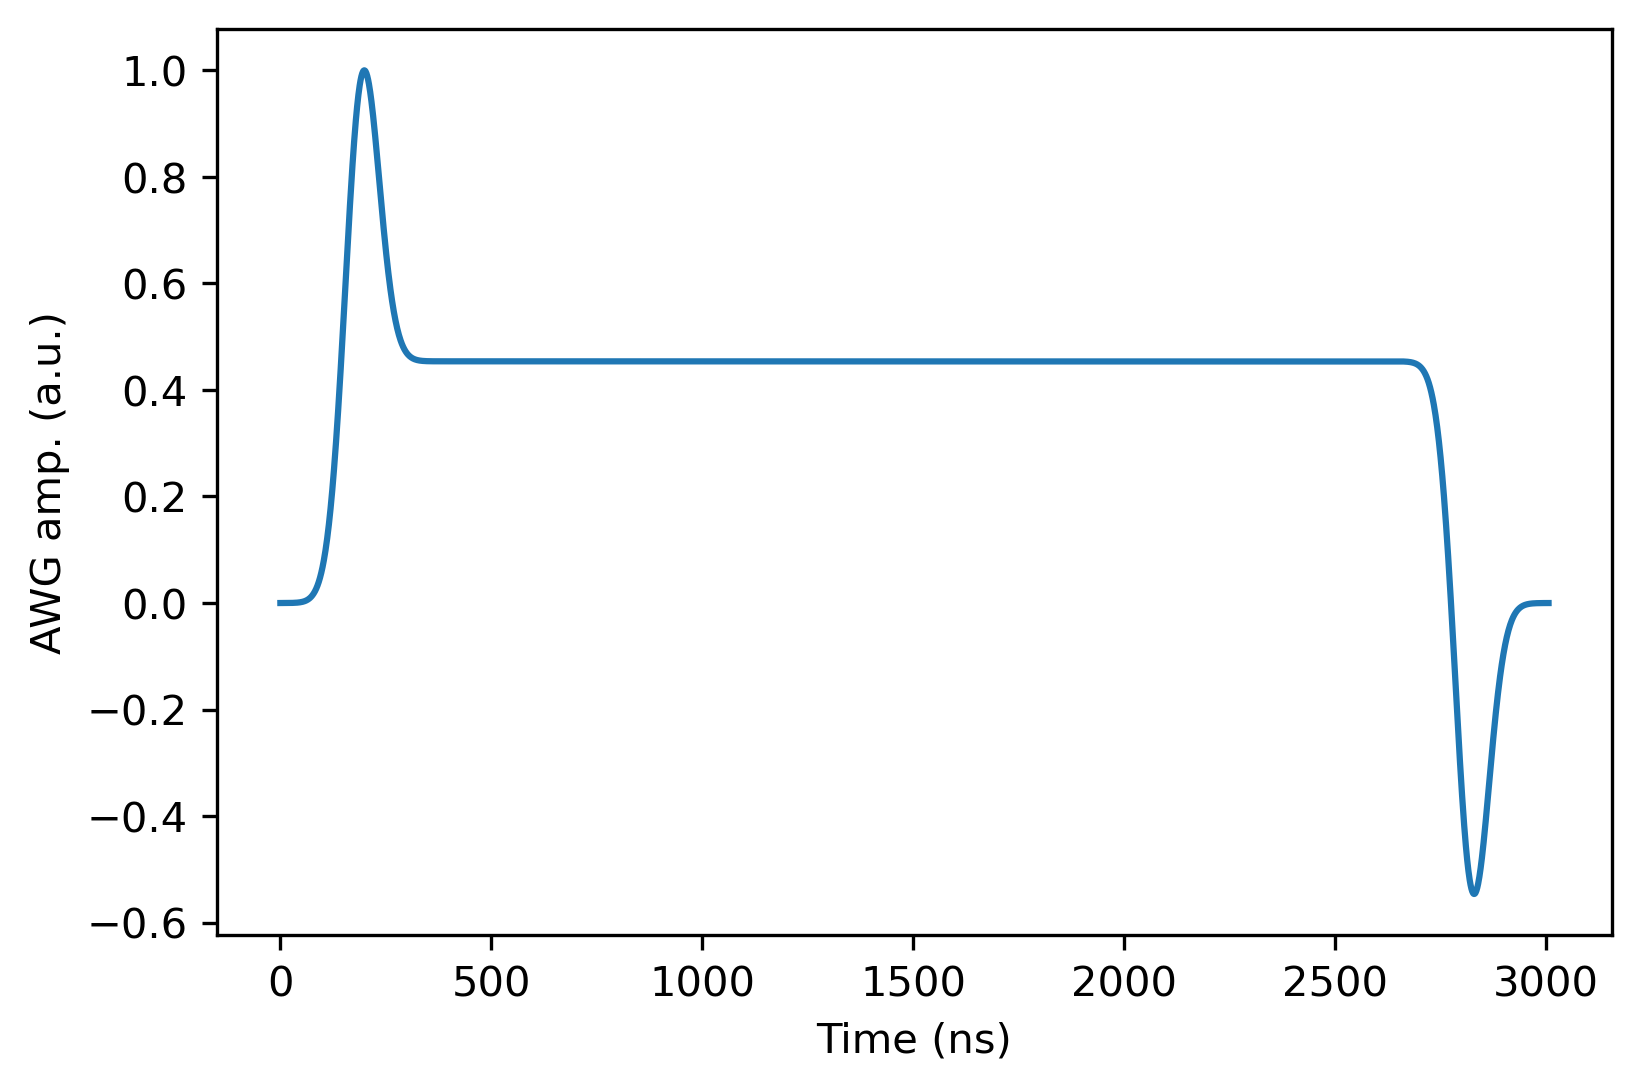

3008


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.special

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p, x):
    ### p[0] = center freq, p[1] = window width
    temp = np.zeros(len(x)) + 1j*np.zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/np.sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(np.sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(np.sqrt(2)*sig)))

def optimal_rr(readout_params, flat_top_amp):
    """All the necessary readout parameters"""
    rr_f, rr_q, rr_len, dt, twochi = readout_params 

    kappa = rr_f/rr_q #linewidth
    cav_freq = 0 #generate the pulse in rotating frame
    n_points = int(rr_len/dt/5) #number of points
    pad_factor = 10
    t = dt * np.arange(0, n_points * pad_factor)
    ifreq = np.fft.fftfreq(n_points * pad_factor, dt)
    freq = np.fft.fftshift(ifreq)
    """Hard cut-off to constrain the BW of the output pulse to be within the AWG BW"""
    if_band = IF_window([cav_freq, 250e6], freq) 

    """Minimum pulse length required to resolve the qubit g and e peaks"""
    pulse_len = 1/twochi
    
    """Find the sigma of rising waveform for a given flat-top amplitude (they are somehow related)"""
    sigarray = np.arange(15e-9, 60e-9, 1.0e-9)
    ratio = []
    
    for sig in sigarray:
        desired_output = erf_t(1, sig, pulse_len, 1500e-9, t)
        
        desired_output_ifft = np.fft.fft(desired_output, n_points * pad_factor)/n_points
        desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

        lorenz_c = cav_response_new([cav_freq, kappa], freq)

        input_sfft = (desired_output_sfft/lorenz_c)*if_band

        output_sfft = input_sfft*lorenz_c
        output_fft = np.fft.ifftshift(output_sfft)
        output_pulse = np.fft.ifft(output_sfft)

        input_fft = np.fft.ifftshift(input_sfft)
        input_pulse = np.fft.ifft(input_fft)

        flip = input_pulse[::-1]

        opt_pulse = np.real(flip)

        max_opt = np.max(opt_pulse)
        mid_opt = opt_pulse[int(len(opt_pulse)/2)]
        ratio.append(mid_opt/max_opt)

    """Returns an array of the steady state amplitude as a function of sigma"""    
    ratio_targ = flat_top_amp
    ratio = np.array(ratio)
    index = np.argmin(abs(ratio-ratio_targ))

    """Returns the sigma"""
    desired_sigma = sigarray[index]

    """Now generate the desired output shape"""
    desired_output = erf_t(1, desired_sigma, pulse_len, 1500e-9, t)

    desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq
    
    """Convolve with the Lorenztian transfer function of the cavity"""
    lorenz_c = cav_response_new([cav_freq, kappa], freq)
    
    input_sfft = (desired_output_sfft/lorenz_c)*if_band
 
    output_sfft = input_sfft * lorenz_c
    output_fft = np.fft.ifftshift(output_sfft)
    output_pulse = np.fft.ifft(output_sfft)

    input_fft = np.fft.ifftshift(input_sfft)
    input_pulse = np.fft.ifft(input_fft)
    flip = input_pulse[::-1]

    opt_pulse = np.real(flip)
    """Normalize the waveform"""
    opt_pulse = opt_pulse/np.max(opt_pulse)

    """Slice the waveform to remove padded zeros """
    result1 = np.where(opt_pulse > 0.00001)
    result2 = np.where(opt_pulse < -0.00001)

    #Trim Pulse
    start_trim = result1[0][0]
    end_trim = result2[0][len(result2[0])-1]
    numb = end_trim - start_trim  
    rem = numb % 4
    
    """Trim the pulse to be in multiples of 4ns, OPX AWG"""
    trim_pulse = opt_pulse[start_trim:end_trim - rem]
    check = len(trim_pulse) % 4
    if check !=0:
        print('Error: The final pulse is not a multiple of 4')
    
    return trim_pulse

"""Outputting an example pulse shape"""
read_params = [8.0517e9, 8400, 3.4e-6, 1e-9, 380e3]
s = optimal_rr(read_params, flat_top_amp=0.45)

plt.figure(dpi=300)
plt.plot(s)
plt.xlabel('Time (ns)')
plt.ylabel('AWG amp. (a.u.)')
plt.show()

print(len(s))

# Wigner tomography points generation

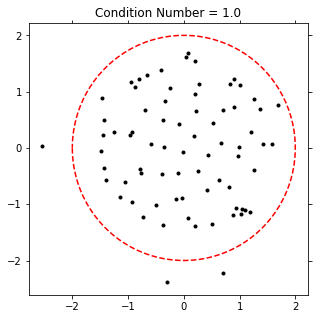

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
75
Final condition number and grad (1.00099918743573, array([-2.81848789e-01, -2.00359454e-03,  1.80226317e-03, -7.90034419e-03,
       -9.90863103e-03,  1.26043376e-03, -1.37383267e-02, -1.47705688e-01,
        6.26844753e-03,  2.65598254e-01, -1.73464109e-02, -1.03101780e-02,
        4.12612783e-03,  6.16691219e-02, -1.05889042e-02,  2.13971375e-02,
        1.82843474e-03,  1.78691634e-02,  2.35187301e-02, -1.16393735e-03,
        2.01264519e-02, -3.08840570e-01, -2.85180414e-02, -1.38078590e-02,
        4.04286197e-03, -5.97893817e-03,  1.00636533e-02, -1.03273185e-03,
        1.14991870e-02,  1.19954022e-02, -2.30218066e-02, -2.01688627e-02,
        2.52484111e-02, -1.26067544e-02, -4.79767834e-03, -4.13637615e-03,
        3.32658484e-02,  1.11222531e-02, -2.00697285e-03, -3.73432512e-06,
        3.74358496e-02,  2.33543913e-02,  2.41510846e-06,  1.90695713e-01,
       -1.95864403e-04,  7.31227992e-03,  1.41718583e-01,  1.84779752e-04

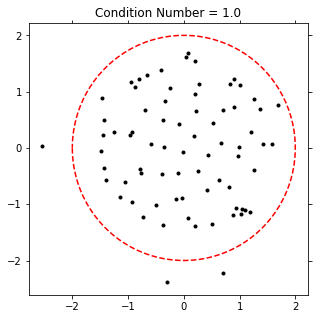

In [32]:
import matplotlib .pyplot as plt
import matplotlib .patches as mpatches
import numpy as np
from scipy.special import genlaguerre
from math import sqrt,factorial
from numpy.linalg import cond,svd
from scipy.optimize import fmin,check_grad,minimize
from IPython.display import display,clear_output
import time
# Number of photons
FD = 4
# Number of displacements
# n_disps = (FD+1)**2
n_disps = FD**2+30
n_disps -= 1
r = sqrt(FD)
th = linspace(-3.14, 3.14, 100)
# Analytically defines the wigner matrix and gradient, ND = number of points; FD = dimension
def wigner_mat_and_grad(disps, FD):
    ND = len(disps)
    wig_tens = np.zeros((ND,FD,FD),dtype=complex)
    grad_mat_r = np.zeros((ND,FD,FD),dtype=complex)
    grad_mat_i = np.zeros((ND,FD,FD),dtype=complex)
    B = 4*abs(disps)**2
    pf = (2/np.pi)*np.exp(-B/2.0)  # prefactor
    for m in range(FD):
        # calculate terms for n=m
        x = pf*np.real((-1)**m*genlaguerre(m, 0)(B))
        term_r = -4*disps.real*x
        term_i = -4*disps.imag*x
        if m > 0:
            y = 8*pf*(-1)**(m-1)*genlaguerre(m-1, 1)(B)  # first derivative of x
            term_r += disps.real * y
            term_i += disps.imag * y
        wig_tens[:, m, m] = x
        grad_mat_r[:, m, m] = term_r  # matrix is displacements * (laguerre + first derivative) real parts
        grad_mat_i[:, m, m] = term_i
        # calculate terms for n!=m (off-diagonal)
        for n in range(m+1, FD):
            pf_nm = sqrt(factorial(m)/float(factorial(n)))
            x = pf * pf_nm * (-1)**m * 2 * (2*disps)**(n-m-1) * genlaguerre (m, n-m)(B)
            term_r = ((n - m) - 4*disps.real*disps)*x
            term_i = (1j * (n - m) - 4*disps.imag*disps) * x
            if m > 0:
                y = 8 * pf * pf_nm * (-1)**(m-1)*(2*disps)**(n-m) *genlaguerre (m-1, n-m+1)(B)  # first derivative
                term_r += disps.real * y
                term_i += disps.imag * y
            wig_tens[:, m, n] = disps * x
            wig_tens[:, n, m] = (disps * x).conj()
            grad_mat_r[:, m, n] = term_r
            grad_mat_r[:, n, m] = term_r.conjugate()  # complex conjugate
            grad_mat_i[:, m, n] = term_i
            grad_mat_i[:, n, m] = term_i.conjugate()
        # wig_tens is just the matrix, grad_mat_r and grad_mat_i are real/imaginary parts of gradient (+ the matrix)?
    return (wig_tens.reshape((ND, FD**2)), grad_mat_r.reshape((ND, FD**2)), grad_mat_i.reshape((ND, FD**2)))
# Computes the gradient of the condition number in a nifty way!
def cost_and_grad(r_disps):
    N = len(r_disps)  # r_disps is all real parts of alphas, then all complex parts of alphas
    c_disps = r_disps[:N//2] + 1j*r_disps[N//2:]  # complex displacements
    M, dM_rs, dM_is = wigner_mat_and_grad(c_disps,FD)
    # print(dM_rs, dM_is)  # in general dM_rs and dM_is have complex number entries
    U, S, Vd = svd(M) # singular value decomposition M = U S Vd; U is unitary, S is diagonal, rows of Vd are eigenvectors
    NS = len(Vd)
    cn = S[0] / S[-1]  # condition number
    # Einstein summation convention acted on operands
    dS_r = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs, Vd.conj().T).real
    dS_i = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is, Vd.conj().T).real
    # gradients of the condition number, split into real/imaginary parts
    grad_cn_r =(dS_r[0]*S[-1]-S[0]*dS_r[-1])/(S[-1]**2)
    grad_cn_i =(dS_i[0]*S[-1]-S[0]*dS_i[-1])/(S[-1]**2)
    return cn, np.concatenate((grad_cn_r,grad_cn_i))
# Computes the gradient of the condition number in a nifty way!
def cost_and_grad_analytic(r_disps):
    N = len(r_disps)  # r_disps is all real parts of alphas, then all complex parts of alphas
    c_disps = r_disps[:N//2] + 1j*r_disps[N//2:]  # complex displacements
    M, dM_rs, dM_is = wigner_mat_and_grad(c_disps,FD)
    # print(dM_rs, dM_is)  # in general dM_rs and dM_is have complex number entries
    U, S, Vd = svd(M) # singular value decomposition M = U S Vd; U is unitary, S is diagonal, rows of Vd are eigenvectors
    NS = len(Vd)
    cn = S[0] / S[-1]  # condition number
    # Einstein summation convention acted on operands
    dS_r = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs, Vd.conj().T).real
    dS_i = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is, Vd.conj().T).real
    # gradients of the condition number, split into real/imaginary parts
    grad_cn_r =(dS_r[0]*S[-1]-S[0]*dS_r[-1])/(S[-1]**2)
    grad_cn_i =(dS_i[0]*S[-1]-S[0]*dS_i[-1])/(S[-1]**2)
    return cn, np.concatenate((grad_cn_r,grad_cn_i))
best_cost = float('inf')
# Plotting for the results, returns cost and grad in a way the minimize function can handle
f,ax =plt.subplots(figsize =(5, 5))
def wrap_cost(disps):
    global best_cost
    cost, grad = cost_and_grad(disps)
    # print(grad)
    best_cost = min(cost, best_cost)
    ax.clear()
    ax.plot(disps[:n_disps],disps[n_disps:], 'k.')
    ax.plot(r*cos(th),r*sin(th),'r--')
    ax.set_title('Condition Number = %.1f' % (cost ,))
    clear_output(wait=True)
    display(f)
    #print ’\r%s (%s)’ % (cost , best cost),
    return cost, grad
init_disps = np.random.normal(0,1,2*n_disps)*0.5
init_disps[0] = init_disps[n_disps] = 0
ret = minimize(wrap_cost, init_disps,method='L-BFGS-B', jac=True, options=dict(ftol =1e-6))
print (ret.message)
new_disps = ret.x[:n_disps] + 1j*ret.x[n_disps:]
new_disps = np.concatenate(([0],new_disps))
print(len(new_disps))
n_disps_after = len(new_disps)
temp_disps = np.append(np.real(new_disps), np.imag(new_disps))
print("Final condition number and grad", cost_and_grad_analytic(ret.x))
print("Final condition number and grad with 0 point", cost_and_grad_analytic(temp_disps))

In [9]:
new_disps

array([ 0.        +0.j        , -0.30948086+0.15173344j,
       -0.76514502+0.31699037j, -1.29834253+0.30612827j,
        0.53133464+0.3696847j ,  0.02806235+0.57076902j,
       -0.71984678-0.88832602j, -0.30933634+0.88148404j,
        0.22720723-0.61574557j, -0.64637726+1.00664262j,
       -0.17939666-1.06327369j,  0.17241199-0.0297701j ,
        0.90012829+0.70695832j,  0.89684487+0.75735642j,
       -0.83842791+0.96822401j, -0.26615417-1.08827242j,
       -0.24742638-0.41818235j, -0.77390123-0.18148297j,
        1.07955647-0.47097983j,  0.66063035-0.2119921j ,
        0.19711449+1.21986674j,  1.04182939+0.61698329j,
        0.64963346-1.07804063j,  0.88392421-0.65000427j,
       -1.00568563-0.5451894j ])

In [11]:
new_disps[10]

(-0.17939666045291305-1.0632736859939238j)

In [15]:
alpha = np.abs(new_disps)

max(alpha)

1.3339444717821696

In [19]:
alpha_awg_cal(1.33, cav_amp=0.75)

386.0

In [31]:
beta = 1/1.0
print ("xi vs a = ", beta,"2$\pi$ GHz")
t = 300
print ("tomography pulse length (gauss) = ",t,"ns")
alpha = beta*t*sqrt(2*pi)
print ("alpha for a = 1:", alpha)
ax = real(new_disps)/(beta*t*sqrt(2*pi))
ay = imag(new_disps)/(beta*t*sqrt(2*pi))
a = abs(new_disps)/(beta*t*sqrt(2*pi))
# print ("a_x = ",list(ax))
# print ("a_y = ",list(ay))
print ("a_x (max) = ",max(abs(ax)))
print ("a_y (max) = ",max(abs(ay)))
print ("a (max) = ",max(a))
print (ax)
import h5py as h5
import numpy as np
filepath = 'C:\\_Lib\\python\\slab\\experiments\\qm_opx\\wigner_function_points\\'
filename = 'wigner_points_nmax_%s_nexpt_%s_kappa_%spt%s_gauss'%(FD,n_disps_after,
                                                    int(best_cost), int(10*(best_cost-int(best_cost))))
file_number = 0
fullname = filepath + str(file_number).zfill(5) + "_" + filename +".h5"
print (fullname)

with File(fullname, 'w') as f:
    f.create_dataset('ax', data=ax)
    f.create_dataset('ay', data=ay)
    f.create_dataset('alphax', data=real(new_disps))
    f.create_dataset('alphay', data=imag(new_disps))

xi vs a =  1.0 2$\pi$ GHz
tomography pulse length (gauss) =  300 ns
alpha for a = 1: 751.9884823893001
a_x (max) =  0.002107374786909711
a_y (max) =  0.0019289911633591829
a (max) =  0.0024372430090683836
[ 0.00000000e+00 -1.23479970e-04 -1.04591250e-03 -1.39061253e-03
  1.43984078e-03 -3.79496598e-04  3.56960454e-04  1.36830135e-03
  9.14043480e-04 -1.66335072e-03  1.41485103e-04 -4.16022967e-04
  1.13320489e-05  7.77482021e-04 -6.11914656e-04  6.78619924e-04
  9.61813170e-04  6.38627248e-04  1.14207151e-03 -9.49348029e-04
 -9.67853836e-04  1.41269233e-03 -5.07880824e-04  4.42048132e-04
  4.56982873e-04 -1.65616346e-03  1.98114482e-03  1.08258547e-03
  1.36970984e-03  1.41852415e-03 -2.09367892e-03  3.42928315e-04
  1.10204793e-03  1.43459621e-03 -1.50967731e-03 -6.15174385e-04
 -1.59971897e-04  2.66569760e-04 -6.93170900e-05 -5.28194830e-04
 -1.23907661e-04 -4.12661159e-04  1.56105378e-03 -1.71475975e-03
 -1.47301612e-03  7.56748984e-04  4.99410461e-04  2.10737479e-03
 -1.12837390e-0

In [20]:
path = os.getcwd()
cal_path = os.path.join(path, "drive_calibration")


def alpha_awg_cal(alpha, cav_amp=0.4):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity
    cal_path = 'C:\_Lib\python\slab\experiments\qm_opx\drive_calibration'

    fn_file = cal_path + '\\00000_2021_05_10_cavity_square.h5'

    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)

    o_s = omegas
    a_s = amps

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

    omega_desired = transfer_fn(cav_amp)

    pulse_length = (alpha/omega_desired)
    """Returns time in units of 4ns for FPGA"""
    return abs(pulse_length)//4+1



def wigner_alpha_awg_amp(wigner_pt_file = None, cavity_cal_file = None, cav_len=2000):
    
    with File(wigner_pt_file, 'r') as f:
        xs = np.array(f['alphax'])
        ys = np.array(f['alphay'])

    tom_amp = np.sqrt(xs ** 2 + ys ** 2)
    tom_phase = np.arctan2(ys, xs)
    
    omega_desired = tom_amp/cav_len #keeping the cavity length fixed
    
    with File(cavity_cal_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, -omegas)
    amps = np.append(amps, -amps)
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)
    o_s = omegas
    a_s = amps

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(o_s, a_s)
    
    awg_amp = transfer_fn(omega_desired)

    """Returns time in units of 4ns for FPGA"""
    
    x_awg = awg_amp * np.cos(tom_phase)
    y_awg = awg_amp * np.sin(tom_phase)
    
    return x_awg, y_awg, cav_len


In [23]:
cav_file = '../drive_calibration/00000_2021_05_10_cavity_square.h5'
wigner_file = '../wigner_function_points/00000_wigner_points_nmax_3_nexpt_25_kappa_1pt0_gauss.h5'

a, b = wigner_alpha_awg_amp(wigner_pt_file=wigner_file, cavity_cal_file=cav_file)

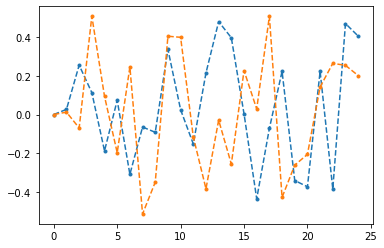

In [26]:
plt.plot(a, '.--')
plt.plot(b, '.--')

In [27]:
np.max(a), np.max(b)

(0.4814280863708492, 0.509262056007122)

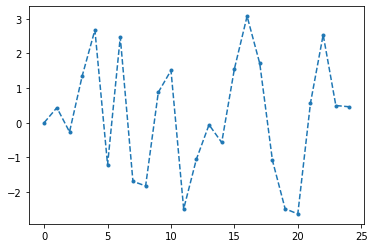

In [31]:
plt.plot(b, '.--')

In [33]:
cav_file = '../drive_ calibration/00000_2021_04_01_cavity_square.h5'
wigner_file = '../wigner_function_points/00000_wigner_points_nmax_3_nexpt_25_kappa_1pt0_gauss.h5'

a, b = wigner_alpha_awg_amp(wigner_pt_file=wigner_file, cavity_cal_file=cav_file)

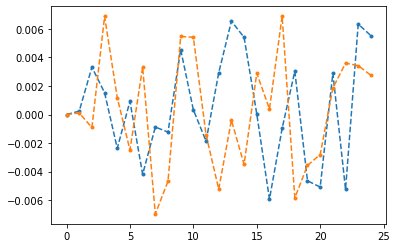

In [35]:
plt.plot(a, '.--')
plt.plot(b, '.--')

In [ ]:
def transfer_function(omegas_in, cavity=False, qubit=True, pulse_length=2000):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity

    if cavity==True:
        fn_file = cal_path + '\\00000_2021_04_01_cavity_square.h5'
    elif qubit==True:
        fn_file = cal_path + '\\00000_2021_03_29_qubit_square.h5'

    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, -omegas)
    amps = np.append(amps, -amps)
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)

    o_s = [x for y, x in sorted(zip(amps, omegas))]
    a_s = np.sort(amps)

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(o_s, a_s)
    output_amps = []
    max_interp_index = np.argmax(omegas)

    for i in range(len(omegas_in)):
        # if frequency greater than calibrated range, assume a proportional relationship (high amp)
        if np.abs(omegas_in[i]) > omegas[max_interp_index]:
            output_amps.append(omegas_in[i] * amps[max_interp_index] / omegas[max_interp_index])
        else:  # otherwise just use the interpolated transfer function
            output_amps.append(transfer_fn((omegas_in[i])))
    return np.array(output_amps)


In [6]:
def alpha_awg_cal(alpha, cav_amp=0.4):
    # takes input array of omegas and converts them to output array of amplitudes,
    # using a calibration h5 file defined in the experiment config
    # pull calibration data from file, handling properly in case of multimode cavity
    cal_path = 'C:\_Lib\python\slab\experiments\qm_opx\drive_calibration'

    fn_file = cal_path + '\\00000_2021_05_10_cavity_square.h5'

    with File(fn_file, 'r') as f:
        omegas = np.array(f['omegas'])
        amps = np.array(f['amps'])
    # assume zero frequency at zero amplitude, used for interpolation function
    omegas = np.append(omegas, 0.0)
    amps = np.append(amps, 0.0)

    o_s = omegas
    a_s = amps

    # interpolate data, transfer_fn is a function that for each omega returns the corresponding amp
    transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

    omega_desired = transfer_fn(cav_amp)

    pulse_length = (alpha/omega_desired)
    """Returns time in units of 4ns for FPGA"""
    return abs(pulse_length)//4+1


# QuTip simulation